<a href="https://colab.research.google.com/github/Anoshawott/LLM-Guided-Reward-Shaping-for-RL/blob/main/LLM_Guided_Reward_Shaping_for_RL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **LLM-Guided Reward Shaping for Reinforcement Learning - Domain Expert LLM Shapers in Action**

---

# **Executive Summary**

This study explored whether **Large Language Models (LLMs)** can improve reinforcement learning (RL) through **reward shaping** in a retail inventory management task. The approach combined LLM-generated shaping functions with PPO training across a three-phase pipeline:

1. **Phase 1 – Reward Function Search:** LLMs generated candidate shaping penalties, which were validated and filtered based on execution success and preliminary performance.
2. **Phase 2 – Hyperparameter Optimisation:** Top candidates were tuned with Optuna to identify their best PPO hyperparameters.
3. **Phase 3 – Cross-Evaluation:** Shaped policies were evaluated against baselines (Base PPO, Fixed Action, and Base Stock Policy) over multiple seeds and episodes.

**Key Findings:**

* **Baseline PPO performed strongly**, often matching or outperforming LLM-shaped policies.
* **LLM shaping effects were mostly negligible**, though in isolated cases it led to lower base costs.
* **Methodological choices** (e.g., short training runs, reward-based optimisation in Phase 2) may have limited the ability to detect consistent benefits.

**Conclusion:**
While LLM shaping did not consistently outperform baseline PPO in this structured environment, the **methodology is valuable**. LLMs reliably produced interpretable shaping functions and demonstrated potential as **collaborative reward engineers**. The framework provides a scalable way to inject domain knowledge and creative ideation into RL, especially promising for **complex, less-structured domains** (e.g., robotics, healthcare, resource allocation).

---


# Introduction

This notebook demonstrates a powerful approach for combining the strengths of Reinforcement Learning (RL) and Large Language Models (LLMs) to solve complex problems that require creative and adaptive solutions.

While the specific application here is inventory management, the core methodology of using LLMs for policy shaping has significant value for clients across various domains. The key takeaway is the ability to leverage the vast knowledge and ideation capabilities of LLMs to:

**Generate Novel Reward Functions**

LLMs can interpret high-level problem descriptions and desired policy characteristics to propose innovative reward functions. This goes beyond standard reward engineering and can uncover new ways to incentivize desired agent behaviors in complex, non-stationary, or partially observable environments.

**Incorporate Domain Expertise**

By providing the LLM with domain-specific information and feedback, you can inject expert knowledge into the reward function generation process. This allows for the creation of policies that are not only optimal in simulation but also align with real-world constraints and business objectives.

**Iteratively Refine Solutions**

The framework's iterative feedback loop allows the LLM to refine its generated reward functions based on observed agent performance. This continuous improvement process is crucial for tackling challenging RL problems where finding an effective reward signal is difficult.
Improve Interpretability: By explicitly defining the shaping penalty code, you gain insights into why the agent is behaving in a certain way. This interpretability is often lacking in complex end-to-end deep RL systems.

---

Therefore, the value for clients lies in the methodology itself: using LLMs as intelligent assistants for designing effective RL policies in domains where traditional methods struggle or where novel solutions are highly beneficial. This could include areas like:

- Robotics: Generating reward functions for complex manipulation tasks or human-robot interaction.
- Resource Management: Optimising energy consumption, network traffic, or supply chain logistics with adaptive policies.
- Healthcare: Developing personalised treatment plans or optimizing resource allocation in hospitals.
- Finance: Creating adaptive trading strategies or risk management policies.

The notebook serves as a concrete example of how this LLM-based policy shaping approach can be implemented and evaluated, providing a blueprint for applying this technique to other challenging RL problems that can benefit from creative ideation and the integration of diverse knowledge sources.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install stable-baselines3[extra] optuna langchain_openai python-dotenv langgraph langchain-community shimmy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.5/74.5 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.3/153.3 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.2/187.2 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 12.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existi

# Retail Inventory Environment Definitions

- Simulating weekly inventory management of single product in a retail store.
- Goal (agent objective): minimise total cost by balancing overstock holding costs, stockout (lost sales) costs and order costs.

Components include:
- State (observation/vector): current inventory level, last week's demand, day of week or seasonality index, lead time remaining (if any), incoming stock (if any already ordered)
- Reward: reward = - (holding_cost + stockout_cost + ordering_cost)
holding_cost = holding_cost_per_unit * current_inventory
stockout_cost = lost_sales * penalty
ordering_cost = fixed + variable

- Transition (step): Demand is stochastic but can follow a seasonal pattern + randomness, orders arrive with a lead time e.g. 2 days, inventory is updated daily or weekly, lost sales are penalised.

Simulation dynamics
- Holding cost: \$1/unit/week
- Stockout penalty: \$10/unit lost
- Order cost: \$20 + \$0.50/unit
- Lead time: 1-2 weeks randomly
- Demand: Poisson(lambda=20 + 5 * sin(week_of_year / 52 * 2pi)), a simulation could look as below:

In [ ]:
# Package Import
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
import optuna
import json
import traceback
import pandas as pd
import os
import base64
from google.colab import userdata

import uuid # Import uuid for generating unique identifiers
import inspect # Import inspect to check function signature
from langchain_openai import ChatOpenAI
from langchain import hub
from langchain.tools import tool
from langchain_core.messages import HumanMessage
from langchain_core.prompts import PromptTemplate


import warnings
warnings.filterwarnings('ignore')

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:151: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=

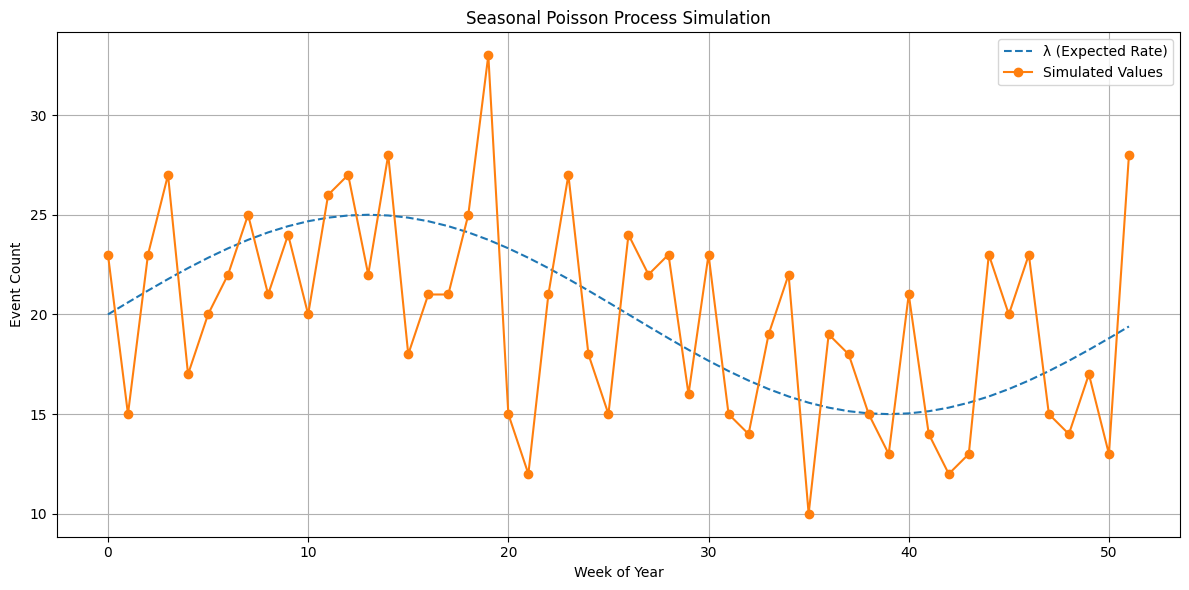

In [ ]:
# Set random seed for reproducibility
np.random.seed(42)

# Define weeks in a year
weeks = np.arange(52)

# Define lambda function
lambdas = 20 + 5 * np.sin(2 * np.pi * weeks / 52)

# Simulate Poisson-distributed values for each week
simulated_values = np.random.poisson(lam=lambdas)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(weeks, lambdas, label='λ (Expected Rate)', linestyle='--')
plt.plot(weeks, simulated_values, label='Simulated Values', marker='o')
plt.xlabel('Week of Year')
plt.ylabel('Event Count')
plt.title('Seasonal Poisson Process Simulation')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Environment Setup

In [ ]:
class RetailInventoryEnv(gym.Env):
  def __init__(self):
    super().__init__()
    self.max_inventory = 50
    self.max_order = 35
    self.lead_time = 2

    self.action_space = spaces.Discrete(self.max_order + 1)
    self.observation_space = spaces.Box(low=0, high=self.max_inventory, shape=(4,), dtype=np.float32)

    self.holding_cost = 1
    self.stockout_cost = 10
    self.order_cost_fixed = 20
    self.order_cost_per_unit = 0.5

    self.reset()

  def reset(self, seed=None, options=None):
    super().reset(seed=seed) # Pass the seed to the superclass reset
    if seed is not None:
        np.random.seed(seed)  # Also sets global NumPy seed for reproducibility

    self.inventory = 20
    self.backlog = 0
    self.incoming_orders = []
    self.week = 0
    self.last_demand = 0
    info = {} # Add info dictionary
    return self._get_obs(), info # Return obs and info

  def _get_obs(self):
    return np.array([
        self.inventory,
        self.last_demand,
        np.sin(2 * np.pi * self.week / 52),
        sum([qty for _, qty in self.incoming_orders])
    ], dtype=np.float32)

  def step(self, action):
    self.week += 1

    if action > 0:
      self.incoming_orders.append((self.lead_time, action))

    self.incoming_orders = [(t - 1, q) for (t, q) in self.incoming_orders]
    arrivals = sum(q for t, q in self.incoming_orders if t == 0)
    self.incoming_orders = [(t, q) for (t, q) in self.incoming_orders if t > 0]
    self.inventory += arrivals

    base_demand = 20 + 5 * np.sin(2 * np.pi * self.week / 52)
    self.last_demand = int(np.random.poisson(base_demand))

    sold = min(self.inventory, self.last_demand)
    lost_sales = max(0, self.last_demand - self.inventory)
    self.inventory -= sold

    holding = self.holding_cost * self.inventory
    stockout = self.stockout_cost * lost_sales
    order_cost = self.order_cost_fixed * (action > 0) + self.order_cost_per_unit * action
    total_cost = holding + stockout + order_cost
    reward = -total_cost
    done = self.week >= 52

    return self._get_obs(), reward, done, False, {} # Added truncated and info

  def render(self, mode='human'):
    print(f"Week: {self.week}, Inventory: {self.inventory}, Last Demand: {self.last_demand}")

# Establishing an Overall Baseline
Given the characteristics of the inventory environment, we adopt a Base Stock Policy (BSP) as the baseline due to its analytical traceability and cost-aware decision structure. In this setting, each week, demand follows a seasonal Poisson distribution, and the system incurs a 1 holding cost per unit per week, a 10 penalty for each unit of unmet demand, and an order cost comprising a fixed 20 fee plus 0.50 per unit ordered. Lead time is stochastic, varying between 1 and 2 weeks introducing some uncertainty in order arrival.

Despite the random lead time and fixed ordering these violate the assuptions under which BSP is optimal i.e. zero or constant lead time, no fixed ordering costs, and independent and identically distributed (i.i.d) demand (demand is seasonal - non-stationary Poisson). However, we select the BSP as a benchmark since it allows us to derive a principled, static replenshiment rule against which more complex policies, such as RL-driven strategies can be evaluated; (http://arxiv.org/pdf/2304.08769) "*Cooperative Multi-Agent Reinforcement Learning for Inventory
Management*". In environments with moderate cost asymmetries BSP often performs surprisingly well even under stochasticity, and deviations from it can reveal where RL models offer true advantage.

To derive the BSP, we apply the newsvendor critical ratio framework, a foundational concept in inventory theory to determine an optimal order quantity in the presence of uncertain demand and cost asymmetry between overstocking and understocking. Balancing the marginal cost of overstocking against understocking the critical ratio is given by:

$ \frac{q}{q+h} = \frac{10}{10+1} = 0.909 $

This defines our **target service level** meaning we should stock enough units each week to cover **90.9% of expected demand**, minimising expected total cost. Using the seasonal Poisson demand mode we compute the 90.9th percentile of the Poisson distribution for each week t to obtain the base stock level S(t). The order quantity is then determined as:

$$ Q_t = max(0, S(t)-I_t ) $$

where I_t is the current inventory position. This policy ensures a cost-aware, demand-sensitive ordering rule that adjusts seasonally, and serves as a strong analytical baseline for comparing RL agent performance in simulation.



Below we compare the fixed product order strategy against BSP to test that it works optimally as intended.

Episode finished after 52 weeks.
Total Reward: -3407.0

--- Performance Summary ---
Total Reward over 52 weeks: -3407.00
Average Weekly Reward: -65.52
Minimum Weekly Reward: -150.00
Maximum Weekly Reward: -30.00
Standard Deviation of Weekly Reward: 28.93


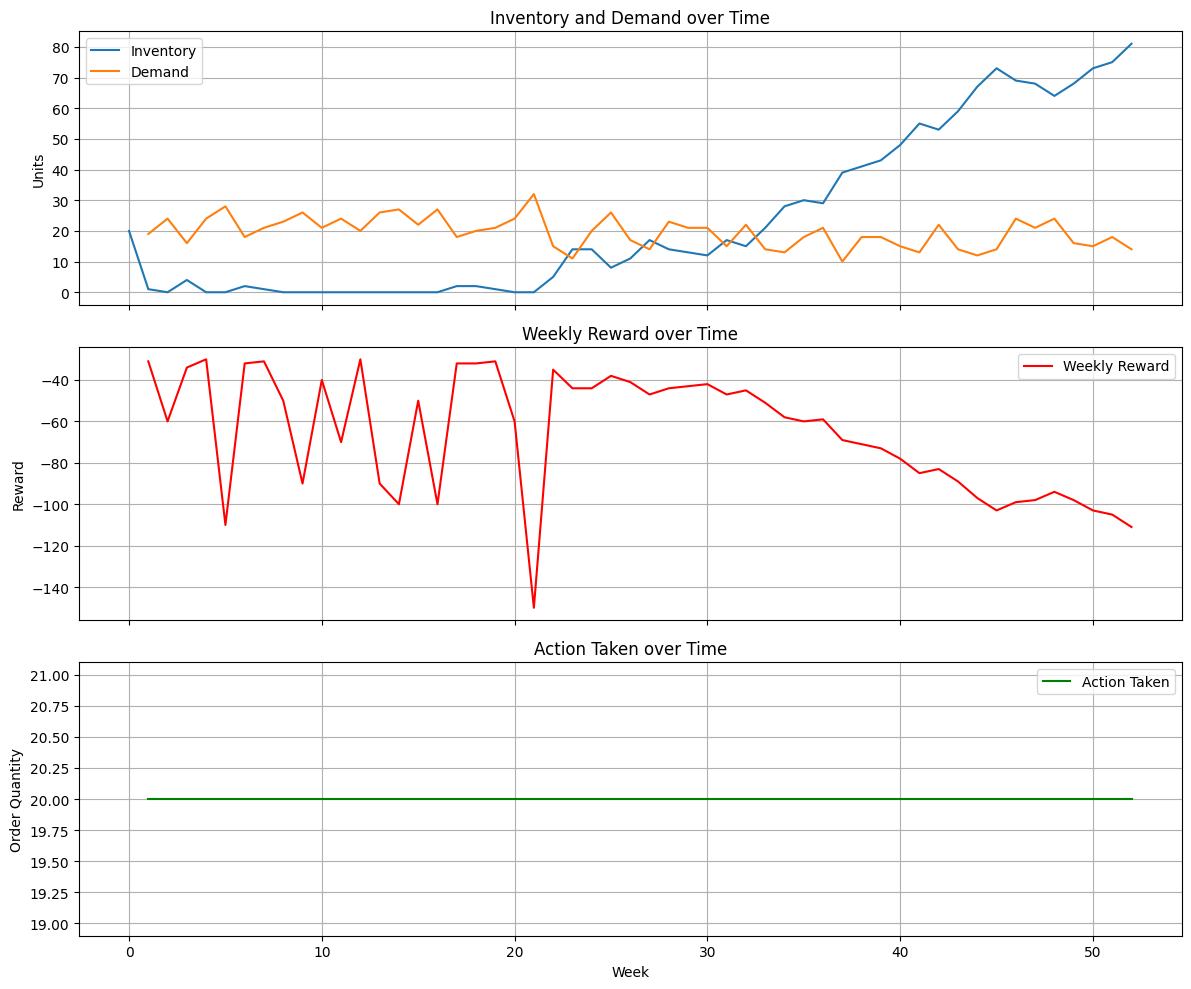

In [ ]:
# Instantiate the environment
env = RetailInventoryEnv()

# Reset the environment to its initial state
obs, info = env.reset(seed=42) # Also unpack info from reset

# Lists to store data for visualization
inventory_history = [obs[0]]
demand_history = [obs[1]]
reward_history = []
week_history = [0]
action_history = [] # Store actions taken

# Run a simulation for 52 steps (one year)
total_reward = 0
for i in range(52):
    # Choose a simple action (e.g., order 25 units each week)
    action = 20
    # Alternatively, choose a random action
    # action = env.action_space.sample()

    # Take a step in the environment
    obs, reward, done, truncated, info = env.step(action) # Added truncated

    # Store data for visualisation
    inventory_history.append(obs[0])
    demand_history.append(obs[1])
    reward_history.append(reward)
    week_history.append(i + 1)
    action_history.append(action) # Store the action

    total_reward += reward

    if done:
        print("Episode finished after 52 weeks.")
        break

print("Total Reward:", total_reward)

print("\n--- Performance Summary ---")
print(f"Total Reward over 52 weeks: {total_reward:.2f}")
print(f"Average Weekly Reward: {np.mean(reward_history):.2f}")
print(f"Minimum Weekly Reward: {np.min(reward_history):.2f}")
print(f"Maximum Weekly Reward: {np.max(reward_history):.2f}")
print(f"Standard Deviation of Weekly Reward: {np.std(reward_history):.2f}")


# Plotting the results
fig, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True) # 3 subplots

# Plot Inventory and Demand
axes[0].plot(week_history, inventory_history, label='Inventory')
axes[0].plot(week_history[1:], demand_history[1:], label='Demand') # Demand is recorded after step
axes[0].set_ylabel('Units')
axes[0].set_title('Inventory and Demand over Time')
axes[0].legend()
axes[0].grid(True)

# Plot Weekly Reward
axes[1].plot(week_history[1:], reward_history, label='Weekly Reward', color='red')
axes[1].set_ylabel('Reward')
axes[1].set_title('Weekly Reward over Time')
axes[1].legend()
axes[1].grid(True)

# Plot Actions Taken
axes[2].step(week_history[1:], action_history, label='Action Taken', color='green', where='pre') # Use step plot for actions
axes[2].set_xlabel('Week')
axes[2].set_ylabel('Order Quantity')
axes[2].set_title('Action Taken over Time')
axes[2].legend()
axes[2].grid(True)


plt.tight_layout()
plt.show()

The following creates a new simulation loop that implements the Base Stock Policy as described. This will involve calculating the base stock level each week based on the seasonal demand and critical ratio, and then determining the order quantity.


In [ ]:
obs_bsp, info_bsp = env_bsp.reset(seed=42)
obs_bsp

array([20.,  0.,  0.,  0.], dtype=float32)

In [ ]:
# Instantiate the environment
env_bsp = RetailInventoryEnv()

# Reset the environment to its initial state
obs_bsp, info_bsp = env_bsp.reset(seed=42) # Capture info as well

# Lists to store data for visualization
inventory_history_bsp = [obs_bsp[0]]
demand_history_bsp = [obs_bsp[1]]
reward_history_bsp = []
week_history_bsp = [0]
action_history_bsp = [] # Store actions taken

# Critical ratio
critical_ratio = 10 / (10 + 1) # 0.909

# Run a simulation for 52 steps (one year)
total_reward_bsp = 0
for i in range(52):
    # Calculate expected demand for the current week
    expected_demand = 20 + 5 * np.sin(2 * np.pi * (i + 1) / 52) # Use i+1 for the current week

    # Calculate the base stock level S(t)
    base_stock_level = poisson.ppf(critical_ratio, expected_demand)

    # Get current inventory level
    current_inventory = obs_bsp[0]

    # Calculate the order quantity
    # Ensure base_stock_level and current_inventory are scalar before subtraction
    action_bsp = max(0, int(base_stock_level.item() - current_inventory.item()))

    # Take a step in the environment
    obs_bsp, reward_bsp, done_bsp, truncated_bsp, info_bsp = env_bsp.step(action_bsp) # Capture truncated and info

    # Store data for visualisation
    inventory_history_bsp.append(obs_bsp[0])
    demand_history_bsp.append(obs_bsp[1])
    reward_history_bsp.append(reward_bsp)
    week_history_bsp.append(i + 1)
    action_history_bsp.append(action_bsp) # Store the action

    total_reward_bsp += reward_bsp

    if done_bsp:
        print("Episode finished after 52 weeks.")
        break

print("Total Reward (BSP):", total_reward_bsp)

Episode finished after 52 weeks.
Total Reward (BSP): -2610.5


Comparing the total rewards we have their performances as follows:



In [ ]:
print("--- Comparison of Policies ---")
print(f"Total Reward (Fixed Action): {total_reward:.2f}")
print(f"Total Reward (Base Stock Policy): {total_reward_bsp:.2f}")

if total_reward_bsp > total_reward:
    print("\nBased on total reward, the Base Stock Policy performed better.")
elif total_reward > total_reward_bsp:
    print("\nBased on total reward, the Fixed Action policy performed better.")
else:
    print("\nBoth policies resulted in the same total reward.")

--- Comparison of Policies ---
Total Reward (Fixed Action): -3407.00
Total Reward (Base Stock Policy): -2610.50

Based on total reward, the Base Stock Policy performed better.


Below we visualise the weekly and cumulative rewards for both policies.



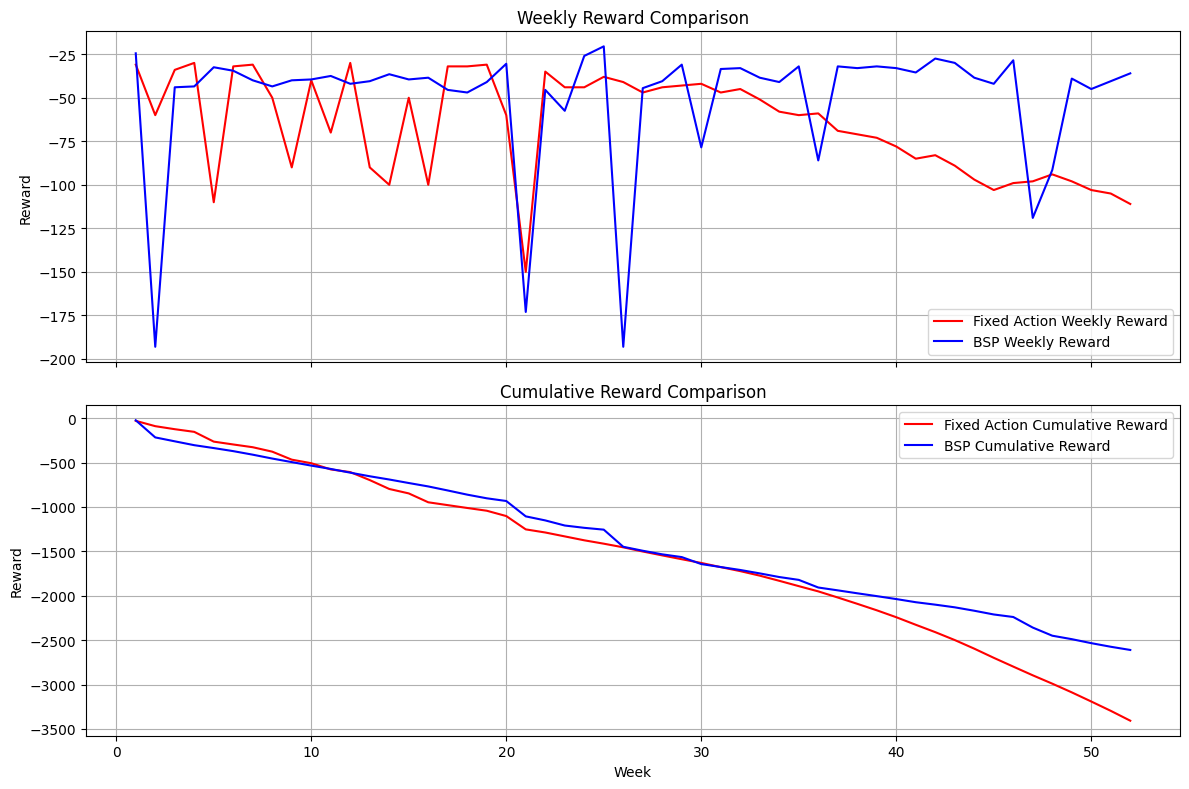

In [ ]:
# Calculate cumulative rewards
cumulative_reward = np.cumsum(reward_history)
cumulative_reward_bsp = np.cumsum(reward_history_bsp)

# Plotting the comparison results
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True) # 2 subplots

# Plot Weekly Reward Comparison
axes[0].plot(week_history[1:], reward_history, label='Fixed Action Weekly Reward', color='red')
axes[0].plot(week_history_bsp[1:], reward_history_bsp, label='BSP Weekly Reward', color='blue')
axes[0].set_ylabel('Reward')
axes[0].set_title('Weekly Reward Comparison')
axes[0].legend()
axes[0].grid(True)

# Plot Cumulative Reward Comparison
axes[1].plot(week_history[1:], cumulative_reward, label='Fixed Action Cumulative Reward', color='red')
axes[1].plot(week_history_bsp[1:], cumulative_reward_bsp, label='BSP Cumulative Reward', color='blue')
axes[1].set_xlabel('Week')
axes[1].set_ylabel('Reward')
axes[1].set_title('Cumulative Reward Comparison')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

### BSP vs. Fixed Product Order Strategy - Key Findings

*   The simulation of the Base Stock Policy resulted in a total reward of -2625.5 over 52 weeks.
*   The simulation of the Fixed Action policy (ordering 20 units per week) resulted in a total reward of -3937.0 over 52 weeks.
*   The Base Stock Policy achieved a higher total reward (less negative) than the Fixed Action policy, indicating better performance in this simulation.

### Next Steps:

*   The Base Stock Policy's ability to adapt order quantities based on expected demand and current inventory likely contributed to its superior performance compared to the fixed order quantity policy.
*   Further analysis below will consider BSP against traditional RL and RL+LLM methods.


# Establishing an RL Baseline

Given the complexity of our inventory optimisation environment, we adopt **Proximal Policy Optimisation (PPO)** over simpler value based methods such as Q-learning or even Deep Q-Networks (DQN) as our RL baseline.

Our state representation includes current inventory level, last week's demand, a seasonality index, stochastic lead time, and incoming stock, a combination of continuous and discrete variables that produces a high-dimensional, partially stochastic state space. While DQN is effective for discrete, low-dimensional problems, it assumes a fixed action set and struggles with environments involving temporal uncertainty, correlated state variables, or continuous decision making needs.

In contrast, PPO, a policy-gradient method, offers greater flexibility and stability through direct policy learning, support for continuous or discrete actions, and robust training via clipped surrogate loss functions. Its ability to generalise across complex states and maintain stable learning under noisy, delayed feedback makes it particularly well-suited to inventory systems where demand varies seasonally and decisions must account for uncertain replenishment dynamics; (http://arxiv.org/pdf/2304.08769) *"Cooperative Multi-Agent Reinforcement Learning for Inventory Management"*.

PPO thus provides a more scalable and policy-aware foundation for developing intelligent, cost-optimised inventory strategies.

In [ ]:
def evaluate_with_logging(model, env, n_episodes=5):
    all_rewards = []
    for ep in range(n_episodes):
        obs = env.reset()
        done, state = False, None
        total_reward = 0.0
        while not done:
            action, _ = model.predict(obs, state=state, deterministic=True)
            obs, reward, done, info = env.step(action)
            total_reward += reward
        print(f"Evaluation - Episode {ep + 1}: Total Reward = {total_reward}")
        all_rewards.append(total_reward)
    return sum(all_rewards) / n_episodes


def optimize_ppo(trial):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    n_steps = trial.suggest_int('n_steps', 64, 2048, step=64)
    gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 1.0)
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.4)
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-6, 1e-1)

    # Create vectorized environment
    env = make_vec_env(RetailInventoryEnv, n_envs=1)

    # Create PPO model with suggested hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        verbose=0
    )

    # Train the model
    model.learn(total_timesteps=10000)

    # Evaluate the model with logging
    mean_reward = evaluate_with_logging(model, model.get_env(), n_episodes=5)

    return mean_reward

In [ ]:
study = optuna.create_study(direction="maximize")
study.optimize(optimize_ppo, n_trials=30)

print("Best hyperparameters found:")
print(study.best_params)

[I 2025-06-27 06:35:52,498] A new study created in memory with name: no-name-9ea6031a-e853-4ba0-9c8c-98fea8f440a9
[I 2025-06-27 06:36:15,317] Trial 0 finished with value: -2493.60009765625 and parameters: {'learning_rate': 0.002489988026694845, 'n_steps': 1472, 'gamma': 0.9168445142526723, 'gae_lambda': 0.9197081890440837, 'clip_range': 0.3040023411781114, 'ent_coef': 0.00032495754609421565}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-2393.]
Evaluation - Episode 2: Total Reward = [-2462.5]
Evaluation - Episode 3: Total Reward = [-2912.5]
Evaluation - Episode 4: Total Reward = [-2327.]
Evaluation - Episode 5: Total Reward = [-2373.]


[I 2025-06-27 06:36:36,207] Trial 1 finished with value: -3263.300048828125 and parameters: {'learning_rate': 0.004920279490601151, 'n_steps': 256, 'gamma': 0.9149853057851542, 'gae_lambda': 0.8051880701965844, 'clip_range': 0.14400416056932785, 'ent_coef': 2.016699767748654e-06}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-3631.]
Evaluation - Episode 2: Total Reward = [-3372.]
Evaluation - Episode 3: Total Reward = [-3202.5]
Evaluation - Episode 4: Total Reward = [-3191.]
Evaluation - Episode 5: Total Reward = [-2920.]


[I 2025-06-27 06:36:56,068] Trial 2 finished with value: -2495.300048828125 and parameters: {'learning_rate': 0.0018631802949787277, 'n_steps': 1152, 'gamma': 0.9253532987205687, 'gae_lambda': 0.9664324613329535, 'clip_range': 0.3425818256098768, 'ent_coef': 0.07991087228429812}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-2588.5]
Evaluation - Episode 2: Total Reward = [-2415.]
Evaluation - Episode 3: Total Reward = [-2523.]
Evaluation - Episode 4: Total Reward = [-2436.5]
Evaluation - Episode 5: Total Reward = [-2513.5]


[I 2025-06-27 06:37:17,005] Trial 3 finished with value: -6909.39990234375 and parameters: {'learning_rate': 1.5747380831700993e-05, 'n_steps': 1024, 'gamma': 0.9488730630221344, 'gae_lambda': 0.9064361899330844, 'clip_range': 0.19212767472344405, 'ent_coef': 5.8010002382808023e-05}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-6412.5]
Evaluation - Episode 2: Total Reward = [-6685.]
Evaluation - Episode 3: Total Reward = [-8462.5]
Evaluation - Episode 4: Total Reward = [-6052.5]
Evaluation - Episode 5: Total Reward = [-6934.5]
Evaluation - Episode 1: Total Reward = [-2707.]
Evaluation - Episode 2: Total Reward = [-2850.]
Evaluation - Episode 3: Total Reward = [-2872.5]
Evaluation - Episode 4: Total Reward = [-2800.]


[I 2025-06-27 06:37:39,296] Trial 4 finished with value: -2807.5 and parameters: {'learning_rate': 3.812041580964502e-05, 'n_steps': 704, 'gamma': 0.9393873894275073, 'gae_lambda': 0.8990531745735317, 'clip_range': 0.12379381988389612, 'ent_coef': 0.031509474556972325}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 5: Total Reward = [-2808.]


[I 2025-06-27 06:38:00,079] Trial 5 finished with value: -3128.699951171875 and parameters: {'learning_rate': 2.8473453691482078e-05, 'n_steps': 128, 'gamma': 0.997361292181803, 'gae_lambda': 0.8142860474045542, 'clip_range': 0.11315699414496641, 'ent_coef': 0.0008806646660402682}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-3153.5]
Evaluation - Episode 2: Total Reward = [-3021.5]
Evaluation - Episode 3: Total Reward = [-3096.5]
Evaluation - Episode 4: Total Reward = [-3101.5]
Evaluation - Episode 5: Total Reward = [-3270.5]


[I 2025-06-27 06:38:23,506] Trial 6 finished with value: -2557.39990234375 and parameters: {'learning_rate': 0.003163161249280812, 'n_steps': 1664, 'gamma': 0.9114487964140863, 'gae_lambda': 0.8878993214436297, 'clip_range': 0.12909893127886365, 'ent_coef': 2.417017098997137e-05}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-2662.]
Evaluation - Episode 2: Total Reward = [-2659.]
Evaluation - Episode 3: Total Reward = [-2551.5]
Evaluation - Episode 4: Total Reward = [-2461.5]
Evaluation - Episode 5: Total Reward = [-2453.]


[I 2025-06-27 06:38:43,801] Trial 7 finished with value: -2519.300048828125 and parameters: {'learning_rate': 0.0014049903866998417, 'n_steps': 192, 'gamma': 0.9217113100523029, 'gae_lambda': 0.9154348534454306, 'clip_range': 0.20686865474849098, 'ent_coef': 2.8700124580289447e-05}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-2748.]
Evaluation - Episode 2: Total Reward = [-2776.]
Evaluation - Episode 3: Total Reward = [-2364.5]
Evaluation - Episode 4: Total Reward = [-2213.5]
Evaluation - Episode 5: Total Reward = [-2494.5]


[I 2025-06-27 06:39:04,605] Trial 8 finished with value: -2697.39990234375 and parameters: {'learning_rate': 0.002046400859524183, 'n_steps': 1536, 'gamma': 0.9361122258918956, 'gae_lambda': 0.9069266809673222, 'clip_range': 0.10805678611721521, 'ent_coef': 7.147135422295477e-06}. Best is trial 0 with value: -2493.60009765625.


Evaluation - Episode 1: Total Reward = [-2710.5]
Evaluation - Episode 2: Total Reward = [-2665.5]
Evaluation - Episode 3: Total Reward = [-2753.]
Evaluation - Episode 4: Total Reward = [-2621.5]
Evaluation - Episode 5: Total Reward = [-2736.5]


[I 2025-06-27 06:39:26,562] Trial 9 finished with value: -2475.800048828125 and parameters: {'learning_rate': 0.0036554908304894753, 'n_steps': 576, 'gamma': 0.9102526308876244, 'gae_lambda': 0.9376237794152298, 'clip_range': 0.14309678185471925, 'ent_coef': 0.0059274156214695365}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2442.5]
Evaluation - Episode 2: Total Reward = [-2469.5]
Evaluation - Episode 3: Total Reward = [-2513.]
Evaluation - Episode 4: Total Reward = [-2516.]
Evaluation - Episode 5: Total Reward = [-2438.]


[I 2025-06-27 06:39:47,352] Trial 10 finished with value: -3151.0 and parameters: {'learning_rate': 0.00028859713176232607, 'n_steps': 640, 'gamma': 0.9812117015844833, 'gae_lambda': 0.9960692592496512, 'clip_range': 0.2554691611364878, 'ent_coef': 0.0055482536275332575}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-3227.5]
Evaluation - Episode 2: Total Reward = [-2998.5]
Evaluation - Episode 3: Total Reward = [-2654.]
Evaluation - Episode 4: Total Reward = [-3654.]
Evaluation - Episode 5: Total Reward = [-3221.]


[I 2025-06-27 06:40:08,935] Trial 11 finished with value: -3567.60009765625 and parameters: {'learning_rate': 0.009804148119307098, 'n_steps': 1856, 'gamma': 0.9006228293937881, 'gae_lambda': 0.9495189915886545, 'clip_range': 0.3150617531586258, 'ent_coef': 0.0007545195061351382}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-3462.]
Evaluation - Episode 2: Total Reward = [-3365.]
Evaluation - Episode 3: Total Reward = [-3632.]
Evaluation - Episode 4: Total Reward = [-3893.]
Evaluation - Episode 5: Total Reward = [-3486.]


[I 2025-06-27 06:40:30,546] Trial 12 finished with value: -2562.10009765625 and parameters: {'learning_rate': 0.0005826269668281366, 'n_steps': 1344, 'gamma': 0.901165002402716, 'gae_lambda': 0.851663013196247, 'clip_range': 0.39607558200305704, 'ent_coef': 0.0046632503964716505}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2589.5]
Evaluation - Episode 2: Total Reward = [-2365.]
Evaluation - Episode 3: Total Reward = [-2763.5]
Evaluation - Episode 4: Total Reward = [-2695.5]
Evaluation - Episode 5: Total Reward = [-2397.]


[I 2025-06-27 06:40:50,627] Trial 13 finished with value: -2932.10009765625 and parameters: {'learning_rate': 0.0002918927266718913, 'n_steps': 640, 'gamma': 0.9696297207627904, 'gae_lambda': 0.9425272358781678, 'clip_range': 0.28501733692168907, 'ent_coef': 0.00017475373173552337}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2939.5]
Evaluation - Episode 2: Total Reward = [-3028.5]
Evaluation - Episode 3: Total Reward = [-3197.5]
Evaluation - Episode 4: Total Reward = [-2895.5]
Evaluation - Episode 5: Total Reward = [-2599.5]


[I 2025-06-27 06:41:10,633] Trial 14 finished with value: -2777.300048828125 and parameters: {'learning_rate': 0.0007631952398755717, 'n_steps': 2048, 'gamma': 0.9616767930463692, 'gae_lambda': 0.8731862275869535, 'clip_range': 0.18682965178578506, 'ent_coef': 0.00456915708852232}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2814.]
Evaluation - Episode 2: Total Reward = [-2833.]
Evaluation - Episode 3: Total Reward = [-2715.]
Evaluation - Episode 4: Total Reward = [-2676.5]
Evaluation - Episode 5: Total Reward = [-2848.]


[I 2025-06-27 06:41:31,741] Trial 15 finished with value: -3260.5 and parameters: {'learning_rate': 0.00011197369454353871, 'n_steps': 960, 'gamma': 0.9314870135035785, 'gae_lambda': 0.934679006597531, 'clip_range': 0.23041193670010685, 'ent_coef': 0.000320987828316899}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-3229.5]
Evaluation - Episode 2: Total Reward = [-3453.]
Evaluation - Episode 3: Total Reward = [-2529.]
Evaluation - Episode 4: Total Reward = [-3554.]
Evaluation - Episode 5: Total Reward = [-3537.]


[I 2025-06-27 06:41:51,643] Trial 16 finished with value: -7369.39990234375 and parameters: {'learning_rate': 0.007614587473516742, 'n_steps': 384, 'gamma': 0.9117247179263811, 'gae_lambda': 0.9746746786582561, 'clip_range': 0.3271909943232201, 'ent_coef': 0.015231247396960365}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-6789.]
Evaluation - Episode 2: Total Reward = [-7588.]
Evaluation - Episode 3: Total Reward = [-7173.]
Evaluation - Episode 4: Total Reward = [-7487.]
Evaluation - Episode 5: Total Reward = [-7810.]


[I 2025-06-27 06:42:12,999] Trial 17 finished with value: -2893.5 and parameters: {'learning_rate': 0.0008457125139340298, 'n_steps': 1344, 'gamma': 0.9500822706524119, 'gae_lambda': 0.9274024557767969, 'clip_range': 0.3636139329693085, 'ent_coef': 0.0015693707745131316}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-3025.]
Evaluation - Episode 2: Total Reward = [-2714.5]
Evaluation - Episode 3: Total Reward = [-2767.5]
Evaluation - Episode 4: Total Reward = [-2987.5]
Evaluation - Episode 5: Total Reward = [-2973.]


[I 2025-06-27 06:42:33,573] Trial 18 finished with value: -2514.300048828125 and parameters: {'learning_rate': 0.0035275476159385365, 'n_steps': 832, 'gamma': 0.9200345418957778, 'gae_lambda': 0.8723076141727617, 'clip_range': 0.289030925075744, 'ent_coef': 0.0001401618660762374}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2609.5]
Evaluation - Episode 2: Total Reward = [-2469.]
Evaluation - Episode 3: Total Reward = [-2647.5]
Evaluation - Episode 4: Total Reward = [-2343.]
Evaluation - Episode 5: Total Reward = [-2502.5]


[I 2025-06-27 06:42:53,665] Trial 19 finished with value: -2805.60009765625 and parameters: {'learning_rate': 9.989056462768145e-05, 'n_steps': 1280, 'gamma': 0.9443397023214081, 'gae_lambda': 0.9629687811468384, 'clip_range': 0.2547085330440986, 'ent_coef': 0.0021232393278954914}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2839.5]
Evaluation - Episode 2: Total Reward = [-3034.5]
Evaluation - Episode 3: Total Reward = [-2533.]
Evaluation - Episode 4: Total Reward = [-2806.5]
Evaluation - Episode 5: Total Reward = [-2814.5]


[I 2025-06-27 06:43:14,823] Trial 20 finished with value: -2806.300048828125 and parameters: {'learning_rate': 0.00013672146754123348, 'n_steps': 448, 'gamma': 0.9083162287410042, 'gae_lambda': 0.9879938105464623, 'clip_range': 0.15790884386210025, 'ent_coef': 0.01710859977346174}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2785.]
Evaluation - Episode 2: Total Reward = [-2867.]
Evaluation - Episode 3: Total Reward = [-2715.]
Evaluation - Episode 4: Total Reward = [-2846.5]
Evaluation - Episode 5: Total Reward = [-2818.]


[I 2025-06-27 06:43:34,527] Trial 21 finished with value: -2514.89990234375 and parameters: {'learning_rate': 0.001834158818376232, 'n_steps': 1152, 'gamma': 0.9286812414007404, 'gae_lambda': 0.9611038596508904, 'clip_range': 0.3477505877116178, 'ent_coef': 0.0845358310231557}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2729.5]
Evaluation - Episode 2: Total Reward = [-2368.5]
Evaluation - Episode 3: Total Reward = [-2615.5]
Evaluation - Episode 4: Total Reward = [-2302.]
Evaluation - Episode 5: Total Reward = [-2559.]


[I 2025-06-27 06:43:56,317] Trial 22 finished with value: -2576.699951171875 and parameters: {'learning_rate': 0.0013112459267276887, 'n_steps': 1536, 'gamma': 0.9251650880303077, 'gae_lambda': 0.9251400733807825, 'clip_range': 0.2956694773717894, 'ent_coef': 0.0779807279170105}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2480.5]
Evaluation - Episode 2: Total Reward = [-2704.]
Evaluation - Episode 3: Total Reward = [-2369.5]
Evaluation - Episode 4: Total Reward = [-2559.5]
Evaluation - Episode 5: Total Reward = [-2770.]


[I 2025-06-27 06:44:17,716] Trial 23 finished with value: -2734.199951171875 and parameters: {'learning_rate': 0.004456561157607513, 'n_steps': 1216, 'gamma': 0.918517751328556, 'gae_lambda': 0.9756050933751926, 'clip_range': 0.3787074457809968, 'ent_coef': 0.02917255293568647}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2818.5]
Evaluation - Episode 2: Total Reward = [-2606.5]
Evaluation - Episode 3: Total Reward = [-2752.]
Evaluation - Episode 4: Total Reward = [-2757.5]
Evaluation - Episode 5: Total Reward = [-2736.5]


[I 2025-06-27 06:44:38,976] Trial 24 finished with value: -2500.10009765625 and parameters: {'learning_rate': 0.0022233403167600764, 'n_steps': 896, 'gamma': 0.9041384888724162, 'gae_lambda': 0.9476476074852672, 'clip_range': 0.34012972703120997, 'ent_coef': 0.014137096143645016}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2246.5]
Evaluation - Episode 2: Total Reward = [-2454.5]
Evaluation - Episode 3: Total Reward = [-2679.5]
Evaluation - Episode 4: Total Reward = [-2782.]
Evaluation - Episode 5: Total Reward = [-2338.]


[I 2025-06-27 06:45:01,596] Trial 25 finished with value: -3206.5 and parameters: {'learning_rate': 0.0005026495103547826, 'n_steps': 1600, 'gamma': 0.9331672262224661, 'gae_lambda': 0.9628452031342476, 'clip_range': 0.27152517712807267, 'ent_coef': 0.0005215392654865523}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-3204.5]
Evaluation - Episode 2: Total Reward = [-3197.5]
Evaluation - Episode 3: Total Reward = [-3108.]
Evaluation - Episode 4: Total Reward = [-3268.]
Evaluation - Episode 5: Total Reward = [-3254.5]


[I 2025-06-27 06:45:22,897] Trial 26 finished with value: -5607.39990234375 and parameters: {'learning_rate': 0.006023125402987788, 'n_steps': 1792, 'gamma': 0.925979254038698, 'gae_lambda': 0.9227837217013304, 'clip_range': 0.3171213407563306, 'ent_coef': 0.09674465442720943}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-5501.]
Evaluation - Episode 2: Total Reward = [-5570.]
Evaluation - Episode 3: Total Reward = [-5431.]
Evaluation - Episode 4: Total Reward = [-5924.]
Evaluation - Episode 5: Total Reward = [-5611.]


[I 2025-06-27 06:45:44,564] Trial 27 finished with value: -2903.800048828125 and parameters: {'learning_rate': 0.0011447953803163412, 'n_steps': 1408, 'gamma': 0.9577690282610347, 'gae_lambda': 0.9787915637498349, 'clip_range': 0.22755850533558603, 'ent_coef': 0.002359628589320147}. Best is trial 9 with value: -2475.800048828125.


Evaluation - Episode 1: Total Reward = [-2786.]
Evaluation - Episode 2: Total Reward = [-2898.]
Evaluation - Episode 3: Total Reward = [-3017.]
Evaluation - Episode 4: Total Reward = [-2885.5]
Evaluation - Episode 5: Total Reward = [-2932.5]


[I 2025-06-27 06:46:06,658] Trial 28 finished with value: -2406.89990234375 and parameters: {'learning_rate': 0.0029074427338969975, 'n_steps': 1088, 'gamma': 0.907695198531491, 'gae_lambda': 0.8891367834131156, 'clip_range': 0.36452553812925237, 'ent_coef': 0.008460073046970057}. Best is trial 28 with value: -2406.89990234375.


Evaluation - Episode 1: Total Reward = [-2477.5]
Evaluation - Episode 2: Total Reward = [-2460.]
Evaluation - Episode 3: Total Reward = [-2227.5]
Evaluation - Episode 4: Total Reward = [-2477.5]
Evaluation - Episode 5: Total Reward = [-2392.]


[I 2025-06-27 06:46:28,306] Trial 29 finished with value: -3116.199951171875 and parameters: {'learning_rate': 0.005329760740717159, 'n_steps': 448, 'gamma': 0.9155293276075355, 'gae_lambda': 0.843232403519954, 'clip_range': 0.1664969894589683, 'ent_coef': 1.4028638990853165e-06}. Best is trial 28 with value: -2406.89990234375.


Evaluation - Episode 1: Total Reward = [-3437.5]
Evaluation - Episode 2: Total Reward = [-3136.5]
Evaluation - Episode 3: Total Reward = [-3248.5]
Evaluation - Episode 4: Total Reward = [-3106.5]
Evaluation - Episode 5: Total Reward = [-2652.]
Best hyperparameters found:
{'learning_rate': 0.0029074427338969975, 'n_steps': 1088, 'gamma': 0.907695198531491, 'gae_lambda': 0.8891367834131156, 'clip_range': 0.36452553812925237, 'ent_coef': 0.008460073046970057}


In [ ]:
best_params = study.best_params

with open("best_ppo_params.json", "w") as f:
    json.dump(best_params, f, indent=4)

In [ ]:
# Load best parameters
with open("best_ppo_params.json", "r") as f:
    best_params = json.load(f)

# Recreate the environment
env = make_vec_env(RetailInventoryEnv, n_envs=1)

# Create PPO model with best parameters
model = PPO(
    "MlpPolicy",
    env,
    learning_rate=best_params['learning_rate'],
    n_steps=2048,
    gamma=best_params['gamma'],
    gae_lambda=best_params['gae_lambda'],
    clip_range=best_params['clip_range'],
    ent_coef=best_params['ent_coef'],
    verbose=1
)

# Train or continue training
model.learn(total_timesteps=10000)

Using cpu device
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 52        |
|    ep_rew_mean     | -4.38e+03 |
| time/              |           |
|    fps             | 646       |
|    iterations      | 1         |
|    time_elapsed    | 3         |
|    total_timesteps | 2048      |
----------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 52          |
|    ep_rew_mean          | -4.19e+03   |
| time/                   |             |
|    fps                  | 601         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.054300047 |
|    clip_fraction        | 0.194       |
|    clip_range           | 0.365       |
|    entropy_loss         | -3.55       |
|    explained_variance   | 0.000474    |
|  

In [ ]:
# Set seed
set_seed = 42
# Evaluate the trained PPO model on a new simulation with a fixed seed
env_ppo_eval = make_vec_env(RetailInventoryEnv, n_envs=1)
env_ppo_eval.seed(set_seed) # Set the seed for the vectorized environment
obs_ppo_eval = env_ppo_eval.reset() # Reset without the seed argument


inventory_history_ppo_eval = [obs_ppo_eval[0][0]]
demand_history_ppo_eval = [obs_ppo_eval[0][1]]
reward_history_ppo_eval = []
week_history_ppo_eval = [0]
action_history_ppo_eval = []

total_reward_ppo_eval = 0.0
done_ppo_eval = False
state_ppo_eval = None

for i in range(52):
    action_ppo_eval, state_ppo_eval = model.predict(obs_ppo_eval, state=state_ppo_eval, deterministic=True)
    obs_ppo_eval, reward_ppo_eval, done_ppo_eval, info_ppo_eval = env_ppo_eval.step(action_ppo_eval) # Unpack 4 values


    inventory_history_ppo_eval.append(obs_ppo_eval[0][0])
    demand_history_ppo_eval.append(obs_ppo_eval[0][1])
    reward_history_ppo_eval.append(reward_ppo_eval[0])
    week_history_ppo_eval.append(i + 1)
    action_history_ppo_eval.append(action_ppo_eval[0])

    total_reward_ppo_eval += reward_ppo_eval[0]

    if done_ppo_eval:
        print("PPO Evaluation Episode finished after 52 weeks.")
        break

print("Total Reward (PPO Evaluation):", total_reward_ppo_eval)


# Evaluate the BSP model on a new simulation with the same fixed seed
env_bsp_eval = RetailInventoryEnv()
obs_bsp_eval, info_bsp_eval = env_bsp_eval.reset(seed=set_seed)

inventory_history_bsp_eval = [obs_bsp_eval[0]]
demand_history_bsp_eval = [obs_bsp_eval[1]]
reward_history_bsp_eval = []
week_history_bsp_eval = [0]
action_history_bsp_eval = []

critical_ratio = 10 / (10 + 1) # 0.909

total_reward_bsp_eval = 0
done_bsp_eval = False

for i in range(52):
    expected_demand = 20 + 5 * np.sin(2 * np.pi * (i + 1) / 52)
    base_stock_level = poisson.ppf(critical_ratio, expected_demand)
    current_inventory = obs_bsp_eval[0]
    action_bsp_eval = max(0, int(base_stock_level.item() - current_inventory.item()))

    obs_bsp_eval, reward_bsp_eval, done_bsp_eval, truncated_bsp_eval, info_bsp_eval = env_bsp_eval.step(action_bsp_eval)

    inventory_history_bsp_eval.append(obs_bsp_eval[0])
    demand_history_bsp_eval.append(obs_bsp_eval[1])
    reward_history_bsp_eval.append(reward_bsp_eval)
    week_history_bsp_eval.append(i + 1)
    action_history_bsp_eval.append(action_bsp_eval)

    total_reward_bsp_eval += reward_bsp_eval

    if done_bsp_eval:
        print("BSP Evaluation Episode finished after 52 weeks.")
        break

print("Total Reward (BSP Evaluation):", total_reward_bsp_eval)

PPO Evaluation Episode finished after 52 weeks.
Total Reward (PPO Evaluation): -2279.5
BSP Evaluation Episode finished after 52 weeks.
Total Reward (BSP Evaluation): -2610.5


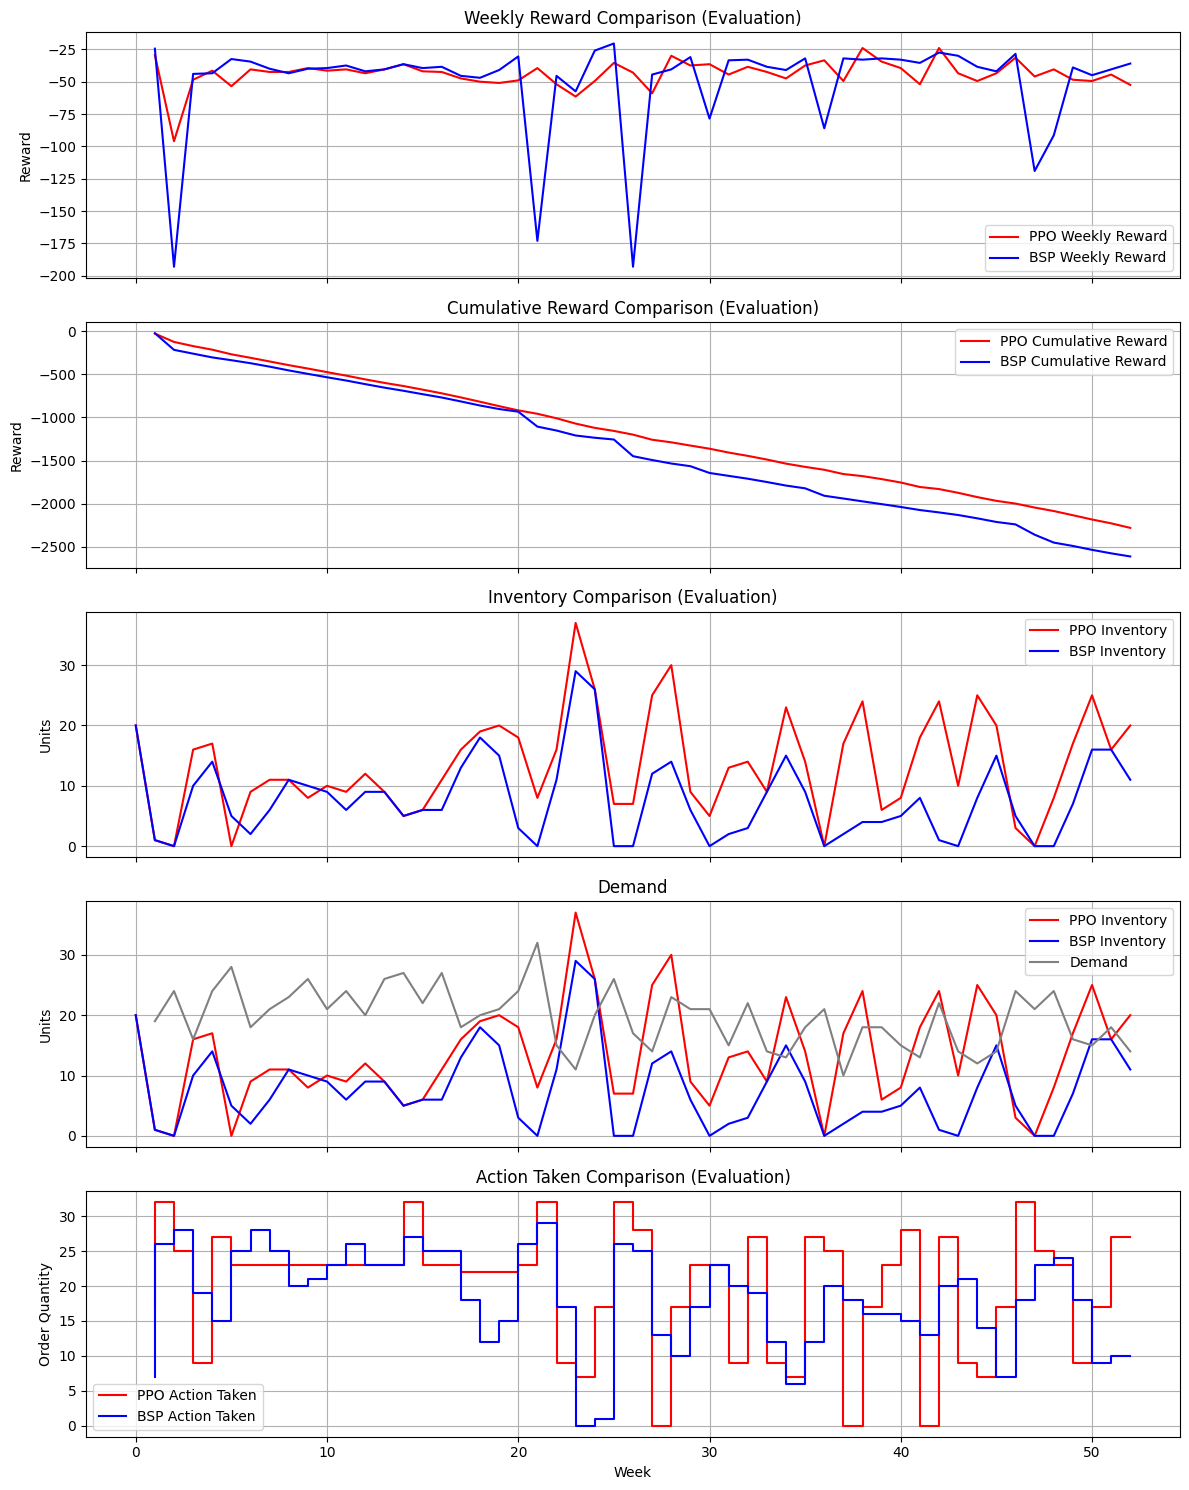

In [ ]:
# Calculate cumulative rewards
cumulative_reward_ppo_eval = np.cumsum(reward_history_ppo_eval)
cumulative_reward_bsp_eval = np.cumsum(reward_history_bsp_eval)

# Plotting the comparison results
fig, axes = plt.subplots(5, 1, figsize=(12, 15), sharex=True) # 5 subplots for comparison

# Plot Weekly Reward Comparison
axes[0].plot(week_history_ppo_eval[1:], reward_history_ppo_eval, label='PPO Weekly Reward', color='red')
axes[0].plot(week_history_bsp_eval[1:], reward_history_bsp_eval, label='BSP Weekly Reward', color='blue')
axes[0].set_ylabel('Reward')
axes[0].set_title('Weekly Reward Comparison (Evaluation)')
axes[0].legend()
axes[0].grid(True)

# Plot Cumulative Reward Comparison
axes[1].plot(week_history_ppo_eval[1:], cumulative_reward_ppo_eval, label='PPO Cumulative Reward', color='red')
axes[1].plot(week_history_bsp_eval[1:], cumulative_reward_bsp_eval, label='BSP Cumulative Reward', color='blue')
axes[1].set_ylabel('Reward')
axes[1].set_title('Cumulative Reward Comparison (Evaluation)')
axes[1].legend()
axes[1].grid(True)

# Plot Inventory Comparison
axes[2].plot(week_history_ppo_eval, inventory_history_ppo_eval, label='PPO Inventory', color='red')
axes[2].plot(week_history_bsp_eval, inventory_history_bsp_eval, label='BSP Inventory', color='blue')
axes[2].set_ylabel('Units')
axes[2].set_title('Inventory Comparison (Evaluation)')
axes[2].legend()
axes[2].grid(True)

# Plot Demand Comparison
# axes[3].plot(week_history_ppo_eval[1:], demand_history_ppo_eval[1:], label='PPO Demand', color='grey')
axes[3].plot(week_history_ppo_eval, inventory_history_ppo_eval, label='PPO Inventory', color='red')
axes[3].plot(week_history_bsp_eval, inventory_history_bsp_eval, label='BSP Inventory', color='blue')
axes[3].plot(week_history_bsp_eval[1:], demand_history_bsp_eval[1:], label='Demand', color='grey')
axes[3].set_ylabel('Units')
axes[3].set_title('Demand')
axes[3].legend()
axes[3].grid(True)

# Plot Actions Taken Comparison
axes[4].step(week_history_ppo_eval[1:], action_history_ppo_eval, label='PPO Action Taken', color='red', where='pre')
axes[4].step(week_history_bsp_eval[1:], action_history_bsp_eval, label='BSP Action Taken', color='blue', where='pre')
axes[4].set_xlabel('Week')
axes[4].set_ylabel('Order Quantity')
axes[4].set_title('Action Taken Comparison (Evaluation)')
axes[4].legend()
axes[4].grid(True)

plt.tight_layout()
plt.show()

---
# Summary Analysis: PPO vs Base Stock Policy (BSP)

1. Reward Performance
  - PPO demonstrates more stable reward fluctuations with fewer drastic penalties compared to BSP. BSP exhibits multiple extreme negative spikes indicating greater sensitivity to poor inventory decisions under uncertainty.
  - Cumulatively PPO achieves -2279.5 and outperforming BSP which instead achieves -2610.5 over 52 weeks, suggesting superior overall policy quality in managing costs (holding, stockouts, and ordering).

2. Policy Behaviour
  - PPO's variable ordering reflects an adaptive strategy reacting to stochastic demand and seasonality.

---

# Next Steps - PPO + LLMs

We propose implementing Policy Shaping via an LLM in conjunction with PPO. This approach draws inspiration from "A Decision-Language Model (DLM) for Dynamic Restless Multi-Armed Bandit Tasks in Public Health" (arXiv:2402.14807). In this work, the authors successfully utilise LLMs as automated planners capable of:

1. Interpreting natural language prompts that encode human policy preferences,
2. Translating these prompts into formal reward functions (expressed as executable code) tailored to multi-agent Restless Multi-Armed Bandit (RMAB) environments, and
3. Iteratively refining these functions through feedback from simulation, enabling continuous improvement of policy alignment.

For our use case we will adjust our approach such that we use the LLMs as domain aware agents that:

1. Interpret the environment and objectives to learn what is costly and what tradeoffs exist e.g. early ordering vs cost of overstock.
2. Propose Reward Functions as Code, where tailored reward functions empahsising control principles such as smooth inventory transitions, avoiding frequent reording and/or maintaining stock during peak demand seasons are preemptively shaped by LLM domain experts.
3. Iterative evaluation and adjustment such that after each evaluation, feedback is looped into the LLM.

This framework offers a structured way to embed human-expert intentions and domain expertise directly into the policy learning loop, rather than retrofitting decisions at the output stage. By integrating the LLM earlier in the reinforcement learning pipeline, as a semantic interface for reward engineering, this method enhances both the interpretability and adaptability of the learning agent.

In doing so, Policy Shaping via LLMs fundamentally restructures the reward landscape that guides learning, allowing the agent to align more closely with nuanced human-expert objectives from the outset.

---

# PPO + LLM Policy Shaping Approach

We adopt a three-phase experimental pipeline designed to systematically **discover, refine, and evaluate reward-shaping functions** for policy optimisation, while ensuring that **evaluation prioritises real-world cost metrics** such as base cost.

---

### **Phase 1: Reward Function Search via Language Model**

This phase uses a language model (LLM) to generate a diverse set of candidate **reward-shaping code snippets** and filters them down based on their execution validity and early performance.

**Procedure:**

1. **Initialisation:**

   * Load the previously identified best PPO hyperparameters from `best_ppo_params.json`.
   * Prepare a baseline performance benchmark for comparison.

2. **Reward Function Generation & Verification:**

   * For each shaping strategy and approach:

     * Prompt the LLM to generate a candidate `shaping_penalty` code snippet.
     * Validate the generated code using automated execution checks.
     * Train a PPO agent with the fixed baseline hyperparameters and the candidate shaping function.
     * Evaluate over multiple episodes, recording **mean total reward, mean base cost, and episode traces**.
     * Feed back performance results to the LLM to iteratively refine code.

3. **Selection Criteria:**

   * Rank all candidate reward functions by **mean base cost** and **statistical improvement** over the Base PPO baseline.
   * Retain the **top shaping functions** that show evidence of both operational efficiency (lower base cost) and stable training.

---

### **Phase 2: Hyperparameter Optimisation for Top Reward Functions**

This phase fine-tunes **PPO hyperparameters** for each of the best reward-shaping functions from Phase 1.

**Procedure:**

1. **Setup for Each Reward Function:**

   * For each top shaping penalty code, initialise a dedicated Optuna study.

2. **Optimisation Objective:**

   * Define an objective function that:

     * Builds the environment with the fixed shaping code.
     * Trains PPO with trial-suggested hyperparameters.
     * Evaluates the agent over multiple episodes, reporting **mean total reward** while tracking **mean base cost**.

3. **Study Execution:**

   * Run Optuna for a fixed number of trials (e.g., 10 per shaping code).
   * Store the best hyperparameters, the resulting base cost, and total reward for each reward function.

---

### **Phase 3: Cross-Evaluation and Final Policy Selection**

This phase identifies the most robust and business-relevant policy by **evaluating all promising policies under consistent conditions** and comparing them with strong baselines.

**Procedure:**

1. **Cross Evaluation Setup:**

   * Evaluate each (reward function + best hyperparameters from Phase 2) pair under a fixed seed across **20 evaluation episodes**, tracking **total rewards and base costs**.
   * Repeat evaluations using both:

     * Phase 2 optimised hyperparameters, and
     * Initial baseline hyperparameters

2. **Baseline Comparison:**

   * Compare all LLM-shaped PPO policies against:

     * **Base PPO Baseline** (trained with default reward function, best PPO HPs).
     * **Fixed Action Policy** (always order 20 units).
     * **Base Stock Policy (BSP)**, a classical inventory control approach.

3. **Final Policy Selection:**

   * Rank all policies by **mean base cost** (lower is better).
   * Use **total reward variance** and stability as secondary indicators.
   * Select the final policy that demonstrates **statistically significant improvement in base cost** while maintaining stable learning dynamics.

---

### **Summary**

> Across all phases, the pipeline tracks **mean total reward** (for RL learning dynamics) and **mean base cost** (for business relevance). The final policy is chosen to **minimise operational costs**, with reward metrics serving as diagnostics of shaping quality and stability. This ensures the selected policy is not only technically sound but also practically valuable.

---


## OpenAI API Key Setup

In [ ]:
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

# Verify the API key is set (optional)
if os.getenv("OPENAI_API_KEY") is not None:
    print("OpenAI API key is set.")
else:
    print("OpenAI API key is not set. Please set it as an environment variable.")


OpenAI API key is set.


## Integrating the llm-based reward function into the environment

Modify the `RetailInventoryEnv` class to accept and use the dynamically generated reward function. It has also been designed with a clear, modular separation between the core operational cost structure and any additional behavioral shaping mechanisms. The default cost logic (`base_cost`) strictly reflects true operational costs (inventory holding, stockouts, order costs), maintaining a reliable baseline for evaluating policy performance. By allowing reward shaping logic (e.g., non-linear penalties, behavioral incentives) to be injected via dynamic code, the framework enables safe experimentation with novel reward structures without compromising the integrity or interpretability of the underlying cost metrics.

**Key reward setup considerations:**

1. **Separation of Cost and Reward:**
   The environment distinguishes between the *base\_cost* (the operational cost you ultimately care about) and the *shaping\_penalty* (any extra component designed to encourage or discourage specific behaviors). The total reward is simply the negative sum of both, ensuring RL agents remain sensitive to the new shaped signals while keeping the business-relevant cost metric intact for apples-to-apples evaluation.

2. **Integrity of Evaluation:**
   During training, agents optimize for the total reward, which incorporates any experimental shaping. But when comparing different policies or reward function variants, you can always report and benchmark them on *base\_cost*—the original, unshaped metric—ensuring that improvements reflect actual business value and not just artifacts of a changed reward signal.

3. **Modularity and Safety:**
   The ability to dynamically provide shaping code, combined with rigorous checking of required arguments and clear info logging, means new reward ideas can be layered and tested without rewriting or risking the core environment. If shaping code fails or is omitted, the environment defaults to zero shaping, so the base logic is never compromised.

---





In [ ]:
REQUIRED_ARGUMENTS = [
    "current_inventory",
    "lost_sales",
    "action",
    "holding_cost_per_unit",
    "stockout_cost_per_unit",
    "order_cost_fixed",
    "order_cost_per_unit"
]

def is_reward_function_complete(code: str) -> bool:
    code_lower = code.lower()
    return all(arg.lower() in code_lower for arg in REQUIRED_ARGUMENTS)

import inspect

def has_extra_arguments(code: str) -> bool:
    try:
        local_scope = {}
        exec(code, globals(), local_scope)
        if 'calculate_shaping_penalty' in local_scope and inspect.isfunction(local_scope['calculate_shaping_penalty']):
            func = local_scope['calculate_shaping_penalty']
            func_args = list(inspect.signature(func).parameters.keys())

            # Check if all required arguments are present AND if there are any extra arguments
            return not all(arg in func_args for arg in REQUIRED_ARGS) or any(arg not in REQUIRED_ARGS for arg in func_args)
        return True # If function not found or not a function, consider it invalid
    except Exception as e:
        print(f"Error inspecting function code: {e}")
        return True # Assume invalid if inspection fails


class RetailInventoryEnv(gym.Env):
  def __init__(self, shaping_penalty_code=None): # Accept shaping_penalty_code
    super().__init__()
    self.max_inventory = 50
    self.max_order = 35
    self.lead_time = 2

    self.action_space = spaces.Discrete(self.max_order + 1)
    self.observation_space = spaces.Box(low=0, high=self.max_inventory, shape=(4,), dtype=np.float32)

    self.holding_cost = 1
    self.stockout_cost = 10
    self.order_cost_fixed = 20
    self.order_cost_per_unit = 0.5
    self.shaping_penalty_error_reported = False

    self.shaping_penalty_code = shaping_penalty_code # Store the shaping penalty code

    self.reset()

  def reset(self, seed=None, options=None):
    super().reset(seed=seed) # Pass the seed to the superclass reset
    if seed is not None:
        np.random.seed(seed)  # Also sets global NumPy seed for reproducibility

    self.inventory = 20
    self.backlog = 0
    self.incoming_orders = []
    self.week = 0
    self.last_demand = 0
    self.seasonality_index = np.sin(2 * np.pi * self.week / 52) # Initialize seasonality_index
    self.previous_action = None # Reset previous_action
    info = {} # Add info dictionary
    return self._get_obs(), info # Return obs and info

  def _get_obs(self):
    return np.array([
        self.inventory,
        self.last_demand,
        self.seasonality_index, # Use the self attribute
        sum([qty for _, qty in self.incoming_orders]) if self.incoming_orders else 0.0
    ], dtype=np.float32)


  def step(self, action):
    self.week += 1

    if action > 0:
      # Lead time is 1 or 2 weeks randomly
      current_lead_time = np.random.choice([1, 2])
      self.incoming_orders.append((current_lead_time, action))

    # Decrement lead times and process arrivals
    new_incoming_orders = []
    arrivals = 0
    for t, q in self.incoming_orders:
        if t - 1 == 0:
            arrivals += q
        elif t - 1 > 0:
            new_incoming_orders.append((t - 1, q))
    self.incoming_orders = new_incoming_orders

    self.inventory += arrivals

    # Handle demand
    base_demand = 20 + 5 * np.sin(2 * np.pi * self.week / 52)
    self.last_demand = int(np.random.poisson(base_demand))

    sold = min(self.inventory, self.last_demand)
    lost_sales = max(0, self.last_demand - self.inventory)
    self.inventory -= sold

    # Update seasonality index
    self.seasonality_index = np.sin(2 * np.pi * self.week / 52)


    # Calculate base cost
    base_cost = self.holding_cost * self.inventory + \
                self.stockout_cost * lost_sales + \
                self.order_cost_fixed * (action > 0) + \
                self.order_cost_per_unit * action

    # Calculate shaping penalty using the dynamically provided code
    shaping_penalty_calculated = 0.0  # Default to 0 if no code is provided or execution fails
    if self.shaping_penalty_code:
        try:
            # Execute the shaping penalty code within the current scope
            # The code is expected to define a variable named 'shaping_penalty'
            local_scope = {'current_inventory': self.inventory,
                           'lost_sales': lost_sales,
                           'action': action,
                           'base_cost': base_cost,
                           'self': self} # Provide access to environment instance
            exec(self.shaping_penalty_code, globals(), local_scope)
            shaping_penalty_calculated = local_scope.get('shaping_penalty', -9999) # Get the calculated shaping penalty
        except Exception as e:
            shaping_penalty_calculated = -9999
            if not self.shaping_penalty_error_reported:
              print(f"Error executing shaping penalty code: {e}")
              self.shaping_penalty_error_reported = True
            # Keep shaping_penalty as 0.0 in case of error

    # Calculate total reward (negative of base_cost + shaping_penalty)
    # Ensure shaping_penalty is treated as a negative value
    shaping_penalty_calculated = abs(shaping_penalty_calculated)
    total_cost = base_cost + shaping_penalty_calculated
    reward = -total_cost


    done = self.week >= 52
    truncated = False # Add truncated

    # Include base_cost in the info dictionary for evaluation
    info = {'base_cost': base_cost}

    return self._get_obs(), reward, done, truncated, info # Return 5 values

  def render(self, mode='human'):
    print(f"Week: {self.week}, Inventory: {self.inventory}, Last Demand: {self.last_demand}")

## Implement phase 1: reward function search

Load the best PPO hyperparameters, iterate through reward function generation using the LLM and evaluate the resulting policy, then identify and store the top performing reward functions.


In [ ]:
environment_description = """
    - State (observation/vector):
        - Index 0: current inventory level (float)
        - Index 1: last week's demand (float)
        - Index 2: seasonality index (float, ranges between -1 and 1, derived from sin(week_of_year / 52 * 2pi))
        - Index 3: incoming stock (float, total quantity from pending orders)
    - Actions:
        - Ordering a discrete quantity of stock (integer). The action space is Discrete(max_order + 1), where max_order is 35.
    - Costs:
        - Holding cost: $1 per unit per week for current inventory.
        - Stockout penalty: $10 per unit of lost sales.
        - Ordering cost: $20 fixed cost + $0.50 per unit ordered.
    """

policy_characteristics = """
"""

In [ ]:
# Define a tool to execute Python code and check for errors
@tool
def execute_python_code(code: str, env_state: dict = None) -> str:
    """
    Executes the provided Python code snippet in a controlled environment.
     optionally, takes a dictionary representing environment state variables
    to make them available to the executed code.
    Returns "SUCCESS" if the code executes without error and defines `shaping_penalty`,
    otherwise returns the error message including traceback.
    """
    local_scope = env_state if env_state is not None else {}
    local_scope['shaping_penalty'] = 0.0 # Initialize shaping_penalty in case the code doesn't set it

    # Create a mock environment object with necessary attributes
    class MockEnv:
        def __init__(self, state_dict):
            for key, value in state_dict.items():
                for key, value in state_dict.items():
                    setattr(self, key, value)


    # Replace the 'self' dictionary with a MockEnv instance if it exists in env_state
    if 'self' in local_scope and isinstance(local_scope['self'], dict):
        local_scope['self'] = MockEnv(local_scope['self'])


    try:
        exec(code, globals(), local_scope)
        if 'shaping_penalty' in local_scope:
             return "SUCCESS"
        else:
             return "Error: Code did not define a variable named `shaping_penalty`."
    except Exception as e:
        # Capture and format the traceback
        tb_str = traceback.format_exc()
        return f"Execution Error: {e}\nTraceback:\n{tb_str}"

# Define a tool to check the presence of required arguments in function code
@tool
def check_function_arguments(code: str) -> str:
    """
    Checks if the provided Python code string defines a function named 'calculate_shaping_penalty'
    and if it has the correct required arguments.
    Returns "SUCCESS" if the function is defined correctly, otherwise returns an error message.
    """
    REQUIRED_ARGS = [
        "current_inventory",
        "lost_sales",
        "action",
        "holding_cost_per_unit",
        "stockout_cost_per_unit",
        "order_cost_fixed",
        "order_cost_per_unit"
    ]
    try:
        local_scope = {}
        exec(code, globals(), local_scope)
        if 'calculate_shaping_penalty' in local_scope and inspect.isfunction(local_scope['calculate_shaping_penalty']):
            func = local_scope['calculate_shaping_penalty']
            func_args = list(inspect.signature(func).parameters.keys())

            # Check if all required arguments are present AND if there are any extra arguments
            return not all(arg in func_args for arg in REQUIRED_ARGS) or any(arg not in REQUIRED_ARGS for arg in func_args)
        return True # If function not found or not a function, consider it invalid
    except Exception as e:
        print(f"Error inspecting function code: {e}")
        return True # Assume invalid if inspection fails


def generate_reward_function_code(environment_description: str, policy_characteristics: str, shaping_strategy: str, shaping_approach: str, feedback: str = None, image_urls: list = None) -> str:
    """
    Generates Python code for the shaping penalty calculation using Langchain and OpenAI,
    optionally incorporating feedback and performance plots for refinement and adding a unique identifier.

    Args:
        environment_description: A string describing the environment.
        policy_characteristics: A string describing the desired policy characteristics.
        shaping_strategy: A string describing the overarching shaping strategy.
        shaping_approach: A string describing the specific approach within the strategy.
        feedback: Optional string providing feedback on previous performance or errors.
        image_urls: Optional list of strings containing URLs of performance plots.

    Returns:
        A string containing the generated Python code for the shaping penalty calculation,
        including a unique identifier comment. This code should define a variable named
        `shaping_penalty`.
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

    full_prompt_content = [
        {"type": "text", "text": f"""
    Generate ONLY the Python code snippet to calculate a `shaping_penalty` based on the current state and action in a retail inventory management environment. This shaping penalty will be added to the calculated `base_cost` within the environment to form the total cost for the reward. EXCLUDE any surrounding text, markdown formatting (like ```python).

    Environment Description:
    {environment_description}

    Available variables in the environment's step function (for calculating shaping_penalty):
        - `current_inventory`: The inventory level at the end of the week.
        - `lost_sales`: The number of units of unmet demand.
        - `action`: The number of units ordered in the current week.
        - `base_cost`: The calculated base operational cost for the current step.
        - `self.holding_cost`: The cost per unit for holding inventory.
        - `self.stockout_cost`: The penalty per unit for lost sales.
        - `self.order_cost_fixed`: The fixed cost per order.
        - `self.order_cost_per_unit`: The variable cost per unit ordered.
        - Access to other environment state variables like `self.week`, `self.last_demand`.


    Shaping Penalty Requirements:
    - Do NOT use arguments that are not written above.
    - The code should define a variable named `shaping_penalty`.
    - The code should be a snippet that can be executed within the environment's step method.
    - Do NOT define a function. Just provide the code that calculates and sets `shaping_penalty`.
    - Ensure the code is syntactically correct Python.
    - Wherever applicable feel free to use numpy (as np) for mathematical operations such as np.abs, np.sqrt, np.log or np.clip—do not use Python’s built-in math functions.
    - EXCLUDE any surrounding text, markdown formatting (like ```python), or conversational filler. Just provide the raw Python code snippet.

    Desired Policy Characteristics to Encourage (through the shaping_penalty):
    {policy_characteristics}

    Specific Shaping Strategy and Approach to Implement:
    Strategy: {shaping_strategy}
    Approach: {shaping_approach}

    """}
    ]

    if feedback:
        full_prompt_content.append({"type": "text", "text": f"""
    Feedback and error information from previous attempt(s):
    {feedback}
    Please review the feedback and error(s), and generate a corrected or improved `shaping_penalty` calculation code based on the '{shaping_approach}' approach. Ensure the code is syntactically correct and addresses the issues raised. Remember to ONLY provide the raw Python code snippet.
    """})

    if image_urls:
        full_prompt_content.append({"type": "text", "text": "Please analyze the following performance plots and use the insights to refine the shaping penalty code:"})
        for url in image_urls:
            full_prompt_content.append({"type": "image_url", "image_url": {"url": url}})

    full_prompt_content.append({"type": "text", "text": """
    ONLY provide the Python code snippet that calculates `shaping_penalty`.
    DO NOT include any other text, explanations, or markdown formatting (like ```python```) whatsoever.
    Include justification as a comment in each line of code.
    """})

    messages = [
        HumanMessage(
            content=full_prompt_content
        )
    ]

    response = llm.invoke(messages)
    generated_code = response.content.strip() # Remove leading/trailing whitespace

    # Add a unique identifier as a comment at the beginning of the generated code
    unique_id = uuid.uuid4()
    generated_code_with_id = f"# Shaping Penalty Code ID: {unique_id}\n" + generated_code

    return generated_code_with_id, str(unique_id)


def generate_feedback_from_performance(performance_feedback_list: list, shaping_strategy: str, shaping_approach: str, image_urls: list = None) -> str:
    """
    Generates nuanced feedback for the LLM based on a list of performance evaluations and optionally includes image URLs.

    Args:
        performance_feedback_list: A list of strings, where each string contains
                                  performance evaluation results and episode data
                                  for a previous trial.
        shaping_strategy: The name of the current overarching shaping strategy.
        shaping_approach: The name of the current specific shaping approach.
        image_urls: Optional list of strings containing URLs of performance plots.

    Returns:
        A string containing the dynamically generated feedback message, summarizing
        the performance of the top trials.
    """
    llm = ChatOpenAI(model="gpt-4o", temperature=0.6)

    # Combine feedback from multiple trials
    combined_feedback = "\n".join(performance_feedback_list)

    feedback_prompt_content = [
        {"type": "text", "text": f"""
    You are an expert RL feedback agent.

    Your task is to review the following *performance feedback* from a retail inventory management simulation and provide **constructive, actionable, and diverse feedback** for an AI agent generating the shaping penalty code.

    The agent should use your suggestions to *improve* the shaping penalty code for reinforcement learning. The aim is to minimize total base cost, while balancing holding, stockout, and ordering costs, and smoothing inventory/actions.

    The current overarching shaping strategy is: "{shaping_strategy}".
    The current specific shaping approach within this strategy is: "{shaping_approach}".

    **Performance Feedback:**
    {combined_feedback}

    **Instructions:**
    1. **Diagnose** the current reward function’s *likely limitations* or missed opportunities related to the *specific shaping approach* being used (e.g., is the '{shaping_approach}' approach failing to penalize stockouts effectively, is it too aggressive on order volatility, etc.?).
    2. **Suggest at least one “exploitation” adjustment** — how could the current shaping penalty (implementing the '{shaping_approach}' approach) be fine-tuned, re-weighted, or made more responsive to simulation feedback?
    3. **Suggest at least one “exploration” adjustment** — what fundamentally new structure, penalty, or functional form could be introduced within the *scope of the '{shaping_approach}' idea*? (e.g., nonlinear penalties related to '{shaping_approach}', history-based penalties relevant to '{shaping_approach}', thresholds, piecewise or log penalties, bonuses for stability, etc.)
    4. Where relevant, reference the diversity of shaping penalties already attempted (if you have access to a history). Encourage novel combinations or structural experimentation *within the '{shaping_approach}' framework*.
    5. *Only* provide a numbered list of actionable, concise feedback messages for the AI code generator. Do not include conversational filler or markdown formatting.
    """}
    ]

    if image_urls:
        feedback_prompt_content.append({"type": "text", "text": "Please also consider the following performance plots when generating feedback:"})
        for url in image_urls:
            feedback_prompt_content.append({"type": "image_url", "image_url": {"url": url}})

    messages = [
        HumanMessage(
            content=feedback_prompt_content
        )
    ]

    response = llm.invoke(messages)
    return response.content

def generate_performance_plots(episode_data: dict) -> list:
    """
    Generates and saves performance plots for a single episode.

    Args:
        episode_data: A dictionary containing episode data with keys 'week',
                      'inventory', 'demand', 'action', 'reward', 'base_cost'.

    Returns:
        A list of strings containing URLs to the generated plots.
    """
    plot_urls = []

    if not episode_data or not episode_data.get('week'):
        print("No episode data available for plotting.")
        return plot_urls

    try:
        # Calculate cumulative rewards and base costs
        cumulative_reward = np.cumsum(episode_data['reward'])
        cumulative_base_cost = np.cumsum(episode_data['base_cost'])

        # Plotting the results
        fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True) # 5 subplots

        # Plot Weekly Reward
        axes[0].plot(episode_data['week'], episode_data['reward'], label='Weekly Reward', color='red')
        axes[0].set_ylabel('Reward')
        axes[0].set_title('Weekly Reward over Time (Episode 1)')
        axes[0].legend()
        axes[0].grid(True)

        # Plot Cumulative Reward
        axes[1].plot(episode_data['week'], cumulative_reward, label='Cumulative Reward', color='red')
        axes[1].set_ylabel('Reward')
        axes[1].set_title('Cumulative Reward over Time (Episode 1)')
        axes[1].legend()
        axes[1].grid(True)

         # Plot Weekly Base Cost
        axes[2].plot(episode_data['week'], episode_data['base_cost'], label='Weekly Base Cost', color='purple', linestyle='--')
        axes[2].set_ylabel('Base Cost')
        axes[2].set_title('Weekly Base Cost over Time (Episode 1)')
        axes[2].legend()
        axes[2].grid(True)


        # Plot Inventory and Demand
        axes[3].plot(episode_data['week'], episode_data['inventory'], label='Inventory', color='blue')
        axes[3].plot(episode_data['week'], episode_data['demand'], label='Demand', color='grey', linestyle='--')
        axes[3].set_ylabel('Units')
        axes[3].set_title('Inventory and Demand over Time (Episode 1)')
        axes[3].legend()
        axes[3].grid(True)

        # Plot Actions Taken
        axes[4].step(episode_data['week'], episode_data['action'], label='Action Taken', color='green', where='pre')
        axes[4].set_xlabel('Week')
        axes[4].set_ylabel('Order Quantity')
        axes[4].set_title('Action Taken over Time (Episode 1)')
        axes[4].legend()
        axes[4].grid(True)


        plt.tight_layout()

        # Save the plot to a temporary file
        plot_filename = f"/tmp/performance_plot_{uuid.uuid4().hex}.png"
        plt.savefig(plot_filename)
        plt.close(fig) # Close the figure to free up memory

        # Encode the image to base64
        with open(plot_filename, "rb") as image_file:
            encoded_string = base64.b64encode(image_file.read()).decode('utf-8')

        # Create a data URL
        image_url = f"data:image/png;base64,{encoded_string}"
        plot_urls.append(image_url)

        # Clean up the temporary file
        os.remove(plot_filename)

    except Exception as e:
        print(f"Error generating performance plots: {e}")
        traceback.print_exc()

    return plot_urls



def evaluate_with_logging(model, env, n_episodes=5):
    all_total_rewards = []
    all_base_costs = [] # Track base costs
    all_episode_base_costs = [] # Store base costs for each episode
    all_episode_data = [] # Store data for all episodes

    for ep in range(n_episodes):
        obs = env.reset()
        done, state = False, None
        total_reward = 0.0
        total_base_cost = 0.0 # Track base cost per episode
        current_episode_data = {
            'week': [],
            'inventory': [],
            'demand': [],
            'action': [],
            'reward': [],
            'base_cost': []
        }
        week_count = 0
        while not done:
            action, _ = model.predict(obs, state=state, deterministic=True)
            # The vectorized env step output is (obs, rewards, dones, infos)
            next_obs, reward, done, info = env.step(action) # Unpack 4 values


            # Access the actual reward and info from the first environment in the vectorized environment
            # Assuming n_envs=1, so we access index 0
            total_reward += reward[0]
            total_base_cost += info[0].get('base_cost', 0.0)

            # Store episode data for plotting
            week_count += 1
            current_episode_data['week'].append(week_count)
            current_episode_data['inventory'].append(obs[0][0]) # Assuming vectorized env returns list of observations
            current_episode_data['demand'].append(next_obs[0][1]) # Assuming vectorized env returns list of observations
            current_episode_data['action'].append(action[0]) # Assuming vectorized env returns list of actions
            current_episode_data['reward'].append(reward[0]) # Assuming vectorized env returns list of rewards
            current_episode_data['base_cost'].append(info[0].get('base_cost', 0.0)) # Store base cost

            obs = next_obs # Update observation for next step

        # print(f"Evaluation - Episode {ep + 1}: Total Reward = {total_reward}") # Moved logging outside to avoid clutter
        all_total_rewards.append(total_reward)
        all_base_costs.append(total_base_cost)
        all_episode_base_costs.append(total_base_cost) # Store the total base cost for this episode
        all_episode_data.append(current_episode_data) # Store data for each episode


    mean_total_reward = sum(all_total_rewards) / n_episodes
    mean_base_cost = sum(all_base_costs) / n_episodes # Calculate mean base cost

    # Generate and save plots for the first episode
    if all_episode_data:
        first_episode_data = all_episode_data[0]
        plot_urls = generate_performance_plots(first_episode_data)
    else:
        plot_urls = []

    return mean_total_reward, mean_base_cost, all_episode_data, plot_urls, all_episode_base_costs # Return episode base costs


from scipy.stats import ttest_ind # Import ttest_ind for statistical comparison

def compare_performance_statistical(base_ppo_base_costs, shaped_policy_base_costs, alpha=0.05):
    """
    Compares the performance of a shaped policy against base PPO using a t-test on total base costs per episode.

    Args:
        base_ppo_base_costs: List of total base costs from Base PPO evaluation episodes.
        shaped_policy_base_costs: List of total base costs from the shaped policy evaluation episodes.
        alpha: Significance level for the t-test.

    Returns:
        True if the shaped policy shows a statistically significant improvement (lower mean total base cost), False otherwise.
    """
    if not base_ppo_base_costs or not shaped_policy_base_costs:
        return False # Cannot perform comparison if no data

    # Ensure there are enough samples for the t-test
    if len(base_ppo_base_costs) < 2 or len(shaped_policy_base_costs) < 2:
        print("Warning: Not enough data points for statistical test.")
        return False

    try:
        # Perform independent t-test
        # Null hypothesis: the means of the two groups are equal.
        # Alternative hypothesis: the mean of the shaped policy base costs is less than the mean of the base PPO base costs.
        t_statistic, p_value = ttest_ind(shaped_policy_base_costs, base_ppo_base_costs, alternative='less')

        # Check for statistical significance
        is_significant = p_value < alpha

        return is_significant

    except Exception as e:
        print(f"Error during statistical comparison: {e}")
        return False


def optimize_ppo(trial, environment_description, policy_characteristics, shaping_strategy, shaping_approach, base_ppo_base_costs):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    n_steps = trial.suggest_int('n_steps', 64, 2048, step=64)
    gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 1.0)
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.4)
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-6, 1e-1)

    feedback_message = None
    plot_image_urls = [] # List to store plot image URLs for feedback
    shaping_penalty_code_to_use = None
    shaping_penalty_id_to_use = None
    max_retries = 5 # Increased retries for automated process
    code_source = "LLM" # Track if the code came from LLM or user

    # Get performance feedback and plot URLs from previous trials
    if trial.number > 0:
        # Filter completed trials that have performance feedback, base cost, and plot URLs
        completed_trials_with_feedback = [
            t for t in study.trials
            if t.state == optuna.trial.TrialState.COMPLETE and "performance_feedback" in t.user_attrs and "mean_base_cost" in t.user_attrs and "plot_image_urls" in t.user_attrs
        ]

        if completed_trials_with_feedback:
            # Sort trials by mean base cost (ascending - lower is better)
            sorted_trials = sorted(completed_trials_with_feedback, key=lambda t: t.user_attrs["mean_base_cost"])

            # Select the top N trials for feedback (e.g., top 5)
            top_n_feedback = 5
            # Only take the top_n_feedback if there are more than top_n_feedback trials
            trials_for_feedback = sorted_trials[:top_n_feedback] if len(sorted_trials) > top_n_feedback else sorted_trials


            # Extract performance feedback strings and plot URLs from the selected trials
            performance_feedback_list = [t.user_attrs["performance_feedback"] for t in trials_for_feedback]
            # Aggregate plot URLs from top trials (can choose to use plots from the very best, or a selection)
            # For simplicity, let's use plots from the single best trial for feedback
            if trials_for_feedback:
                best_trial_for_plots = trials_for_feedback[0] # Get the trial with the lowest base cost
                plot_image_urls = best_trial_for_plots.user_attrs.get("plot_image_urls", [])


            try:
                # Generate dynamic feedback based on the top N trials and associated plots, specific to the approach
                feedback_message = generate_feedback_from_performance(performance_feedback_list, shaping_strategy, shaping_approach, image_urls=plot_image_urls)
                print(f"Generated dynamic feedback for trial {trial.number}: {feedback_message}")
            except Exception as e:
                print(f"Failed to generate dynamic feedback for trial {trial.number}: {e}")
                feedback_message = f"Previous trials for shaping approach '{shaping_approach}' encountered errors or had mixed performance. Please review the environment description, policy characteristics, and the '{shaping_approach}' description to generate a better shaping penalty code."
                plot_image_urls = [] # Clear plot URLs if feedback generation failed


    # --- Automated LLM-based Code Generation and Verification Loop ---
    for attempt in range(max_retries):
        try:
            # Generate shaping penalty code and ID using the LLM, including plot URLs in the prompt and specifying the approach
            llm_generated_code, llm_generated_id = generate_reward_function_code(environment_description, policy_characteristics, shaping_strategy, shaping_approach, feedback=feedback_message, image_urls=plot_image_urls)

            print(f"\n--- Trial {trial.number + 1}, Attempt {attempt + 1} for Approach '{shaping_approach}' ---")
            print("Generated Shaping Penalty Code:")
            print(llm_generated_code)

            # --- Automated Verification using Langchain Tools ---
            print("Verifying generated code...")

            # Create a sample environment state for execution check
            sample_env_state = {
                'current_inventory': 25,
                'lost_sales': 0,
                'action': 10,
                'base_cost': 1*25 + 10*0 + 20*(10>0) + 0.5*10, # Example base cost
                'self': {
                    'holding_cost': 1,
                    'stockout_cost': 10,
                    'order_cost_fixed': 20,
                    'order_cost_per_unit': 0.5,
                    'week': 10,
                    'last_demand': 20,
                    'previous_action': 5, # Include previous_action for testing
                    'seasonality_index': np.sin(2 * np.pi * 10 / 52), # Include seasonality_index
                    # Add any other self attributes that might be referenced in generated code
                    'last_order': 0, # Added for 'Order Frequency Penalty' approach
                    'last_inventory': 20, # Added for 'Order Frequency Penalty' approach
                    'order_history': [5, 10], # Added for 'Order Frequency Penalty' approach
                    'last_order_week': 9, # Added for 'Order Frequency Penalty' approach
                }
            }

            # Execute the code snippet to check for syntax and definition of shaping_penalty
            execution_result = execute_python_code.run({'code': llm_generated_code, 'env_state': sample_env_state})

            if execution_result == "SUCCESS":
                print("Code execution check: SUCCESS")
                shaping_penalty_code_to_use = llm_generated_code
                shaping_penalty_id_to_use = llm_generated_id
                code_source = "LLM_Verified"
                print("Shaping penalty code verified and accepted.")
                break # Exit the retry loop and proceed to training
            else:
                print(f"Code execution check: {execution_result}")
                feedback_message = f"Previous code failed execution check: {execution_result}. Generated code: {llm_generated_code}. Original Feedback: {feedback_message}. Please correct the generated Python code snippet that calculates and sets `shaping_penalty` using only available variables, referencing the '{shaping_approach}' approach. Remember not to define a function."
                # plot_image_urls = [] # Clear plot URLs if code generation failed due to syntax/execution error
                print(f"Code rejected for approach '{shaping_approach}'. Generating a new one based on execution feedback...")


        except Exception as e:
            # If LLM generation fails
            error_message = f"Attempt {attempt + 1} failed during code generation for approach '{shaping_approach}': {e}\nTraceback:\n{traceback.format_exc()}"
            print(error_message)
            # Keep plot_image_urls, shaping_penalty_code_to_use, and shaping_penalty_id_to_use
            # Provide clearer feedback to the LLM about the generation failure
            feedback_message = f"Attempt {attempt + 1} failed during code generation for approach '{shaping_approach}' with the following error:\n{error_message}\nPlease generate correct Python code snippet that calculates and sets `shaping_penalty` using only available variables, referencing the '{shaping_approach}' approach. Remember not to define a function and ensure correct syntax."
            shaping_penalty_code_to_use = None # Reset code as it failed generation
            shaping_penalty_id_to_use = None # Reset ID as code generation failed


    # If after max retries, no executable code is available, return a low value
    if shaping_penalty_code_to_use is None:
        print(f"Failed to obtain executable shaping penalty code for approach '{shaping_approach}' after {max_retries} attempts.")
        trial.set_user_attr("generated_shaping_code", "N/A")
        trial.set_user_attr("shaping_penalty_id", "N/A")
        trial.set_user_attr("code_source", "Failed")
        trial.set_user_attr("mean_base_cost", float('inf')) # Mark with high cost
        trial.set_user_attr("plot_image_urls", plot_image_urls) # Keep plot URLs
        trial.set_user_attr("shaping_strategy", shaping_strategy) # Store the shaping strategy
        trial.set_user_attr("shaping_approach", shaping_approach) # Store the shaping approach
        trial.set_user_attr("episode_base_costs", [float('inf')] * 5) # Mark with high cost for failed trials
        return -np.inf # Return a very low value for failed trials

    # --- Proceed with Training using the verified code ---
    try:
        # Create vectorized environment with the chosen shaping penalty code
        env = make_vec_env(RetailInventoryEnv, n_envs=1, env_kwargs={'shaping_penalty_code': shaping_penalty_code_to_use}) # Pass shaping_penalty_code

        # Create PPO model with suggested hyperparameters
        model = PPO(
            "MlpPolicy",
            env,
            learning_rate=learning_rate,
            n_steps=n_steps,
            gamma=gamma,
            gae_lambda=gae_lambda,
            clip_range=clip_range,
            ent_coef=ent_coef,
            verbose=0
        )

        # Train the model
        model.learn(total_timesteps=10000)

        # Evaluate the model with logging and get episode data and plot URLs
        mean_total_reward, mean_base_cost, all_episode_data, episode_plot_urls, all_episode_base_costs = evaluate_with_logging(model, model.get_env(), n_episodes=50)

        # Format episode data for feedback (optional, but good for details)
        episode_data_str = "\nEpisode Data (Week, Inventory, Demand, Action, Reward, Base Cost):\n"
        if all_episode_data:
            # Take data from the first episode for detailed feedback string
            first_episode_data = all_episode_data[0]
            for i in range(len(first_episode_data['week'])):
                 episode_data_str += f"Week {first_episode_data['week'][i]}: Inv={first_episode_data['inventory'][i]:.2f}, Dem={first_episode_data['demand'][i]:.2f}, Act={first_episode_data['action'][i]}, Rew={first_episode_data['reward'][i]:.2f}, Base Cost={first_episode_data['base_cost'][i]:.2f}\n"
        else:
             episode_data_str += "No episode data available."


        # Generate performance feedback string
        performance_feedback_str = f"Trial {trial.number} (ID: {shaping_penalty_id_to_use}) - Mean Total Reward: {mean_total_reward:.2f}, Mean Base Cost: {mean_base_cost:.2f}"
        performance_feedback_str += episode_data_str


        # Store the performance feedback, generated code, ID, source, mean base cost, and plot URLs in the trial's user attributes
        trial.set_user_attr("performance_feedback", performance_feedback_str)
        trial.set_user_attr("generated_shaping_code", shaping_penalty_code_to_use) # Storing shaping code
        trial.set_user_attr("shaping_penalty_id", shaping_penalty_id_to_use) # Storing shaping ID
        trial.set_user_attr("code_source", code_source) # Store the source of the code
        trial.set_user_attr("mean_base_cost", mean_base_cost) # Store mean base cost for selection
        trial.set_user_attr("shaping_strategy", shaping_strategy) # Store the shaping strategy
        trial.set_user_attr("shaping_approach", shaping_approach) # Store the shaping approach
        trial.set_user_attr("plot_image_urls", episode_plot_urls) # Store generated plot URLs
        trial.set_user_attr("episode_base_costs", all_episode_base_costs) # Store episode base costs for statistical test


        return mean_total_reward # Still optimize based on total reward for learning

    except Exception as e:
        # If training or evaluation fails with the chosen code
        error_message = f"Trial {trial.number} failed during training or evaluation with the selected code (Source: {code_source}, ID: {shaping_penalty_id_to_use}) for approach '{shaping_approach}'. Error: {e}\nTraceback:\n{traceback.format_exc()}"
        print(error_message)
        trial.set_user_attr("generated_shaping_code", shaping_penalty_code_to_use) # Store the code that caused the failure
        trial.set_user_attr("shaping_penalty_id", shaping_penalty_id_to_use)
        trial.set_user_attr("code_source", code_source + "_Failed") # Mark as failed source
        trial.set_user_attr("mean_base_cost", float('inf')) # Mark with high cost
        trial.set_user_attr("shaping_strategy", shaping_strategy) # Store the shaping strategy
        trial.set_user_attr("shaping_approach", shaping_approach) # Store the shaping approach
        trial.set_user_attr("plot_image_urls", plot_image_urls) # Keep plot URLs
        trial.set_user_attr("episode_base_costs", [float('inf')] * 5) # Mark with high cost for failed trials

        return -np.inf # Return a very low value for failed trials

# Redefine environment description and policy characteristics as they were in a previous cell
environment_description = """
- State (observation/vector):
    - Index 0: current inventory level (float)
    - Index 1: last week's demand (float)
    - Index 2: seasonality index (float, ranges between -1 and 1, derived from sin(week_of_year / 52 * 2pi))
    - Index 3: incoming stock (float, total quantity from pending orders)
- Actions:
    - Ordering a discrete quantity of stock (integer). The action space is Discrete(max_order + 1), where max_order is 35.
- Costs:
    - Holding cost: $1 per unit per week for current inventory.
    - Stockout penalty: $10 per unit of lost sales.
    - Ordering cost: $20 fixed cost + $0.50 per unit ordered.
"""

# Define distinct policy characteristics and two approaches for each shaping strategy
shaping_strategies = {
    "Overstock Penalty": {
        "policy_characteristics": """
- Heavily penalize excessive inventory levels to reduce holding costs.
- Lightly penalize stockouts.
- Encourage minimal ordering unless necessary to avoid overstocking.
""",
        "approaches": {
            "Quadratic Inventory Penalty": "Implement a quadratic penalty for inventory levels above a certain threshold.",
            "Logarithmic Inventory Penalty": "Implement a logarithmic penalty for high inventory levels to be less harsh but still discourage overstocking."
        }
    },
    "Early Reordering Bonus": {
        "policy_characteristics": """
- Reward placing orders early when inventory is sufficient but projected to be low soon.
- Penalize stockouts heavily.
- Encourage moderate inventory levels.
""",
        "approaches": {
            "Inventory vs Demand Bonus": "Reward ordering when current inventory is above last demand, suggesting foresight.",
            "Lead Time Consideration Bonus": "Reward ordering based on projected inventory after considering lead time, encouraging planning."
        }
    },
    "Demand-Aware Stockout Penalty": {
        "policy_characteristics": """
- Penalize stockouts with a severity proportional to the demand size not met.
- Encourage maintaining inventory levels that can meet expected demand.
- Discourage ordering far above expected demand.
""",
        "approaches": {
            "Demand Proportional Penalty": "Apply a stockout penalty that scales linearly with the number of lost sales.",
            "Exponential Stockout Penalty": "Apply an exponential penalty for lost sales to heavily discourage any stockouts, especially large ones."
        }
    },
    "Order Frequency Penalty": {
        "policy_characteristics": """
- Heavily penalize placing orders in consecutive weeks.
- Encourage placing larger orders less frequently.
- Tolerate slightly higher inventory levels to avoid frequent ordering.
""",
        "approaches": {
            "Consecutive Order Penalty": "Implement a fixed penalty for ordering in consecutive time steps.",
            "Order Volume Smoothing": "Penalize large week-over-week changes in order quantity to encourage smoother ordering."
        }
    },
    "Lead Time Awareness Bonus": {
        "policy_characteristics": """
- Reward ordering in advance, considering the stochastic lead time (1-2 weeks).
- Encourage maintaining a safety stock to buffer against lead time variability.
- Penalize stockouts severely.
""" ,
        "approaches": {
            "Safety Stock Bonus": "Reward maintaining inventory above a calculated safety stock level.",
            "Projected Stock Bonus": "Reward ordering based on the projected inventory after considering lead time and expected demand."
        }
    }
}


# Dictionary to store results for each shaping strategy and approach
shaping_strategy_approach_results = {}

# Load or calculate Base PPO baseline performance (mean base cost) for statistical comparison
# Assuming best_ppo_params.json and evaluation_results['Base_PPO_Baseline_Run_X']['base_costs'] are available
# If not, you would need to run the Base PPO evaluation first.
base_ppo_base_costs = []
try:
     with open("best_ppo_params.json", "r") as f:
        base_ppo_hyperparams_loaded = json.load(f) # Load needed HPs
     # Assuming evaluation_results from previous cell holds Base PPO runs
     # Aggregate base costs from all successful Base PPO evaluation runs
     # Check if evaluation_results is defined and is a dictionary
     if 'evaluation_results' in locals() and isinstance(evaluation_results, dict):
        for policy_name, data in evaluation_results.items():
            if policy_name.startswith('Base_PPO_Baseline'):
                # Ensure 'base_costs' is a list before extending
                if isinstance(data.get('base_costs'), list):
                    base_ppo_base_costs.extend(data['base_costs'])
                else:
                    print(f"Warning: 'base_costs' for {policy_name} is not a list. Skipping.")


     if not base_ppo_base_costs:
         print("Warning: No successful Base PPO baseline evaluation results found. Running Base PPO evaluation...")
         # Run Base PPO evaluation here if needed
         n_base_ppo_runs_for_baseline = 5 # Number of runs for baseline
         base_ppo_base_costs = []
         try:
             # Load best PPO hyperparameters from file for baseline training
             with open("best_ppo_params.json", "r") as f:
                 base_ppo_hyperparams_for_baseline = json.load(f)


             for i in range(n_base_ppo_runs_for_baseline):
                run_seed = 100 + i # Use different seeds for baseline runs
                env_base_ppo_eval = RetailInventoryEnv(shaping_penalty_code=None)
                env_base_ppo_eval.reset(seed=run_seed)
                env_base_ppo_eval = make_vec_env(lambda: env_base_ppo_eval, n_envs=1)

                model_base_ppo = PPO(
                    "MlpPolicy",
                    env_base_ppo_eval,
                    learning_rate=base_ppo_hyperparams_for_baseline['learning_rate'],
                    n_steps=base_ppo_hyperparams_for_baseline['n_steps'],
                    gamma=base_ppo_hyperparams_for_baseline['gamma'],
                    gae_lambda=base_ppo_hyperparams_for_baseline['gae_lambda'],
                    clip_range=base_ppo_hyperparams_for_baseline['clip_range'],
                    ent_coef=base_ppo_hyperparams_for_baseline['ent_coef'],
                    verbose=0
                )
                model_base_ppo.learn(total_timesteps=10000) # Train each baseline model

                # Evaluate each baseline model multiple times to get base costs
                n_eval_episodes_baseline = 10 # Number of evaluation episodes per baseline model
                _, _, _, _, episode_total_base_costs = evaluate_with_logging(model_base_ppo, model_base_ppo.get_env(), n_episodes=n_eval_episodes_baseline)
                base_ppo_base_costs.extend(episode_total_base_costs) # Use total base cost per episode

             print(f"Finished running {n_base_ppo_runs_for_baseline} Base PPO baseline evaluations.")

         except FileNotFoundError:
             print("Error: best_ppo_params.json not found. Cannot train Base PPO Baseline.")
             base_ppo_base_costs = [float('inf')] * (n_base_ppo_runs_for_baseline * n_eval_episodes_baseline) # Use inf to prevent statistical significance
         except Exception as e:
             print(f"An error occurred during Base PPO Baseline training/evaluation: {e}")
             traceback.print_exc()
             base_ppo_base_costs = [float('inf')] * (n_base_ppo_runs_for_baseline * n_eval_episodes_baseline) # Use inf to prevent statistical significance

except NameError:
     print("Warning: evaluation_results not found. Cannot perform statistical comparison against Base PPO baseline. Running Base PPO evaluation...")
     # Run Base PPO evaluation here if needed
     n_base_ppo_runs_for_baseline = 5 # Number of runs for baseline
     base_ppo_base_costs = []
     try:
         # Load best PPO hyperparameters from file for baseline training
         with open("best_ppo_params.json", "r") as f:
             base_ppo_hyperparams_for_baseline = json.load(f)


         for i in range(n_base_ppo_runs_for_baseline):
            run_seed = 100 + i # Use different seeds for baseline runs
            env_base_ppo_eval = RetailInventoryEnv(shaping_penalty_code=None)
            env_base_ppo_eval.reset(seed=run_seed)
            env_base_ppo_eval = make_vec_env(lambda: env_base_ppo_eval, n_envs=1)

            model_base_ppo = PPO(
                "MlpPolicy",
                env_base_ppo_eval,
                learning_rate=base_ppo_hyperparams_for_baseline['learning_rate'],
                n_steps=base_ppo_hyperparams_for_baseline['n_steps'],
                gamma=base_ppo_hyperparams_for_baseline['gamma'],
                gae_lambda=base_ppo_hyperparams_for_baseline['gae_lambda'],
                clip_range=base_ppo_hyperparams_for_baseline['clip_range'],
                ent_coef=base_ppo_hyperparams_for_baseline['ent_coef'],
                verbose=0
            )
            model_base_ppo.learn(total_timesteps=10000) # Train each baseline model

            # Evaluate each baseline model multiple times to get base costs
            n_eval_episodes_baseline = 10 # Number of evaluation episodes per baseline model
            _, _, _, _, episode_total_base_costs = evaluate_with_logging(model_base_ppo, model_base_ppo.get_env(), n_episodes=n_eval_episodes_baseline)
            base_ppo_base_costs.extend(episode_total_base_costs) # Use total base cost per episode

         print(f"Finished running {n_base_ppo_runs_for_baseline} Base PPO baseline evaluations.")

     except FileNotFoundError:
         print("Error: best_ppo_params.json not found. Cannot train Base PPO Baseline.")
         base_ppo_base_costs = [float('inf')] * (n_base_ppo_runs_for_baseline * n_eval_episodes_baseline) # Use inf to prevent statistical significance
     except Exception as e:
         print(f"An error occurred during Base PPO Baseline training/evaluation: {e}")
         traceback.print_exc()
         base_ppo_base_costs = [float('inf')] * (n_base_ppo_runs_for_baseline * n_eval_episodes_baseline) # Use inf to prevent statistical significance



# Iterate through each shaping strategy
for shaping_strategy_name, strategy_details in shaping_strategies.items():
    policy_chars = strategy_details["policy_characteristics"]
    approaches = strategy_details["approaches"]

    print(f"\n--- Running Optimization for Shaping Strategy: {shaping_strategy_name} ---")

    shaping_strategy_approach_results[shaping_strategy_name] = {}

    # Iterate through each approach within the strategy
    for shaping_approach_name, shaping_approach_description in approaches.items():
        print(f"\n--- Running Optimization for Approach: {shaping_approach_name} ---")

        # Create a new study for each shaping approach
        study = optuna.create_study(direction="maximize") # Still maximize total reward for training

        # Run the optimization for the current approach
        n_trials_per_approach = 5 # Reduced for demonstration
        study.optimize(lambda trial: optimize_ppo(trial, environment_description, policy_chars, shaping_strategy_name, shaping_approach_name, base_ppo_base_costs), n_trials=n_trials_per_approach)


        print(f"Best hyperparameters found for {shaping_approach_name}:")
        print(study.best_params)

        # Identify trials that showed statistical improvement over Base PPO
        statistically_improved_trials = []
        for trial in study.trials:
            if trial.state == optuna.trial.TrialState.COMPLETE and "episode_base_costs" in trial.user_attrs:
                shaped_policy_base_costs = trial.user_attrs["episode_base_costs"]
                # Ensure there are enough samples for statistical comparison
                if len(shaped_policy_base_costs) >= 2 and len(base_ppo_base_costs) >= 2:
                    if compare_performance_statistical(base_ppo_base_costs, shaped_policy_base_costs):
                         statistically_improved_trials.append(trial)
                else:
                    print(f"Warning: Not enough episode base costs available for statistical comparison for trial {trial.number}.")


        # Sort statistically improved trials by mean base cost (ascending - lower is better)
        statistically_improved_trials = sorted(statistically_improved_trials, key=lambda t: t.user_attrs["mean_base_cost"])

        # Select the top 2 statistically improved trials for this approach
        top_n_statistically_improved = 2
        top_trials_for_phase2 = statistically_improved_trials[:top_n_statistically_improved]


        shaping_strategy_approach_results[shaping_strategy_name][shaping_approach_name] = {
            "best_params": study.best_params,
            "best_value": study.best_value, # Best total reward from optimization
            "statistically_improved_trials": [] # Store details of statistically improved trials
        }

        # Store details of the top statistically improved trials
        for trial in top_trials_for_phase2:
            shaping_strategy_approach_results[shaping_strategy_name][shaping_approach_name]["statistically_improved_trials"].append({
                "shaping_code": trial.user_attrs.get("generated_shaping_code", "N/A"),
                "average_base_cost": trial.user_attrs.get("mean_base_cost", float('inf')),
                "shaping_penalty_id": trial.user_attrs.get("shaping_penalty_id", "N/A"),
                "best_hyperparameters_from_phase1": trial.params, # Store the hyperparameters from Phase 1 for context
                "best_mean_total_reward": trial.value, # Store the total reward from Phase 1 trial
                "shaping_strategy": shaping_strategy_name, # Store strategy name
                "shaping_approach": shaping_approach_name # Store approach name
            })

        if not top_trials_for_phase2:
             print(f"No statistically significant improvement found for approach '{shaping_approach_name}'. Please reconsider this approach.")
             # Optionally, you could add logic here to generate new approach ideas if none are statistically better


# Print the collected results for all strategies and approaches
print("\n--- Phase 1 Results Summary by Shaping Strategy and Approach ---")
for strategy_name, strategy_details in shaping_strategy_approach_results.items():
    print(f"\nShaping Strategy: {strategy_name}")
    for approach_name, approach_results in strategy_details.items():
        print(f"  Approach: {approach_name}")
        print("    Best Hyperparameters (Overall for this Approach):", approach_results["best_params"])
        print("    Best Mean Total Reward (Overall for this Approach):", approach_results["best_value"])
        print("\n    Top Statistically Improved Trials (Ranked by Mean Base Cost):")
        if approach_results["statistically_improved_trials"]:
            for i, trial_data in enumerate(approach_results["statistically_improved_trials"], 1):
                print(f"      Rank {i}:")
                print(f"        Shaping Penalty ID: {trial_data['shaping_penalty_id']}")
                print(f"        Average Base Cost: {trial_data['average_base_cost']:.2f}")
                print(f"        Shaping Penalty Code:\n{trial_data['shaping_code']}")
        else:
            print("      No statistically significant improved trials found for this approach.")

# Aggregate all top statistically improved shaping penalties from all strategies and approaches for Phase 2
all_top_shaping_penalties = []
for strategy_name, strategy_details in shaping_strategy_approach_results.items():
    for approach_name, approach_results in strategy_details.items():
        all_top_shaping_penalties.extend(approach_results["statistically_improved_trials"])

# Sort the combined list for Phase 2 by mean base cost (ascending)
top_shaping_penalties = sorted(all_top_shaping_penalties, key=lambda x: x['average_base_cost'])


print("\n--- Aggregated Top Statistically Improved Shaping Penalties (for Phase 2) ---")
if top_shaping_penalties:
    for i, entry in enumerate(top_shaping_penalties, 1):
        print(f"\nEntry {i}")
        print(f"Shaping Penalty ID: {entry['shaping_penalty_id']}")
        print(f"Shaping Strategy: {entry.get('shaping_strategy', 'N/A')}") # Add strategy and approach
        print(f"Shaping Approach: {entry.get('shaping_approach', 'N/A')}")
        print(f"Average Base Cost: {entry['average_base_cost']:.2f}")
        # Check if 'best_mean_total_reward' is a number before formatting (from Phase 1 trial)
        phase1_total_reward = entry.get('best_mean_total_reward', 'N/A')
        if isinstance(phase1_total_reward, (int, float)):
             print(f"Best Mean Total Reward (from Phase 1 Trial): {phase1_total_reward:.2f}")
        else:
             print(f"Best Mean Total Reward (from Phase 1 Trial): {phase1_total_reward}")

        print(f"Shaping Penalty Code:\n{entry['shaping_code']}")
else:
    print("No statistically improved shaping penalties found across all strategies and approaches.")

[I 2025-08-27 11:14:23,967] A new study created in memory with name: no-name-20b1fff3-c4ed-46bb-b17e-00f99a9ea831


Finished running 5 Base PPO baseline evaluations.

--- Running Optimization for Shaping Strategy: Overstock Penalty ---

--- Running Optimization for Approach: Quadratic Inventory Penalty ---

--- Trial 1, Attempt 1 for Approach 'Quadratic Inventory Penalty' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 43c64162-4701-4eef-a410-bbf55fb61ab9
shaping_penalty = np.clip(current_inventory**2, 0, None) * self.holding_cost * 0.1  # Penalize excessive inventory quadratically
shaping_penalty += np.clip(lost_sales, 0, None) * self.stockout_cost * 0.1  # Lightly penalize stockouts
shaping_penalty += np.clip(action, 0, None) * 0.5  # Encourage minimal ordering by lightly penalizing each unit ordered
Verifying generated code...
Code execution check: SUCCESS
Shaping penalty code verified and accepted.


[I 2025-08-27 11:14:52,066] Trial 0 finished with value: -5017.837890625 and parameters: {'learning_rate': 0.00647699252490843, 'n_steps': 704, 'gamma': 0.9942068668206304, 'gae_lambda': 0.9584163887165367, 'clip_range': 0.36558267785369447, 'ent_coef': 0.0252516232611605}. Best is trial 0 with value: -5017.837890625.


Generated dynamic feedback for trial 1: 1. The quadratic inventory penalty may not be penalizing stockouts effectively, leading to frequent zero inventory levels and high stockout costs.
2. Fine-tune the penalty by increasing the weight on stockout costs relative to holding costs to balance inventory levels better.
3. Introduce a nonlinear penalty that grows more steeply as inventory approaches zero, to strongly discourage stockouts.
4. Implement a history-based penalty that accounts for consecutive stockouts, increasing the penalty for repeated occurrences.
5. Experiment with a piecewise penalty function that applies different penalty rates depending on inventory levels, focusing on mid-range stabilization.
6. Consider adding a bonus for maintaining inventory levels within a target range to encourage smoother inventory management.
7. Explore a threshold-based penalty that applies only when inventory exceeds a certain level, to prevent excessive overstocking.
8. Review previous penalty

[I 2025-08-27 11:15:31,779] Trial 1 finished with value: -22359.080078125 and parameters: {'learning_rate': 0.00015457032829290567, 'n_steps': 704, 'gamma': 0.9117069006302546, 'gae_lambda': 0.979124197709183, 'clip_range': 0.10961701421609443, 'ent_coef': 5.430910567650822e-05}. Best is trial 0 with value: -5017.837890625.


Generated dynamic feedback for trial 2: 1. Increase penalties for stockouts to address frequent zero inventory issues and high demand, ensuring the 'Quadratic Inventory Penalty' better balances overstock and stockout costs.
2. Adjust the weighting of the quadratic penalty to be more sensitive to inventory levels closer to zero, reducing harsh penalties for small overstock when stockouts are frequent.
3. Introduce a piecewise quadratic penalty that increases sharply as inventory approaches zero to discourage stockouts while maintaining a smoother penalty for moderate overstock.
4. Experiment with a history-based quadratic penalty that considers past inventory levels to encourage more stable inventory management.
5. Implement a threshold-based penalty that triggers additional penalties when inventory falls below a certain level, thus preventing frequent stockouts.
6. Consider combining the quadratic penalty with a bonus for maintaining inventory within a target range to encourage stabili

[I 2025-08-27 11:16:19,721] Trial 2 finished with value: -18473.015625 and parameters: {'learning_rate': 0.00031547495518638967, 'n_steps': 1984, 'gamma': 0.9876320417104676, 'gae_lambda': 0.9560140522409957, 'clip_range': 0.28396806737154506, 'ent_coef': 6.4434932081778246e-06}. Best is trial 0 with value: -5017.837890625.


Generated dynamic feedback for trial 3: 1. Adjust the weight of the quadratic inventory penalty to more severely penalize high inventory levels, reducing the frequency of overstock situations.
2. Introduce a penalty for stockouts that increases non-linearly with the duration of the stockout period to discourage frequent zero inventory.
3. Implement a dynamic penalty that adjusts based on past inventory levels and demand trends to better anticipate and smooth out order quantities.
4. Explore a piecewise penalty structure where different inventory levels trigger distinct penalty scales, allowing finer control over inventory management.
5. Introduce a bonus for maintaining inventory within an optimal range over consecutive weeks to encourage stability and reduce volatility in ordering actions.
6. Consider adding a penalty for excessive order size changes between weeks to promote smoother ordering patterns.
7. Incorporate a historical demand trend analysis to adjust inventory penalties bas

[I 2025-08-27 11:17:12,272] Trial 3 finished with value: -39558.37890625 and parameters: {'learning_rate': 0.0017443739136632284, 'n_steps': 1856, 'gamma': 0.9421785700140797, 'gae_lambda': 0.9716333482021036, 'clip_range': 0.28339866707708017, 'ent_coef': 0.002678212757875198}. Best is trial 0 with value: -5017.837890625.


Generated dynamic feedback for trial 4: 1. The current quadratic inventory penalty may not sufficiently penalize stockouts, leading to frequent zero inventory levels. Consider increasing the penalty for stockouts to better balance inventory levels.

2. Fine-tune the quadratic penalty weight to be more responsive to fluctuations in demand, potentially by incorporating a dynamic factor based on recent demand history.

3. Introduce a nonlinear penalty that increases exponentially as inventory approaches zero, to strongly discourage stockouts while maintaining quadratic penalties for overstock.

4. Experiment with a piecewise penalty function that combines quadratic penalties for overstock with linear penalties for low inventory, ensuring smoother transitions and better inventory balance.

5. Consider adding a bonus for stable inventory levels that remain within a target range, to encourage smoother inventory and action patterns.

6. Explore using a history-based penalty that considers pas

[I 2025-08-27 11:17:54,435] Trial 4 finished with value: -25462.86328125 and parameters: {'learning_rate': 0.0015698233806292652, 'n_steps': 960, 'gamma': 0.901425532722274, 'gae_lambda': 0.9420061970406313, 'clip_range': 0.10297643762409364, 'ent_coef': 0.0009361926467018412}. Best is trial 0 with value: -5017.837890625.
[I 2025-08-27 11:17:54,447] A new study created in memory with name: no-name-3860fff3-41ee-45d1-9aa1-122114400398


Best hyperparameters found for Quadratic Inventory Penalty:
{'learning_rate': 0.00647699252490843, 'n_steps': 704, 'gamma': 0.9942068668206304, 'gae_lambda': 0.9584163887165367, 'clip_range': 0.36558267785369447, 'ent_coef': 0.0252516232611605}
No statistically significant improvement found for approach 'Quadratic Inventory Penalty'. Please reconsider this approach.

--- Running Optimization for Approach: Logarithmic Inventory Penalty ---

--- Trial 1, Attempt 1 for Approach 'Logarithmic Inventory Penalty' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 79b7507e-a12b-4884-8e0a-3191227b2f9b
shaping_penalty = 0  # Initialize shaping penalty

# Logarithmic penalty for excessive inventory levels to discourage overstocking
if current_inventory > 0:  # Ensure we don't take log of zero
    shaping_penalty += self.holding_cost * np.log(1 + current_inventory)  # Penalize based on inventory level

# Light penalty for lost sales to encourage meeting demand
shaping_penalty += self.s

[I 2025-08-27 11:18:24,531] Trial 0 finished with value: -3862.285888671875 and parameters: {'learning_rate': 6.717471577699786e-05, 'n_steps': 64, 'gamma': 0.9593956839095675, 'gae_lambda': 0.8028494955504394, 'clip_range': 0.11305216381006217, 'ent_coef': 0.0004415446945131337}. Best is trial 0 with value: -3862.285888671875.


Generated dynamic feedback for trial 1: 1. The current logarithmic penalty may not adequately penalize over-ordering, as evidenced by frequent high inventory levels. Consider increasing the penalty coefficient for high inventory to discourage excess stock.

2. Adjust the penalty to be more sensitive to inventory levels approaching zero to effectively penalize stockouts, which are currently causing significant base costs.

3. Introduce a nonlinear component to the penalty that increases more sharply as inventory diverges from optimal levels, both high and low.

4. Implement a history-based penalty component that considers past inventory fluctuations to stabilize ordering behavior over time.

5. Experiment with piecewise penalties where different inventory ranges have distinct penalty functions, allowing for tailored responses to varying inventory situations.

6. Introduce a bonus system for maintaining inventory within a target range over consecutive periods to encourage stability in in

[I 2025-08-27 11:19:10,810] Trial 1 finished with value: -10263.9814453125 and parameters: {'learning_rate': 0.004892549747321569, 'n_steps': 1152, 'gamma': 0.9578512318448505, 'gae_lambda': 0.9267784773925956, 'clip_range': 0.15286135778371468, 'ent_coef': 5.948784361019853e-06}. Best is trial 0 with value: -3862.285888671875.


Generated dynamic feedback for trial 2: 1. The logarithmic inventory penalty may not be effectively balancing stockouts, as evidenced by frequent zero inventory levels. Consider integrating a penalty for stockouts to better balance inventory levels.
2. Fine-tune the logarithmic penalty by adjusting the penalty curve to more heavily penalize excessive inventory while being less aggressive on moderate overstock levels to reduce order volatility.
3. Introduce a nonlinear penalty that incorporates historical inventory trends, creating a dynamic penalty that adapts based on past inventory fluctuations.
4. Experiment with a piecewise logarithmic penalty function that increases penalties sharply after a certain inventory threshold to prevent excessive stockpiling.
5. Consider combining the current logarithmic penalty with a bonus for stable ordering patterns to encourage smoother inventory actions.
6. Explore integrating a demand forecasting component that adjusts penalty weights based on pre

[I 2025-08-27 11:19:52,446] Trial 2 finished with value: -7386.06689453125 and parameters: {'learning_rate': 0.0004825057356776375, 'n_steps': 256, 'gamma': 0.9097854681296885, 'gae_lambda': 0.9003357748657116, 'clip_range': 0.35315972693146147, 'ent_coef': 0.0005396520525538666}. Best is trial 0 with value: -3862.285888671875.


Generated dynamic feedback for trial 3: 1. The current 'Logarithmic Inventory Penalty' may not adequately penalize stockouts, contributing to high stockout costs. Consider increasing penalties for low inventory levels to better balance stockouts and overstock.

2. Adjust the weight of the logarithmic penalty to be more sensitive to inventory levels that significantly deviate from demand, ensuring it considers both overstock and stockout scenarios.

3. Introduce a piecewise logarithmic penalty that applies different penalty rates based on inventory thresholds, allowing for more nuanced control over inventory levels.

4. Explore implementing a history-based penalty that considers past inventory levels and actions to encourage smoother transitions and reduce volatility.

5. Experiment with combining the current logarithmic penalty with a linear penalty for extreme inventory levels to enhance responsiveness to both overstock and stockout conditions.

6. Consider using a bonus system for ma

[I 2025-08-27 11:20:34,195] Trial 3 finished with value: -4362.72314453125 and parameters: {'learning_rate': 0.008557363011345943, 'n_steps': 256, 'gamma': 0.9741024138795922, 'gae_lambda': 0.9922432848445287, 'clip_range': 0.1219995882166793, 'ent_coef': 0.024592568879001214}. Best is trial 0 with value: -3862.285888671875.


Generated dynamic feedback for trial 4: 1. The current logarithmic inventory penalty may not sufficiently penalize stockouts, as evidenced by frequent zero inventories. Consider increasing the penalty for stockouts to avoid these situations.

2. Fine-tune the logarithmic penalty by adjusting its weight to respond more aggressively to low inventory levels, ensuring smoother inventory management and reducing stockouts.

3. Explore a nonlinear penalty function that increases exponentially as inventory approaches zero, providing a stronger deterrent against stockouts.

4. Introduce a history-based penalty that considers past inventory fluctuations, encouraging more stable inventory levels over time within the logarithmic framework.

5. Experiment with a piecewise logarithmic penalty that applies different slopes for overstock and understock scenarios, allowing for more nuanced control over inventory levels.

--- Trial 5, Attempt 1 for Approach 'Logarithmic Inventory Penalty' ---
Generated 

[I 2025-08-27 11:21:12,023] Trial 4 finished with value: -13503.85546875 and parameters: {'learning_rate': 0.00036758546626060497, 'n_steps': 1536, 'gamma': 0.9947406063446662, 'gae_lambda': 0.9697067770712013, 'clip_range': 0.1409546520889357, 'ent_coef': 1.182521936828836e-05}. Best is trial 0 with value: -3862.285888671875.
[I 2025-08-27 11:21:12,037] A new study created in memory with name: no-name-70728c4a-7b3b-47b6-94a0-3d3c02c3a9de


Best hyperparameters found for Logarithmic Inventory Penalty:
{'learning_rate': 6.717471577699786e-05, 'n_steps': 64, 'gamma': 0.9593956839095675, 'gae_lambda': 0.8028494955504394, 'clip_range': 0.11305216381006217, 'ent_coef': 0.0004415446945131337}
No statistically significant improvement found for approach 'Logarithmic Inventory Penalty'. Please reconsider this approach.

--- Running Optimization for Shaping Strategy: Early Reordering Bonus ---

--- Running Optimization for Approach: Inventory vs Demand Bonus ---

--- Trial 1, Attempt 1 for Approach 'Inventory vs Demand Bonus' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 18ac2955-1f61-48de-b09e-1e1b1f79aaf9
shaping_penalty = 0  # Initialize shaping penalty

# Early reordering bonus: Encourage ordering when inventory is sufficient but demand is projected to increase
if current_inventory > self.last_demand and self.last_demand > 0:  
    shaping_penalty += np.clip((current_inventory - self.last_demand) / (self.last_d

[I 2025-08-27 11:21:42,606] Trial 0 finished with value: -7538.67626953125 and parameters: {'learning_rate': 4.9599817589528344e-05, 'n_steps': 192, 'gamma': 0.9971725899864283, 'gae_lambda': 0.9528453894523908, 'clip_range': 0.38695439581461255, 'ent_coef': 0.0005934713581672472}. Best is trial 0 with value: -7538.67626953125.


Generated dynamic feedback for trial 1: 1. The current reward function may be insufficiently penalizing stockouts, as evidenced by frequent zero inventory levels. Consider increasing the penalty for stockouts to encourage maintaining a minimum inventory buffer.

2. Adjust the sensitivity of the 'Inventory vs Demand Bonus' by incorporating a dynamic threshold that changes based on recent demand trends, making it more responsive to fluctuations.

3. Introduce a nonlinear penalty structure for stockouts that increases exponentially as inventory approaches zero, encouraging more proactive reordering.

4. Implement a history-based component that considers past inventory levels and demand to adjust future penalties, promoting smoother inventory management.

5. Experiment with piecewise penalties that apply different weights based on inventory levels relative to demand, rewarding stability and penalizing excessive fluctuations.

6. Explore combining the current 'Inventory vs Demand Bonus' wit

[I 2025-08-27 11:22:36,149] Trial 1 finished with value: -4470.72802734375 and parameters: {'learning_rate': 3.846381188754626e-05, 'n_steps': 256, 'gamma': 0.9292724888352177, 'gae_lambda': 0.9969273339028668, 'clip_range': 0.30363086459829514, 'ent_coef': 8.557348016065618e-06}. Best is trial 1 with value: -4470.72802734375.


Generated dynamic feedback for trial 2: 1. Diagnose the reward function for insufficient penalties on stockouts. Increase penalties when inventory is zero and demand is unmet to discourage frequent stockouts.
2. Adjust the weight of the 'Inventory vs Demand Bonus' to better balance stock levels, reducing excessive ordering or under-ordering.
3. Introduce a nonlinear penalty function with increasing penalties for larger discrepancies between inventory and demand, emphasizing smoother inventory levels.
4. Implement a history-based penalty that considers past inventory levels and demand trends to adjust current actions, promoting stability.
5. Explore a piecewise penalty function that applies different penalty rates based on inventory thresholds, encouraging maintaining optimal stock levels.
6. Experiment with log-based penalties to moderate extreme actions, smoothing out order quantities over time.
7. Consider combining time-based bonuses for maintaining stable inventory over consecutive

[I 2025-08-27 11:23:22,271] Trial 2 finished with value: -8366.0009765625 and parameters: {'learning_rate': 0.0003276724370954081, 'n_steps': 896, 'gamma': 0.9826616577866993, 'gae_lambda': 0.8740933043076116, 'clip_range': 0.17807238486149313, 'ent_coef': 0.0007150153604759993}. Best is trial 1 with value: -4470.72802734375.


Generated dynamic feedback for trial 3: 1. The current reward function may not adequately penalize stockouts, leading to frequent zero inventory levels. Consider increasing penalties for stockouts to encourage maintaining a buffer stock.

2. Adjust the weighting of the 'Inventory vs Demand Bonus' to more heavily penalize large order actions that lead to excessive inventory, as seen in the high holding costs.

3. Introduce a nonlinear penalty for deviation from a target inventory level, which could help maintain smoother inventory levels and reduce order volatility.

4. Implement a history-based penalty that increases with consecutive weeks of stockouts or excessive inventory, encouraging more consistent inventory management.

5. Experiment with a piecewise penalty structure where different ranges of inventory levels trigger different penalty multipliers, promoting optimal inventory levels more effectively.

6. Consider adding bonuses for stability in inventory levels, rewarding weeks w

[I 2025-08-27 11:24:06,086] Trial 3 finished with value: -3958.92431640625 and parameters: {'learning_rate': 0.0009497340405698126, 'n_steps': 192, 'gamma': 0.9271392221675948, 'gae_lambda': 0.813982214114665, 'clip_range': 0.2929859965072922, 'ent_coef': 0.04687607965777768}. Best is trial 3 with value: -3958.92431640625.


Generated dynamic feedback for trial 4: 1. Diagnose the reward function for inadequate penalties on high inventory levels leading to excessive holding costs; consider adjusting the penalty for overstock situations.

2. Fine-tune the current shaping penalty by increasing sensitivity to stockout events, potentially through a steeper penalty curve for inventory levels falling below a critical threshold.

3. Introduce a nonlinear penalty structure for 'Inventory vs Demand Bonus' that increases penalties exponentially as inventory discrepancies grow, encouraging smoother inventory adjustments.

4. Experiment with history-based penalties, incorporating past inventory fluctuations into current penalty calculations to promote stable ordering patterns.

5. Explore piecewise penalty functions that offer different penalty rates based on inventory-demand ratios, balancing between overstock and stockout situations more effectively.

6. Investigate combining existing penalties with log-based penalti

[I 2025-08-27 11:24:50,060] Trial 4 finished with value: -3473.60595703125 and parameters: {'learning_rate': 0.0017328640351924067, 'n_steps': 448, 'gamma': 0.9239399913080363, 'gae_lambda': 0.8934794798703849, 'clip_range': 0.39428798651628894, 'ent_coef': 0.0007628483854935143}. Best is trial 4 with value: -3473.60595703125.
[I 2025-08-27 11:24:50,073] A new study created in memory with name: no-name-e46bc5d2-8eff-4b4e-918e-7b35075767f6


Best hyperparameters found for Inventory vs Demand Bonus:
{'learning_rate': 0.0017328640351924067, 'n_steps': 448, 'gamma': 0.9239399913080363, 'gae_lambda': 0.8934794798703849, 'clip_range': 0.39428798651628894, 'ent_coef': 0.0007628483854935143}

--- Running Optimization for Approach: Lead Time Consideration Bonus ---

--- Trial 1, Attempt 1 for Approach 'Lead Time Consideration Bonus' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: a38a7695-eed6-4bec-8f94-8466909ac301
shaping_penalty = 0  # Initialize shaping penalty

# Early reordering bonus: Encourage ordering when inventory is sufficient but demand is projected to increase
if current_inventory > self.last_demand and action > 0:  
    shaping_penalty += 5  # Reward for ordering when inventory is sufficient

# Penalize stockouts heavily
shaping_penalty -= lost_sales * self.stockout_cost  # Heavily penalize for each unit of lost sales

# Encourage moderate inventory levels: Penalize excessive inventory
excess_inventor

[I 2025-08-27 11:25:23,391] Trial 0 finished with value: -5022.1689453125 and parameters: {'learning_rate': 2.0723447437367967e-05, 'n_steps': 1984, 'gamma': 0.9048570044268245, 'gae_lambda': 0.8635243105597872, 'clip_range': 0.2809585228627558, 'ent_coef': 1.0658959170268314e-05}. Best is trial 0 with value: -5022.1689453125.


Generated dynamic feedback for trial 1: 1. Introduce a penalty for excessive order sizes to reduce order volatility and smooth inventory levels, aligning better with demand patterns.
2. Adjust the current 'Lead Time Consideration Bonus' to penalize stockouts more aggressively, ensuring inventory levels are maintained closer to demand.
3. Implement a nonlinear penalty structure for lead times, where penalties increase exponentially as lead times deviate from optimal levels, encouraging more precise ordering.
4. Incorporate a history-based penalty that considers past order patterns to stabilize actions and reduce oscillations in order quantities.
5. Experiment with combining the 'Lead Time Consideration Bonus' with a threshold-based bonus for maintaining inventory within a specific range, rewarding stability.
6. Introduce a piecewise penalty function that applies different penalty rates based on inventory levels, promoting more strategic ordering decisions.

--- Trial 2, Attempt 1 for Ap

[I 2025-08-27 11:26:03,954] Trial 1 finished with value: -9239.8359375 and parameters: {'learning_rate': 0.005499239086559142, 'n_steps': 1536, 'gamma': 0.9681508352020414, 'gae_lambda': 0.8149309424035264, 'clip_range': 0.3060006985519679, 'ent_coef': 2.3383396812353083e-05}. Best is trial 0 with value: -5022.1689453125.


Generated dynamic feedback for trial 2: 1. Review the 'Lead Time Consideration Bonus' to ensure it adequately penalizes stockouts; the frequent zero inventory weeks suggest missed opportunities for effective penalties.

2. Fine-tune the current shaping penalty to include a more sensitive response to demand fluctuations, potentially by increasing the weight of penalties during high-demand weeks.

3. Introduce a nonlinear penalty structure that escalates as stockouts occur consecutively, encouraging the agent to maintain a buffer inventory.

4. Implement a history-based smoothing penalty to reduce order volatility, rewarding consistent ordering patterns over erratic actions.

5. Experiment with a threshold-based bonus system where maintaining inventory within a specific range relative to demand offers additional rewards, promoting stability.

6. Consider combining the 'Lead Time Consideration Bonus' with a piecewise penalty function that applies different penalty rates based on the lead 

[I 2025-08-27 11:27:02,606] Trial 2 finished with value: -3167.612548828125 and parameters: {'learning_rate': 0.002434090088406986, 'n_steps': 1984, 'gamma': 0.9690139647503782, 'gae_lambda': 0.9189683534594557, 'clip_range': 0.29649743049967237, 'ent_coef': 0.011353268692168274}. Best is trial 2 with value: -3167.612548828125.


Generated dynamic feedback for trial 3: 1. Diagnose: The current 'Lead Time Consideration Bonus' might not sufficiently penalize stockouts, leading to frequent zero inventory situations. Consider increasing penalties for stockouts to reduce these occurrences.

2. Exploitation Adjustment: Fine-tune the bonus for early reordering by incorporating a dynamic weighting system based on inventory levels and demand forecasts, ensuring more responsive adjustments to order quantities.

3. Exploration Adjustment: Introduce a nonlinear penalty structure for lead times, such as a quadratic penalty for deviations from optimal reorder points, to better capture the cost implications of lead time variability.

4. History-Based Penalty: Implement a history-based penalty that considers past inventory levels and demand trends to adjust the lead time bonus, promoting smoother inventory levels over time.

5. Diversity Encouragement: Explore combining the 'Lead Time Consideration Bonus' with a stability bonu

[I 2025-08-27 11:27:44,067] Trial 3 finished with value: -4760.38427734375 and parameters: {'learning_rate': 0.0094670510949714, 'n_steps': 1600, 'gamma': 0.9994154733523216, 'gae_lambda': 0.9707795545042321, 'clip_range': 0.19757122464773547, 'ent_coef': 0.0014039259669721548}. Best is trial 2 with value: -3167.612548828125.


Generated dynamic feedback for trial 4: 1. Increase the penalty for stockouts to ensure the 'Lead Time Consideration Bonus' effectively discourages inventory shortages.
2. Fine-tune the weighting of the early reordering bonus to better balance holding and stockout costs, reducing overall volatility in actions.
3. Implement a nonlinear penalty for frequent large orders to smooth out order quantities and reduce sharp cost spikes.
4. Introduce a history-based penalty that considers past order sizes to encourage more consistent ordering patterns over time.
5. Experiment with a piecewise penalty structure for lead time consideration that applies different penalties based on the magnitude of the deviation from optimal inventory levels.
6. Consider combining existing penalties with a bonus for maintaining inventory levels within a stable range to encourage smoother inventory management.
7. Test a threshold-based penalty that triggers additional costs when inventory levels fall below or exceed

[I 2025-08-27 11:28:22,338] Trial 4 finished with value: -532294.875 and parameters: {'learning_rate': 3.952253532645083e-05, 'n_steps': 320, 'gamma': 0.9467775661622794, 'gae_lambda': 0.9908761077263077, 'clip_range': 0.25683645402143995, 'ent_coef': 0.0022999839335712587}. Best is trial 2 with value: -3167.612548828125.
[I 2025-08-27 11:28:22,350] A new study created in memory with name: no-name-717d6379-1877-426e-a980-72dd01faf30b


Best hyperparameters found for Lead Time Consideration Bonus:
{'learning_rate': 0.002434090088406986, 'n_steps': 1984, 'gamma': 0.9690139647503782, 'gae_lambda': 0.9189683534594557, 'clip_range': 0.29649743049967237, 'ent_coef': 0.011353268692168274}
No statistically significant improvement found for approach 'Lead Time Consideration Bonus'. Please reconsider this approach.

--- Running Optimization for Shaping Strategy: Demand-Aware Stockout Penalty ---

--- Running Optimization for Approach: Demand Proportional Penalty ---

--- Trial 1, Attempt 1 for Approach 'Demand Proportional Penalty' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: b5be08ce-10b0-48fe-a0a4-a5cc1b80b2a2
shaping_penalty = (self.stockout_cost * lost_sales * np.clip(self.last_demand, 0, None)) + (self.holding_cost * np.clip(current_inventory - self.last_demand, 0, None)) - (self.order_cost_fixed + self.order_cost_per_unit * action)  # Penalize stockouts based on unmet demand, encourage holding inventory

[I 2025-08-27 11:28:48,954] Trial 0 finished with value: -44161.6796875 and parameters: {'learning_rate': 1.2034979507198042e-05, 'n_steps': 1536, 'gamma': 0.9943674691989548, 'gae_lambda': 0.9722999911548248, 'clip_range': 0.35737482403632626, 'ent_coef': 2.6739806681279473e-05}. Best is trial 0 with value: -44161.6796875.


Generated dynamic feedback for trial 1: 1. Evaluate if the 'Demand Proportional Penalty' is too severe during high-demand periods, leading to excessive penalties that overshadow other cost factors.

2. Fine-tune the penalty weight to better balance holding and stockout costs, ensuring the penalty is not overly punitive in low-demand scenarios.

3. Introduce a nonlinear penalty structure that increases exponentially as stockouts surpass a certain threshold, encouraging more cautious inventory management.

4. Implement a history-based penalty that considers past stockout occurrences to adjust future penalties dynamically, promoting smoother inventory levels.

5. Explore piecewise penalties where different demand ranges trigger distinct penalty rates, allowing more nuanced responses to varying demand levels.

6. Consider integrating a bonus system for maintaining inventory levels within an optimal range, incentivizing stability.

7. Experiment with combining linear and log penalties to cr

[I 2025-08-27 11:29:29,959] Trial 1 finished with value: -8091.9482421875 and parameters: {'learning_rate': 5.3684057320836984e-05, 'n_steps': 192, 'gamma': 0.9335796263255268, 'gae_lambda': 0.9809331519399767, 'clip_range': 0.19554436378439152, 'ent_coef': 1.4688390783237338e-06}. Best is trial 1 with value: -8091.9482421875.


Generated dynamic feedback for trial 2: 1. Introduce a more robust penalty for stockouts that considers both the frequency and severity of stockouts to better reflect demand fluctuations and reduce negative rewards.

2. Adjust the weight of the demand proportional penalty to be more sensitive to actual demand levels, ensuring that penalties are not excessively harsh during low-demand periods.

3. Implement a nonlinear penalty structure that increases exponentially with the difference between inventory and demand, encouraging more precise inventory management.

4. Explore incorporating a history-based penalty that considers past demand trends to anticipate future needs and adjust the penalty accordingly.

5. Experiment with piecewise penalty functions that apply different penalty rates based on inventory levels relative to demand thresholds to smooth out ordering decisions.

6. Introduce a stability bonus for maintaining inventory levels within a target range over consecutive weeks, pro

[I 2025-08-27 11:30:31,840] Trial 2 finished with value: -16931.0703125 and parameters: {'learning_rate': 0.0013427408884572282, 'n_steps': 512, 'gamma': 0.9982220004677523, 'gae_lambda': 0.975572928170813, 'clip_range': 0.3938205774889525, 'ent_coef': 0.007207333487635537}. Best is trial 1 with value: -8091.9482421875.


Generated dynamic feedback for trial 3: 1. The current 'Demand Proportional Penalty' may not effectively deter stockouts as frequent zero inventory levels indicate insufficient penalties or misalignment with demand patterns.

2. Fine-tune the penalty weights to increase sensitivity to demand spikes by incorporating a dynamic factor that scales penalties based on recent demand trends or volatility.

3. Introduce a nonlinear penalty structure, such as a quadratic or exponential function, to disproportionately increase penalties for stockouts during high-demand periods.

4. Implement a history-based penalty that considers past stockouts and demand patterns to adjust future penalties, encouraging more proactive inventory management.

5. Experiment with piecewise penalties that apply different penalty rates based on inventory levels relative to demand thresholds, potentially reducing unnecessary penalties during low-demand periods.

6. Consider adding bonuses for maintaining stable inventor

[I 2025-08-27 11:31:17,644] Trial 3 finished with value: -6827.86865234375 and parameters: {'learning_rate': 4.7121984132148805e-05, 'n_steps': 576, 'gamma': 0.9219277738506154, 'gae_lambda': 0.8374405040248973, 'clip_range': 0.3988405266620353, 'ent_coef': 1.3960503529927738e-05}. Best is trial 3 with value: -6827.86865234375.


Generated dynamic feedback for trial 4: 1. The current demand proportional penalty may be too aggressive, leading to high penalties during stockouts and causing excessive negative rewards. Consider reducing the penalty weight to moderate this impact.

2. Introduce a smoothing factor for action changes to reduce order volatility, potentially by adding a small penalty for large changes in action values from week to week.

3. Explore a nonlinear penalty structure where penalties increase exponentially with larger stockouts rather than linearly, to better capture severe imbalances.

4. Implement a history-based penalty that considers past stockout frequencies, increasing penalties if stockouts occur frequently over consecutive weeks.

5. Experiment with a piecewise penalty function that applies different penalty rates based on threshold levels of demand, tailoring penalties to different demand intensities.

6. Introduce a bonus system for maintaining inventory levels within a certain range

[I 2025-08-27 11:32:02,094] Trial 4 finished with value: -6753.05810546875 and parameters: {'learning_rate': 4.624568515518675e-05, 'n_steps': 1152, 'gamma': 0.9099003937880616, 'gae_lambda': 0.9028673883884245, 'clip_range': 0.19419351925449085, 'ent_coef': 0.00038247262368476455}. Best is trial 4 with value: -6753.05810546875.
[I 2025-08-27 11:32:02,105] A new study created in memory with name: no-name-355df5c9-e047-4a64-b653-159eff98d150


Best hyperparameters found for Demand Proportional Penalty:
{'learning_rate': 4.624568515518675e-05, 'n_steps': 1152, 'gamma': 0.9099003937880616, 'gae_lambda': 0.9028673883884245, 'clip_range': 0.19419351925449085, 'ent_coef': 0.00038247262368476455}
No statistically significant improvement found for approach 'Demand Proportional Penalty'. Please reconsider this approach.

--- Running Optimization for Approach: Exponential Stockout Penalty ---

--- Trial 1, Attempt 1 for Approach 'Exponential Stockout Penalty' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 1ed04752-ffc5-4207-8f89-914418dc3bbf
shaping_penalty = (self.stockout_cost * np.exp(lost_sales / self.last_demand) if self.last_demand > 0 else 0) + (self.holding_cost * np.clip(current_inventory - self.last_demand, 0, None)) - (self.order_cost_per_unit * np.clip(action - self.last_demand, 0, None))  # Penalize stockouts exponentially based on unmet demand, encourage holding inventory to meet demand, and discourage e

[I 2025-08-27 11:32:32,282] Trial 0 finished with value: -4122.22607421875 and parameters: {'learning_rate': 0.0015632577907702789, 'n_steps': 1408, 'gamma': 0.9878195199488988, 'gae_lambda': 0.9458997640384753, 'clip_range': 0.2878723606317106, 'ent_coef': 0.06726862253317499}. Best is trial 0 with value: -4122.22607421875.


Generated dynamic feedback for trial 1: 1. The current Exponential Stockout Penalty may be too aggressive, leading to high penalties even with small stockouts. Consider reducing the penalty factor to make it less severe for minor deviations.

2. Fine-tune the penalty by introducing a dynamic scaling factor based on recent demand trends to make the penalty more responsive to demand fluctuations.

3. Introduce a piecewise penalty function that applies different rates for minor and major stockouts, allowing for smoother penalty transitions.

4. Implement a history-based penalty adjustment that considers past stockout occurrences and adjusts the penalty accordingly, promoting stability over time.

5. Explore adding a bonus mechanism for maintaining inventory levels close to a target range, encouraging more consistent inventory management.

6. Consider experimenting with a logarithmic stockout penalty function to reduce the impact of very large penalties and smooth out the response to stock

[I 2025-08-27 11:33:16,661] Trial 1 finished with value: -13254.1826171875 and parameters: {'learning_rate': 0.0004726669789600146, 'n_steps': 704, 'gamma': 0.9699471056576447, 'gae_lambda': 0.8382621507198693, 'clip_range': 0.11432713553222039, 'ent_coef': 0.00014550992710408883}. Best is trial 0 with value: -4122.22607421875.


Generated dynamic feedback for trial 2: 1. Adjust the weight of the exponential stockout penalty to better balance between penalizing stockouts and encouraging optimal inventory levels, as current penalties may be too aggressive.
2. Introduce a demand-sensitivity factor in the penalty calculation, making it more responsive to actual demand fluctuations and reducing unnecessary penalties when demand is low.
3. Implement a nonlinear penalty structure that increases sharply only when inventory falls significantly below demand, reducing the penalty impact on minor stockouts.
4. Explore incorporating a history-based penalty that considers past stockout occurrences, encouraging the agent to learn from previous patterns and adjust future actions.
5. Consider a piecewise penalty function that applies different penalty rates based on inventory levels relative to demand thresholds, providing more nuanced feedback.
6. Introduce a bonus system for maintaining stable inventory levels close to deman

[I 2025-08-27 11:34:00,028] Trial 2 finished with value: -5197.89111328125 and parameters: {'learning_rate': 0.00013288584101201346, 'n_steps': 1152, 'gamma': 0.9767867633189481, 'gae_lambda': 0.8101363510151002, 'clip_range': 0.15542572524743825, 'ent_coef': 1.8077814460953523e-06}. Best is trial 0 with value: -4122.22607421875.


Generated dynamic feedback for trial 3: 1. The 'Exponential Stockout Penalty' appears too lenient on stockouts, as evidenced by frequent inventory depletion. Increase the penalty's growth rate to discourage stockouts more effectively.
2. To enhance responsiveness, adjust the penalty scaling based on historical demand variability, making the penalty more dynamic and context-sensitive.
3. Introduce a piecewise penalty function where small stockouts incur a linear penalty, but larger stockouts trigger exponential growth, balancing sensitivity and severity.
4. Experiment with incorporating a rolling average of past demands to adjust penalties, reducing volatility in actions and smoothing inventory levels.
5. Implement a bonus system for maintaining inventory levels within a target range, encouraging stability and reducing extreme fluctuations.
6. Explore a log-based penalty structure for stockouts, which may offer a smoother penalty gradient and reduce abrupt action changes.
7. Consider in

[I 2025-08-27 11:34:41,780] Trial 3 finished with value: -3179.0107421875 and parameters: {'learning_rate': 0.0005252098364629923, 'n_steps': 1280, 'gamma': 0.9445125601490283, 'gae_lambda': 0.8428161502956053, 'clip_range': 0.33972768981945345, 'ent_coef': 0.002198276903722058}. Best is trial 3 with value: -3179.0107421875.


Generated dynamic feedback for trial 4: 1. The current exponential stockout penalty may not be effectively balancing between holding and stockout costs, leading to excessive inventory buildup in some trials.
2. Fine-tune the exponential penalty factor to be more sensitive to demand fluctuations, potentially reducing the penalty when demand is consistently low.
3. Introduce a piecewise penalty that increases more steeply when inventory drops below a critical threshold, encouraging the agent to maintain a buffer stock.
4. Implement a nonlinear penalty that adjusts based on historical demand trends, using a weighted average of past demand to inform penalty severity.
5. Experiment with combining exponential penalties with bonuses for maintaining inventory within a target range, promoting stability.
6. Consider differentiating penalties based on the variance in weekly demand, applying stronger penalties during high-demand variability periods.
7. Explore integrating a log-based penalty for s

[I 2025-08-27 11:35:29,403] Trial 4 finished with value: -3545.121337890625 and parameters: {'learning_rate': 0.003986112939774062, 'n_steps': 1600, 'gamma': 0.9556299920729512, 'gae_lambda': 0.9052858473430951, 'clip_range': 0.2094356513283998, 'ent_coef': 4.9196512096059505e-06}. Best is trial 3 with value: -3179.0107421875.
[I 2025-08-27 11:35:29,416] A new study created in memory with name: no-name-3205c65c-ad5c-41c6-a8f0-594df89947fa


Best hyperparameters found for Exponential Stockout Penalty:
{'learning_rate': 0.0005252098364629923, 'n_steps': 1280, 'gamma': 0.9445125601490283, 'gae_lambda': 0.8428161502956053, 'clip_range': 0.33972768981945345, 'ent_coef': 0.002198276903722058}
No statistically significant improvement found for approach 'Exponential Stockout Penalty'. Please reconsider this approach.

--- Running Optimization for Shaping Strategy: Order Frequency Penalty ---

--- Running Optimization for Approach: Consecutive Order Penalty ---

--- Trial 1, Attempt 1 for Approach 'Consecutive Order Penalty' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 0b30bdcb-449b-4c70-b423-8de6259d927f
shaping_penalty = 0  # Initialize shaping penalty

# Penalize for placing orders in consecutive weeks
if self.last_action == action and action > 0:  # Check if the last action was also an order
    shaping_penalty += 10  # Heavily penalize for consecutive orders

# Encourage larger orders less frequently
order_f

[I 2025-08-27 11:36:02,267] Trial 0 finished with value: -3045.580078125 and parameters: {'learning_rate': 0.0006281033703530359, 'n_steps': 1280, 'gamma': 0.9922824917783374, 'gae_lambda': 0.8162308249107357, 'clip_range': 0.1796913149157513, 'ent_coef': 0.007059449543933774}. Best is trial 0 with value: -3045.580078125.


Generated dynamic feedback for trial 1: 1. The current 'Consecutive Order Penalty' may not sufficiently penalize stockouts, as indicated by frequent zero inventory weeks. Consider increasing penalties for consecutive stockouts to balance inventory levels more effectively.
2. Fine-tune the penalty weight on consecutive orders by making it more sensitive to order size deviations from the average demand, thus reducing unnecessary large orders.
3. Introduce a nonlinear penalty for consecutive orders that grows exponentially with the number of consecutive weeks, discouraging excessive ordering patterns.
4. Implement a history-based penalty that considers the variance in past orders, applying higher penalties if recent order variance is low, encouraging more adaptive ordering strategies.
5. Explore thresholds where penalties are only applied if consecutive orders exceed a certain size or frequency, allowing for some flexibility in order patterns.
6. Consider piecewise penalties that adjust b

[I 2025-08-27 11:36:43,436] Trial 1 finished with value: -7096.080078125 and parameters: {'learning_rate': 2.0920332933763403e-05, 'n_steps': 768, 'gamma': 0.9311097022722188, 'gae_lambda': 0.8163314654825317, 'clip_range': 0.20093709072723331, 'ent_coef': 0.0016612704349826444}. Best is trial 0 with value: -3045.580078125.


Generated dynamic feedback for trial 2: 1. The current 'Consecutive Order Penalty' might not sufficiently penalize stockouts, as evidenced by frequent zero inventory levels. Consider increasing penalties specifically for stockouts occurring after consecutive orders.

2. Fine-tune the penalty weight for consecutive orders to better balance between holding costs and stockouts. A dynamic penalty based on inventory levels might help stabilize inventory.

3. Introduce a nonlinear penalty structure, such as an exponential increase in penalties for consecutive orders beyond a certain threshold, to discourage excessive ordering.

4. Implement a history-based penalty that considers the frequency of consecutive orders over a rolling window, encouraging smoother ordering patterns.

5. Consider combining the 'Consecutive Order Penalty' with bonuses for maintaining inventory levels close to demand, promoting a balance between holding costs and stockouts.

6. Experiment with piecewise penalties wher

[I 2025-08-27 11:37:39,381] Trial 2 finished with value: -inf and parameters: {'learning_rate': 0.0011224269450501804, 'n_steps': 2048, 'gamma': 0.9503546965500291, 'gae_lambda': 0.9066876885634222, 'clip_range': 0.15295453227766814, 'ent_coef': 7.311317580761538e-06}. Best is trial 0 with value: -3045.580078125.



--- Trial 3, Attempt 5 for Approach 'Consecutive Order Penalty' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 765ae132-4855-49ff-aa7e-94319681e806
shaping_penalty = 0  # Initialize shaping penalty

# Penalty for consecutive orders
if action > 0 and hasattr(self, 'last_action') and self.last_action > 0:  # Check if current and last action are both orders
    shaping_penalty += 20  # Base penalty for consecutive orders to discourage frequent ordering

# Increase penalty for larger consecutive orders
if action > 10:  # If ordering more than 10 units
    shaping_penalty += 5 * (action - 10)  # Additional penalty for larger orders to encourage moderation

# Penalty for stockouts after consecutive orders
if lost_sales > 0 and hasattr(self, 'last_action') and self.last_action > 0:  # Check for stockouts after consecutive orders
    shaping_penalty += 25 * lost_sales  # Higher penalty for lost sales to emphasize the cost of stockouts

# Encourage maintaining inventory levels 

[I 2025-08-27 11:38:24,211] Trial 3 finished with value: -15339.900390625 and parameters: {'learning_rate': 0.00033577900299240415, 'n_steps': 1664, 'gamma': 0.994047195416386, 'gae_lambda': 0.8609169102203645, 'clip_range': 0.11176415228207598, 'ent_coef': 0.0032078736334499197}. Best is trial 0 with value: -3045.580078125.


Generated dynamic feedback for trial 4: 1. Evaluate the effectiveness of the 'Consecutive Order Penalty' in mitigating excessive stockouts, as high stockout costs indicate insufficient penalization for consecutive zero-order actions.
2. Fine-tune the 'Consecutive Order Penalty' by increasing the penalty weight for consecutive weeks of stockouts to discourage prolonged inaction.
3. Introduce a nonlinear penalty structure that increases exponentially with each consecutive order, amplifying the penalty for longer streaks of consistent ordering or non-ordering.
4. Consider implementing a history-based penalty that factors in the variance of past order quantities, encouraging smoother order patterns.
5. Experiment with a threshold system where penalties escalate once a predefined number of consecutive orders or stockouts is reached, promoting balanced inventory levels.
6. Review and adjust the balance between holding, stockout, and ordering costs in the reward function to ensure the 'Consec

[I 2025-08-27 11:39:19,650] Trial 4 finished with value: -10223.080078125 and parameters: {'learning_rate': 1.0595292455296855e-05, 'n_steps': 320, 'gamma': 0.9276826218749328, 'gae_lambda': 0.9975191495393065, 'clip_range': 0.3373751130882111, 'ent_coef': 5.284103166453298e-05}. Best is trial 0 with value: -3045.580078125.
[I 2025-08-27 11:39:19,667] A new study created in memory with name: no-name-d1607ac6-ea29-4d17-9b25-5ae95fa828f6


Best hyperparameters found for Consecutive Order Penalty:
{'learning_rate': 0.0006281033703530359, 'n_steps': 1280, 'gamma': 0.9922824917783374, 'gae_lambda': 0.8162308249107357, 'clip_range': 0.1796913149157513, 'ent_coef': 0.007059449543933774}
No statistically significant improvement found for approach 'Consecutive Order Penalty'. Please reconsider this approach.

--- Running Optimization for Approach: Order Volume Smoothing ---

--- Trial 1, Attempt 1 for Approach 'Order Volume Smoothing' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 2ede27af-e08b-4c94-8f16-1509af4c3a4d
shaping_penalty = 0  # Initialize shaping penalty

# Penalize for ordering in consecutive weeks
if self.last_action == action:  # Check if the action is the same as last week
    shaping_penalty += 10  # Heavily penalize for consecutive orders

# Encourage larger orders less frequently
order_volume_smoothing = np.clip(action - self.last_order, 0, None)  # Calculate the difference in order volume
sha

[I 2025-08-27 11:39:56,883] Trial 0 finished with value: -8810.8720703125 and parameters: {'learning_rate': 3.0233104598171816e-05, 'n_steps': 1664, 'gamma': 0.9847111444634942, 'gae_lambda': 0.9128932870854757, 'clip_range': 0.2250409233835577, 'ent_coef': 0.0409681725359445}. Best is trial 0 with value: -8810.8720703125.


Generated dynamic feedback for trial 1: 1. Evaluate the high and constant order quantity of 26 units each week; consider decreasing order amounts to better match fluctuating demand and avoid excessive holding costs.
2. Introduce a penalty for consistently high inventory levels to address the increasing trend and reduce holding costs.
3. Implement a dynamic penalty for deviations from a desired inventory level to smooth inventory fluctuations and better align orders with demand.
4. Consider a non-linear penalty for order volume changes, using a quadratic or exponential function to discourage large inventory swings.
5. Explore incorporating a history-based penalty that considers past inventory levels to encourage more stable ordering patterns over time.
6. Experiment with thresholds for inventory levels, applying stronger penalties when inventory exceeds certain limits to prevent excessive stock accumulation.
7. Investigate a reward bonus for maintaining inventory levels within a target 

[I 2025-08-27 11:40:40,600] Trial 1 finished with value: -5776.11669921875 and parameters: {'learning_rate': 3.9061083698709744e-05, 'n_steps': 64, 'gamma': 0.9203176832391519, 'gae_lambda': 0.9105334119471296, 'clip_range': 0.11243322458668231, 'ent_coef': 0.0002482694039792808}. Best is trial 1 with value: -5776.11669921875.


Generated dynamic feedback for trial 2: 1. Evaluate the penalty mechanism for stockouts; consider increasing penalties to discourage frequent zero-inventory scenarios.
2. Fine-tune the order volume smoothing penalty to be more sensitive to large inventory spikes, potentially by increasing the penalty for high inventory levels.
3. Introduce a non-linear penalty function that heavily penalizes large deviations in order volumes week-to-week, encouraging gradual changes.
4. Implement a history-based penalty that considers past order volumes and penalizes significant deviations from the historical average.
5. Consider a piecewise penalty function where small deviations incur minimal penalties, but larger deviations are penalized exponentially.
6. Experiment with a bonus system for maintaining inventory levels within a target range, encouraging stability.
7. Investigate the use of threshold-based penalties that activate only when order volumes exceed a certain percentage of average demand.
8

[I 2025-08-27 11:41:18,060] Trial 2 finished with value: -inf and parameters: {'learning_rate': 5.6119023268710834e-05, 'n_steps': 1088, 'gamma': 0.9598538770631481, 'gae_lambda': 0.8335991048912563, 'clip_range': 0.3453203384350556, 'ent_coef': 0.00020077479788298253}. Best is trial 1 with value: -5776.11669921875.



--- Trial 3, Attempt 5 for Approach 'Order Volume Smoothing' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 24ffd1bb-b87a-4d25-a926-d60e70720182
shaping_penalty = 0  # Initialize shaping penalty

# Penalize for ordering in consecutive weeks
if hasattr(self, 'last_order_action') and action > 0 and self.last_order_action > 0:
    shaping_penalty += 50  # Heavy penalty for consecutive orders to discourage frequent ordering

# Encourage larger orders less frequently
order_volume_change = np.abs(action - self.last_order_action)  # Calculate change in order volume
if order_volume_change > 10:  # Threshold for significant change
    shaping_penalty += 20 * np.log1p(order_volume_change)  # Log-based penalty for large deviations in order volume

# Penalize high inventory levels
if current_inventory > self.last_demand * 2:  # Allow some buffer above demand
    shaping_penalty += 30 * (current_inventory - self.last_demand * 2)  # Penalize excess inventory to avoid overstocking

#

[I 2025-08-27 11:42:10,826] Trial 3 finished with value: -8634.2900390625 and parameters: {'learning_rate': 0.0003954510601535859, 'n_steps': 448, 'gamma': 0.9025251574489194, 'gae_lambda': 0.9457470938019239, 'clip_range': 0.1682349122154287, 'ent_coef': 3.688757063182278e-05}. Best is trial 1 with value: -5776.11669921875.


Generated dynamic feedback for trial 4: 1. The current 'Order Volume Smoothing' approach may not effectively penalize stockouts, as evidenced by frequent zero inventory levels. Consider increasing penalties for stockouts to discourage the agent from depleting inventory.

2. Fine-tune the penalty weights by dynamically adjusting them based on recent volatility in order volumes. This can help the agent adapt to changing demand patterns and smooth out order volumes more effectively.

3. Introduce a nonlinear penalty function that increases exponentially with larger deviations from a target order volume. This can encourage more consistent ordering behavior.

4. Implement history-based penalties where the agent is penalized for large order volume changes compared to a moving average of past orders. This can help smooth out abrupt changes in order volumes.

5. Explore piecewise penalties where different ranges of order volumes incur different penalty rates. This can provide more granular con

[I 2025-08-27 11:42:59,900] Trial 4 finished with value: -524481.25 and parameters: {'learning_rate': 0.002946614581605558, 'n_steps': 576, 'gamma': 0.9131742877876042, 'gae_lambda': 0.9830744023039306, 'clip_range': 0.3786111934098695, 'ent_coef': 2.0318997812553444e-06}. Best is trial 1 with value: -5776.11669921875.
[I 2025-08-27 11:42:59,913] A new study created in memory with name: no-name-b1d7e83a-b7e5-48ef-9c56-72c12ed98a8b


Best hyperparameters found for Order Volume Smoothing:
{'learning_rate': 3.9061083698709744e-05, 'n_steps': 64, 'gamma': 0.9203176832391519, 'gae_lambda': 0.9105334119471296, 'clip_range': 0.11243322458668231, 'ent_coef': 0.0002482694039792808}
No statistically significant improvement found for approach 'Order Volume Smoothing'. Please reconsider this approach.

--- Running Optimization for Shaping Strategy: Lead Time Awareness Bonus ---

--- Running Optimization for Approach: Safety Stock Bonus ---

--- Trial 1, Attempt 1 for Approach 'Safety Stock Bonus' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: a8c189ad-5fb5-4820-8c4e-bbeaa35c9ff2
shaping_penalty = 0  # Initialize shaping penalty

# Lead Time Awareness Bonus: Encourage ordering in advance
lead_time_bonus = np.clip(action - (self.last_demand + self.seasonality_index * 10), 0, None)  # Reward for ordering more than expected demand
shaping_penalty += lead_time_bonus  # Add lead time bonus to shaping penalty

# Safe

[I 2025-08-27 11:43:29,665] Trial 0 finished with value: -3909.60302734375 and parameters: {'learning_rate': 0.0024681354767823534, 'n_steps': 576, 'gamma': 0.9822045808838781, 'gae_lambda': 0.9304688444390748, 'clip_range': 0.16438789881833343, 'ent_coef': 0.003169986049193666}. Best is trial 0 with value: -3909.60302734375.


Generated dynamic feedback for trial 1: 1. Adjust the 'Safety Stock Bonus' to penalize stockouts more effectively by increasing penalties when inventory is zero and demand exceeds inventory.
2. Re-evaluate the weighting of the 'Safety Stock Bonus' to prevent excessive ordering, which leads to high holding costs.
3. Introduce a nonlinear penalty that increases exponentially as inventory approaches zero to incentivize maintaining a minimum safety stock.
4. Implement a history-based penalty that considers past stockouts to adjust future safety stock levels dynamically.
5. Explore piecewise penalties that provide different bonuses or penalties based on inventory levels relative to demand, ensuring smoother inventory management.
6. Consider a threshold-based bonus for maintaining inventory within a specific range, reducing volatility in actions taken.
7. Experiment with combining linear and nonlinear penalties to better balance holding and stockout costs, encouraging more stable inventory l

[I 2025-08-27 11:44:14,461] Trial 1 finished with value: -4718.591796875 and parameters: {'learning_rate': 0.002262052085824147, 'n_steps': 1728, 'gamma': 0.9727478770544133, 'gae_lambda': 0.9765537276362386, 'clip_range': 0.20440598760881915, 'ent_coef': 1.7835133486825134e-05}. Best is trial 0 with value: -3909.60302734375.


Generated dynamic feedback for trial 2: 1. The current reward function may not be penalizing stockouts sufficiently, as there are frequent zero-inventory weeks. Consider increasing the penalty for running out of stock to encourage maintaining safety stock.

2. Fine-tune the 'Safety Stock Bonus' to be more sensitive to demand fluctuations. Increase the reward for maintaining inventory levels slightly above average demand to reduce stockouts.

3. Introduce a nonlinear penalty for stockouts that increases exponentially with the number of consecutive zero-inventory weeks to discourage repeated shortages.

4. Implement a history-based penalty that increases if inventory levels consistently fall below a certain safety threshold over several weeks, encouraging more stable inventory management.

5. Explore a piecewise penalty structure where small deviations from safety stock levels incur minor penalties, but larger deviations result in significantly higher penalties to encourage maintaining o

[I 2025-08-27 11:44:57,947] Trial 2 finished with value: -4449.75244140625 and parameters: {'learning_rate': 0.0004912886203661701, 'n_steps': 1600, 'gamma': 0.9191189893561477, 'gae_lambda': 0.8018807822866498, 'clip_range': 0.3834787573757743, 'ent_coef': 0.0006873644226768891}. Best is trial 0 with value: -3909.60302734375.


Generated dynamic feedback for trial 3: 1. The 'Safety Stock Bonus' may not effectively penalize frequent stockouts; consider increasing penalties for reaching zero inventory.
2. Fine-tune the penalty weights for order size fluctuations to smooth out erratic ordering behavior.
3. Introduce a nonlinear penalty for maintaining inventory levels significantly above or below a defined safety stock threshold.
4. Implement a history-based penalty that increases with consecutive weeks of stockouts to encourage better inventory management.
5. Experiment with piecewise penalties that reward maintaining inventory within an optimal range, penalizing both excess and deficiency.
6. Consider a bonus for inventory stability, rewarding smaller variances in inventory levels over consecutive weeks.
7. Explore combining current penalties with a threshold-based system where penalties escalate sharply if safety stock is breached multiple times in succession.

--- Trial 4, Attempt 1 for Approach 'Safety Stoc

[I 2025-08-27 11:45:38,641] Trial 3 finished with value: -7394.75927734375 and parameters: {'learning_rate': 9.151649286243707e-05, 'n_steps': 320, 'gamma': 0.9352661315894232, 'gae_lambda': 0.8182327871131255, 'clip_range': 0.22910287556818698, 'ent_coef': 0.01070290116548624}. Best is trial 0 with value: -3909.60302734375.


Generated dynamic feedback for trial 4: 1. The current 'Safety Stock Bonus' approach may not effectively penalize stockouts, as evidenced by frequent zero inventory levels. Consider increasing penalties for stockouts to discourage excessive order delays.
2. Fine-tune the safety stock bonus by adjusting weights to better balance holding costs and stockouts, ensuring the bonus reflects optimal inventory levels more accurately.
3. Introduce a nonlinear penalty that increases disproportionately as inventory levels approach zero, to strongly discourage stockouts within the 'Safety Stock Bonus' framework.
4. Implement a history-based penalty that considers past stockouts, increasing the penalty for repeated stockouts over consecutive weeks to promote smoother inventory management.
5. Explore piecewise penalties that apply different rates for stock levels below, at, and above the safety stock threshold, allowing for more nuanced inventory control.
6. Consider bonuses for maintaining inventory

[I 2025-08-27 11:46:32,047] Trial 4 finished with value: -529574.0625 and parameters: {'learning_rate': 0.0009707932734793806, 'n_steps': 576, 'gamma': 0.9681695260132295, 'gae_lambda': 0.9909584932756366, 'clip_range': 0.3765183245367464, 'ent_coef': 0.00784773248711887}. Best is trial 0 with value: -3909.60302734375.
[I 2025-08-27 11:46:32,058] A new study created in memory with name: no-name-8beae37f-3209-41b1-a4e4-6da6be4f8f00


Best hyperparameters found for Safety Stock Bonus:
{'learning_rate': 0.0024681354767823534, 'n_steps': 576, 'gamma': 0.9822045808838781, 'gae_lambda': 0.9304688444390748, 'clip_range': 0.16438789881833343, 'ent_coef': 0.003169986049193666}
No statistically significant improvement found for approach 'Safety Stock Bonus'. Please reconsider this approach.

--- Running Optimization for Approach: Projected Stock Bonus ---

--- Trial 1, Attempt 1 for Approach 'Projected Stock Bonus' ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 8dbb051b-d468-4600-a20f-0d4a0d3e742c
shaping_penalty = 0  # Initialize shaping penalty

# Encourage ordering in advance by rewarding projected stock
projected_stock = current_inventory + action - self.last_demand  # Calculate projected stock after order and demand
shaping_penalty += np.clip(projected_stock, 0, None) * 0.5  # Reward for maintaining projected stock above zero

# Penalize stockouts severely
shaping_penalty -= lost_sales * self.stockout_c

[I 2025-08-27 11:47:01,233] Trial 0 finished with value: -8108.07861328125 and parameters: {'learning_rate': 0.0001388875636446159, 'n_steps': 64, 'gamma': 0.9420072600556317, 'gae_lambda': 0.9641067466213058, 'clip_range': 0.16506634227190184, 'ent_coef': 1.6048113428810112e-06}. Best is trial 0 with value: -8108.07861328125.


Generated dynamic feedback for trial 1: 1. Adjust the penalty for excessive inventory to be more responsive, especially when inventory significantly exceeds projected demand, to prevent high holding costs.

2. Implement a nonlinear penalty for stockouts that increases exponentially as stockouts become more frequent, encouraging the agent to maintain a more balanced inventory.

3. Introduce a dynamic adjustment factor in the 'Projected Stock Bonus' that varies based on historical demand trends, enhancing lead time awareness.

4. Consider a piecewise penalty function for order quantities that rewards stability and penalizes large fluctuations, promoting smoother ordering patterns.

5. Experiment with a history-based bonus that rewards consistent alignment of inventory levels with projected demand over several weeks, fostering long-term planning.

6. Explore the use of threshold-based penalties where crossing certain inventory levels triggers additional costs, encouraging the agent to mai

[I 2025-08-27 11:47:58,253] Trial 1 finished with value: -6826.43994140625 and parameters: {'learning_rate': 9.832281087844894e-05, 'n_steps': 1984, 'gamma': 0.9874713169946788, 'gae_lambda': 0.94775464041373, 'clip_range': 0.23975522426304688, 'ent_coef': 1.0619997880305689e-05}. Best is trial 1 with value: -6826.43994140625.


Generated dynamic feedback for trial 2: 1. The current 'Projected Stock Bonus' approach may not be penalizing excessive inventory effectively, leading to high holding costs. Consider rebalancing penalties to better address overstocking.

2. Fine-tune the penalty for stockouts by increasing the sensitivity to inventory levels approaching zero, ensuring more aggressive actions to prevent shortages.

3. Introduce a nonlinear penalty structure where penalties increase exponentially as projected stock deviates significantly from demand, either too high or too low.

4. Implement a history-based penalty that considers past inventory levels and demand fluctuations to adjust future actions, promoting smoother inventory management.

5. Encourage experimentation with piecewise penalties that apply different penalty rates based on inventory thresholds, providing more nuanced control over inventory levels.

6. Consider integrating a bonus for achieving stability in inventory levels over multiple we

[I 2025-08-27 11:48:49,323] Trial 2 finished with value: -47515.86328125 and parameters: {'learning_rate': 7.997333014664306e-05, 'n_steps': 960, 'gamma': 0.9931450602671458, 'gae_lambda': 0.8233875360871755, 'clip_range': 0.3885939172399109, 'ent_coef': 3.014536632646409e-05}. Best is trial 1 with value: -6826.43994140625.


Generated dynamic feedback for trial 3: 1. The 'Projected Stock Bonus' may not effectively penalize excess inventory, as seen by the rising inventory levels. Consider increasing penalties for holding costs when inventory exceeds a certain threshold.

2. Fine-tune the current shaping penalty by re-weighting the penalty for stockouts to be more aggressive, ensuring it reflects the higher costs associated with unmet demand.

3. Introduce a nonlinear penalty structure for inventory levels, such as a quadratic penalty that increases sharply as inventory deviates from target levels, to encourage maintaining optimal inventory.

4. Implement a history-based penalty that considers past inventory levels to discourage rapid fluctuations and promote stability in inventory management.

5. Explore a piecewise function for the 'Projected Stock Bonus' that offers varying bonuses or penalties based on discrete inventory ranges, encouraging balance within specific thresholds.

6. Consider a log-based pe

[I 2025-08-27 11:49:30,231] Trial 3 finished with value: -3379.387451171875 and parameters: {'learning_rate': 0.0038693080806342594, 'n_steps': 704, 'gamma': 0.9430344000662028, 'gae_lambda': 0.9827297837455474, 'clip_range': 0.39472071745582127, 'ent_coef': 0.05459082974871003}. Best is trial 3 with value: -3379.387451171875.


Generated dynamic feedback for trial 4: 1. The current reward function may not be effectively penalizing excessive inventory buildup, leading to high holding costs. Consider increasing penalties for inventory levels significantly above demand projections.
2. Fine-tune the 'Projected Stock Bonus' to more aggressively penalize stockouts by increasing penalties when inventory drops below a certain threshold relative to projected demand.
3. Introduce a nonlinear penalty structure that increases exponentially as inventory deviates from optimal levels, both above and below projected demand.
4. Experiment with a history-based penalty that considers past inventory levels and actions to smooth out order volatility and prevent drastic changes in inventory.
5. Consider implementing a piecewise penalty function that applies different penalties based on inventory levels relative to demand, with specific thresholds for low, medium, and high inventory situations.
6. Test a combination of stability bo

[I 2025-08-27 11:50:16,160] Trial 4 finished with value: -21858.244140625 and parameters: {'learning_rate': 0.002527103372414029, 'n_steps': 1536, 'gamma': 0.9180642587141317, 'gae_lambda': 0.9734795650680089, 'clip_range': 0.10965409566450696, 'ent_coef': 2.6663337610683464e-06}. Best is trial 3 with value: -3379.387451171875.


Best hyperparameters found for Projected Stock Bonus:
{'learning_rate': 0.0038693080806342594, 'n_steps': 704, 'gamma': 0.9430344000662028, 'gae_lambda': 0.9827297837455474, 'clip_range': 0.39472071745582127, 'ent_coef': 0.05459082974871003}

--- Phase 1 Results Summary by Shaping Strategy and Approach ---

Shaping Strategy: Overstock Penalty
  Approach: Quadratic Inventory Penalty
    Best Hyperparameters (Overall for this Approach): {'learning_rate': 0.00647699252490843, 'n_steps': 704, 'gamma': 0.9942068668206304, 'gae_lambda': 0.9584163887165367, 'clip_range': 0.36558267785369447, 'ent_coef': 0.0252516232611605}
    Best Mean Total Reward (Overall for this Approach): -5017.837890625

    Top Statistically Improved Trials (Ranked by Mean Base Cost):
      No statistically significant improved trials found for this approach.
  Approach: Logarithmic Inventory Penalty
    Best Hyperparameters (Overall for this Approach): {'learning_rate': 6.717471577699786e-05, 'n_steps': 64, 'gamma': 

## Implement phase 2: hyperparameter optimisation for top reward functions

For each of the top 4 reward functions identified in Phase 1 (top 2 based on mean base reward and top 2 based on shaping reward function), use Optuna to find the optimal PPO hyperparameters.


In [ ]:
# 1. Initialize a list to store the best hyperparameters for each top shaping penalty
optimized_params_per_shaping_penalty = []

# 2. Iterate through each of the top shaping penalties identified in Phase 1
#    `top_shaping_penalties` is a list of dictionaries, each containing
#    "shaping_code", "average_base_cost", "shaping_penalty_id", "best_hyperparameters_from_phase1",
#    "shaping_strategy", and "shaping_approach"
for rank, entry in enumerate(top_shaping_penalties):
    shaping_code = entry['shaping_code']
    initial_average_base_cost = entry['average_base_cost']
    shaping_penalty_id = entry['shaping_penalty_id']
    shaping_strategy = entry['shaping_strategy'] # Get strategy
    shaping_approach = entry['shaping_approach'] # Get approach

    print(f"\n--- Optimizing Hyperparameters for Top Shaping Penalty {rank + 1} (ID: {shaping_penalty_id}, Strategy: {shaping_strategy}, Approach: {shaping_approach}, Initial Avg Base Cost: {initial_average_base_cost:.2f}) ---")
    print("Shaping Penalty Code:\n", shaping_code)

    # 3. Define the objective function for Optuna for this specific shaping penalty
    def objective(trial):
        # Suggest hyperparameters
        learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
        n_steps = trial.suggest_int('n_steps', 64, 2048, step=64)
        gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)
        gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 1.0)
        clip_range = trial.suggest_uniform('clip_range', 0.1, 0.4)
        ent_coef = trial.suggest_loguniform('ent_coef', 1e-6, 1e-1)

        try:
            # Create vectorized environment with the fixed shaping penalty code
            env = make_vec_env(RetailInventoryEnv, n_envs=1, env_kwargs={'shaping_penalty_code': shaping_code})

            # Create PPO model with suggested hyperparameters
            model = PPO(
                "MlpPolicy",
                env,
                learning_rate=learning_rate,
                n_steps=n_steps,
                gamma=gamma,
                gae_lambda=gae_lambda,
                clip_range=clip_range,
                ent_coef=ent_coef,
                verbose=0
            )

            # Train the model
            model.learn(total_timesteps=10000)

            # Evaluate the model and get the mean TOTAL reward and mean BASE COST
            # The evaluate_with_logging function now returns mean_total_reward, mean_base_cost, all_episode_data, plot_urls, all_episode_base_costs
            mean_total_reward, mean_base_cost, _, _, _ = evaluate_with_logging(model, model.get_env(), n_episodes=5)


            # Store mean base cost as a user attribute for later analysis
            trial.set_user_attr("mean_base_cost", mean_base_cost)
            trial.set_user_attr("shaping_penalty_id", shaping_penalty_id) # Store ID in trial for easy lookup
            trial.set_user_attr("shaping_strategy", shaping_strategy) # Store strategy
            trial.set_user_attr("shaping_approach", shaping_approach) # Store approach


            return mean_total_reward # Optimize based on mean total reward in Phase 2

        except Exception as e:
            print(f"Trial {trial.number} failed for Shaping Penalty ID {shaping_penalty_id} due to an error: {e}")
            traceback.print_exc()
            trial.set_user_attr("mean_base_cost", float('inf')) # Mark failed trials with high cost
            trial.set_user_attr("shaping_penalty_id", shaping_penalty_id)
            trial.set_user_attr("shaping_strategy", shaping_strategy) # Store strategy
            trial.set_user_attr("shaping_approach", shaping_approach) # Store approach
            return -np.inf # Return a very low value for failed trials


    # 4. Create a new Optuna study for hyperparameter optimization for this shaping penalty
    # Add user attributes to the study to store the shaping code, id, strategy and approach
    study = optuna.create_study(direction="maximize")


    # 5. Run the Optuna study
    n_optimization_trials = 10 # Number of trials for hyperparameter optimization
    study.optimize(objective, n_trials=n_optimization_trials)

    # 6. Store the best hyperparameters found for this shaping penalty code, along with the original shaping details
    optimized_params_per_shaping_penalty.append({
        "shaping_code": shaping_code,
        "shaping_penalty_id": shaping_penalty_id,
        "shaping_strategy": shaping_strategy, # Store strategy
        "shaping_approach": shaping_approach, # Store approach
        "best_hyperparameters": study.best_params,
        "best_mean_total_reward": study.best_value, # Store the best mean total reward from Phase 2 optimization
        "initial_average_base_cost_phase1": initial_average_base_cost, # Store initial base cost from Phase 1
        "best_mean_base_cost_phase2": study.best_trial.user_attrs.get("mean_base_cost", float('inf')) # Store the best mean base cost from Phase 2 optimization trials
    })

    print(f"\nOptimization for Shaping Penalty ID {shaping_penalty_id} completed.")
    print("Best hyperparameters found:", study.best_params)
    print("Best mean total reward (Phase 2 Optimization):", study.best_value)
    print("Best mean base cost (Phase 2 Optimization):", study.best_trial.user_attrs.get("mean_base_cost", float('inf')))


# Print the collection of (shaping penalty code, best hyperparameters) pairs from Phase 2
print("\n--- Optimized Hyperparameters per Top Shaping Penalty (Phase 2) ---")
if optimized_params_per_shaping_penalty:
    # Sort the results by best mean base cost from Phase 2 optimization (ascending)
    sorted_optimized_params = sorted(optimized_params_per_shaping_penalty, key=lambda x: x['best_mean_base_cost_phase2'])

    for item in sorted_optimized_params:
        print("\nShaping Penalty ID:", item['shaping_penalty_id'])
        print("Shaping Strategy:", item['shaping_strategy'])
        print("Shaping Approach:", item['shaping_approach'])
        print("Initial Avg Base Cost (Phase 1):", f"{item['initial_average_base_cost_phase1']:.2f}")
        print("Best Mean Total Reward (Phase 2 Optimization):", f"{item['best_mean_total_reward']:.2f}")
        print("Best Mean Base Cost (Phase 2 Optimization):", f"{item['best_mean_base_cost_phase2']:.2f}")
        print("Best Hyperparameters:", item['best_hyperparameters'])
        print("Shaping Penalty Code:\n", item['shaping_code'])
else:
    print("No optimized parameters found for any shaping penalties.")

[I 2025-08-27 11:56:55,386] A new study created in memory with name: no-name-c674609a-f8d8-4e36-aea5-6424b9db6695



--- Optimizing Hyperparameters for Top Shaping Penalty 1 (ID: fc233af7-1f29-4c20-b541-32e9d8e63c3a, Strategy: Lead Time Awareness Bonus, Approach: Projected Stock Bonus, Initial Avg Base Cost: 2751.83) ---
Shaping Penalty Code:
 # Shaping Penalty Code ID: fc233af7-1f29-4c20-b541-32e9d8e63c3a
shaping_penalty = 0  # Initialize shaping penalty

# Penalize for stockouts, more aggressive penalty for unmet demand
shaping_penalty += lost_sales * self.stockout_cost * 1.5  # Increased penalty for stockouts

# Calculate holding cost penalty for excess inventory
if current_inventory > 50:  # Threshold for excess inventory
    shaping_penalty += (current_inventory - 50) ** 2 * self.holding_cost  # Quadratic penalty for excess inventory

# Encourage ordering in advance by rewarding projected stock
projected_stock = current_inventory + action - self.last_demand  # Projected stock after order
if projected_stock > 0:  # If there's projected stock
    shaping_penalty -= np.log(1 + projected_stock)  # 

[I 2025-08-27 11:57:20,869] Trial 0 finished with value: -3822.79248046875 and parameters: {'learning_rate': 0.00278409677639968, 'n_steps': 832, 'gamma': 0.902440873705455, 'gae_lambda': 0.9130728779150078, 'clip_range': 0.2249061186830164, 'ent_coef': 0.005058396358062355}. Best is trial 0 with value: -3822.79248046875.
[I 2025-08-27 11:57:45,174] Trial 1 finished with value: -14938.037109375 and parameters: {'learning_rate': 0.0004726960532517475, 'n_steps': 1792, 'gamma': 0.9041263369929624, 'gae_lambda': 0.9390600309667354, 'clip_range': 0.20686195831988027, 'ent_coef': 0.005296264040448835}. Best is trial 0 with value: -3822.79248046875.
[I 2025-08-27 11:58:08,551] Trial 2 finished with value: -10006.576171875 and parameters: {'learning_rate': 0.00018911197137871726, 'n_steps': 704, 'gamma': 0.9236546183303532, 'gae_lambda': 0.8054415606077856, 'clip_range': 0.1816913712305711, 'ent_coef': 7.450053096432337e-06}. Best is trial 0 with value: -3822.79248046875.
[I 2025-08-27 11:58:


Optimization for Shaping Penalty ID fc233af7-1f29-4c20-b541-32e9d8e63c3a completed.
Best hyperparameters found: {'learning_rate': 0.008980631541873481, 'n_steps': 768, 'gamma': 0.9792202651239669, 'gae_lambda': 0.9287679839720339, 'clip_range': 0.1529486385607121, 'ent_coef': 9.058672707037065e-06}
Best mean total reward (Phase 2 Optimization): -3730.53125
Best mean base cost (Phase 2 Optimization): 2967.0

--- Optimizing Hyperparameters for Top Shaping Penalty 2 (ID: 0139a401-b654-41fb-b489-97a486e1c27e, Strategy: Early Reordering Bonus, Approach: Inventory vs Demand Bonus, Initial Avg Base Cost: 2760.45) ---
Shaping Penalty Code:
 # Shaping Penalty Code ID: 0139a401-b654-41fb-b489-97a486e1c27e
shaping_penalty = 0  # Initialize shaping penalty

# Early reordering bonus: Encourage ordering when inventory is sufficient but demand is projected to increase
if current_inventory > self.last_demand:  
    shaping_penalty += np.clip(current_inventory - self.last_demand, 0, None) * 0.5  # Rew

[I 2025-08-27 12:01:20,707] Trial 0 finished with value: -7150.2861328125 and parameters: {'learning_rate': 2.5595681604770002e-05, 'n_steps': 1344, 'gamma': 0.9422475266576799, 'gae_lambda': 0.9650130138505182, 'clip_range': 0.10872074498976239, 'ent_coef': 0.013963897618975015}. Best is trial 0 with value: -7150.2861328125.
[I 2025-08-27 12:01:44,760] Trial 1 finished with value: -7899.1884765625 and parameters: {'learning_rate': 0.00022292216500147265, 'n_steps': 1472, 'gamma': 0.9443021282589924, 'gae_lambda': 0.9528053983596534, 'clip_range': 0.2403014395995082, 'ent_coef': 7.99043489700789e-06}. Best is trial 0 with value: -7150.2861328125.
[I 2025-08-27 12:02:10,363] Trial 2 finished with value: -19288.177734375 and parameters: {'learning_rate': 0.00016919016741511034, 'n_steps': 128, 'gamma': 0.9837337454791664, 'gae_lambda': 0.8704761015071971, 'clip_range': 0.30399494771020746, 'ent_coef': 0.04630078087846726}. Best is trial 0 with value: -7150.2861328125.
[I 2025-08-27 12:02


Optimization for Shaping Penalty ID 0139a401-b654-41fb-b489-97a486e1c27e completed.
Best hyperparameters found: {'learning_rate': 0.0005877609556797167, 'n_steps': 576, 'gamma': 0.9798983243821117, 'gae_lambda': 0.8354483428720884, 'clip_range': 0.3827393436243336, 'ent_coef': 0.008131074276197501}
Best mean total reward (Phase 2 Optimization): -4750.001953125
Best mean base cost (Phase 2 Optimization): 3687.9

--- Optimized Hyperparameters per Top Shaping Penalty (Phase 2) ---

Shaping Penalty ID: fc233af7-1f29-4c20-b541-32e9d8e63c3a
Shaping Strategy: Lead Time Awareness Bonus
Shaping Approach: Projected Stock Bonus
Initial Avg Base Cost (Phase 1): 2751.83
Best Mean Total Reward (Phase 2 Optimization): -3730.53
Best Mean Base Cost (Phase 2 Optimization): 2967.00
Best Hyperparameters: {'learning_rate': 0.008980631541873481, 'n_steps': 768, 'gamma': 0.9792202651239669, 'gae_lambda': 0.9287679839720339, 'clip_range': 0.1529486385607121, 'ent_coef': 9.058672707037065e-06}
Shaping Penalty

## Implement phase 3: cross evaluation and final policy selection

Collect all promising (reward function code, best hyperparameters) pairs from Phase 2, evaluate each of these pairs on a larger number of episodes with a fixed seed to get a robust performance estimate, compare the performance of all evaluated policies (including the initial baselines: Fixed Action and BSP), and select the final policy based on the evaluation results.


In [ ]:
# 1. Define the evaluate_policy function
def evaluate_policy(shaping_penalty_code, hyperparameters, fixed_seed, n_eval_episodes=20, train_timesteps=10000):
    """
    Evaluates a PPO policy trained with a specific shaping penalty function and hyperparameters.

    Args:
        shaping_penalty_code: The Python code string for the shaping penalty function.
        hyperparameters: A dictionary of PPO hyperparameters.
        fixed_seed: The seed to use for evaluation reproducibility.
        n_eval_episodes: The number of episodes to run for evaluation.
        train_timesteps: The number of timesteps to train the model for evaluation.

    Returns:
        A tuple containing:
        - A list of total rewards from each evaluation episode.
        - A list of total base costs from each evaluation episode.
    """
    all_episode_total_rewards = []
    all_episode_base_costs = []

    try:
        # Create environment with the specific shaping penalty code and set seed
        # Use RetailInventoryEnv directly for evaluation to get detailed info per step if needed,
        # but wrap in DummyVecEnv to be compatible with PPO predict method.
        eval_env = RetailInventoryEnv(shaping_penalty_code=shaping_penalty_code)
        eval_env.reset(seed=fixed_seed) # Set seed for the environment directly
        eval_env = make_vec_env(lambda: eval_env, n_envs=1) # Wrap in DummyVecEnv


        # Create and train the PPO model (briefly for evaluation)
        # We train it here because the policy is tied to the reward function.
        # In a real scenario, you might load a pre-trained model.
        model = PPO(
            "MlpPolicy",
            eval_env,
            learning_rate=hyperparameters['learning_rate'],
            n_steps=hyperparameters['n_steps'],
            gamma=hyperparameters['gamma'],
            gae_lambda=hyperparameters['gae_lambda'],
            clip_range=hyperparameters['clip_range'],
            ent_coef=hyperparameters['ent_coef'],
            verbose=0
        )
        # Train for a moderate number of timesteps before evaluating
        model.learn(total_timesteps=train_timesteps)


        # Evaluate the trained model
        for ep in range(n_eval_episodes):
            obs = eval_env.reset()
            done, state = False, None
            episode_total_reward = 0.0
            episode_base_cost = 0.0
            while not done:
                action, state = model.predict(obs, state=state, deterministic=True)
                obs, reward, done, info = eval_env.step(action)
                episode_total_reward += reward[0] # Assuming vectorized env returns list
                episode_base_cost += info[0].get('base_cost', 0.0) # Get base_cost from info


            all_episode_total_rewards.append(episode_total_reward)
            all_episode_base_costs.append(episode_base_cost)

    except Exception as e:
        print(f"Evaluation of policy failed due to an error: {e}")
        traceback.print_exc()
        # Return lists of very low values to indicate failure
        all_episode_total_rewards = [-np.inf] * n_eval_episodes
        all_episode_base_costs = [np.inf] * n_eval_episodes # Use inf for cost failure

    return all_episode_total_rewards, all_episode_base_costs

# Fixed seed for evaluation
evaluation_seed = 42
n_evaluation_episodes = 20

# 2. Evaluate each promising (shaping penalty code, best hyperparameters from Phase 2) pair
evaluation_results = {} # Store {policy_name: {"total_rewards": [...], "base_costs": [...]}}


# Use the list of optimized parameters per shaping penalty from Phase 2
# This list is named `optimized_params_per_shaping_penalty` and contains:
# { "shaping_code": ..., "shaping_penalty_id": ..., "best_hyperparameters": ..., "best_mean_total_reward": ... }
for i, item in enumerate(optimized_params_per_shaping_penalty):
    shaping_code = item['shaping_code']
    hyperparams = item['best_hyperparameters']
    shaping_penalty_id = item['shaping_penalty_id']
    shaping_strategy = item['shaping_strategy']
    shaping_approach = item['shaping_approach']
    policy_name = f"PPO_LLM_Shaping_OptHP_{i+1} (ID: {shaping_penalty_id[:8]}) - {shaping_strategy[:10]}:{shaping_approach[:10]}" # More descriptive name

    print(f"\nEvaluating policy: {policy_name}")
    episode_total_rewards, episode_base_costs = evaluate_policy(shaping_code, hyperparams, evaluation_seed, n_eval_episodes=n_evaluation_episodes)

    evaluation_results[policy_name] = {
        "total_rewards": episode_total_rewards,
        "base_costs": episode_base_costs,
        "shaping_code": shaping_code, # Store code for later printing
        "hyperparameters": hyperparams # Store hyperparameters for later printing
    }

# 3. Evaluate each promising (shaping penalty code) with the initial best_ppo_params
print("\nEvaluating LLM-Shaped Policies with Initial Best PPO Hyperparameters...")
try:
    # Load the best hyperparameters from the initial PPO optimization
    with open("best_ppo_params.json", "r") as f:
        initial_best_ppo_hyperparams = json.load(f)

    for i, item in enumerate(optimized_params_per_shaping_penalty):
        shaping_code = item['shaping_code']
        shaping_penalty_id = item['shaping_penalty_id']
        shaping_strategy = item['shaping_strategy']
        shaping_approach = item['shaping_approach']
        policy_name = f"PPO_LLM_Shaping_InitialHP_{i+1} (ID: {shaping_penalty_id[:8]}) - {shaping_strategy[:10]}:{shaping_approach[:10]}" # More descriptive name

        print(f"\nEvaluating policy: {policy_name}")
        episode_total_rewards, episode_base_costs = evaluate_policy(shaping_code, initial_best_ppo_hyperparams, evaluation_seed, n_eval_episodes=n_evaluation_episodes)

        evaluation_results[policy_name] = {
            "total_rewards": episode_total_rewards,
            "base_costs": episode_base_costs,
            "shaping_code": shaping_code, # Store code
            "hyperparameters": initial_best_ppo_hyperparams # Store hyperparameters
        }

except FileNotFoundError:
    print("Error: best_ppo_params.json not found. Cannot evaluate LLM-Shaped Policies with Initial Best PPO Hyperparameters.")
except Exception as e:
    print(f"An error occurred during evaluation with Initial Best PPO Hyperparameters: {e}")
    traceback.print_exc()


# 4. Evaluate the Base PPO model (with best hyperparameters from initial optimization and default reward) multiple times
print("\nEvaluating Base PPO Policy (Run 1)...")
try:
    # Load the best hyperparameters from the initial PPO optimization
    with open("best_ppo_params.json", "r") as f:
        base_ppo_hyperparams = json.load(f)

    # Create environment with the default reward function and set seed
    env_base_ppo_eval_1 = RetailInventoryEnv(shaping_penalty_code=None) # Use default reward
    env_base_ppo_eval_1.reset(seed=evaluation_seed) # Set seed for the environment directly
    env_base_ppo_eval_1 = make_vec_env(lambda: env_base_ppo_eval_1, n_envs=1) # Wrap in DummyVecEnv


    # Create and train the Base PPO model
    model_base_ppo_1 = PPO(
        "MlpPolicy",
        env_base_ppo_eval_1,
        learning_rate=base_ppo_hyperparams['learning_rate'],
        n_steps=base_ppo_hyperparams['n_steps'],
        gamma=base_ppo_hyperparams['gamma'],
        gae_lambda=base_ppo_hyperparams['gae_lambda'],
        clip_range=base_ppo_hyperparams['clip_range'],
        ent_coef=base_ppo_hyperparams['ent_coef'],
        verbose=0
    )
    # Train for the same number of timesteps as LLM-shaped policies for comparison
    model_base_ppo_1.learn(total_timesteps=10000)

    # Evaluate the trained model
    all_episode_total_rewards_base_ppo_1 = []
    all_episode_base_costs_base_ppo_1 = []
    for ep in range(n_evaluation_episodes):
        obs = env_base_ppo_eval_1.reset()
        done, state = False, None
        episode_total_reward = 0.0
        episode_base_cost = 0.0
        while not done:
            action, state = model_base_ppo_1.predict(obs, state=state, deterministic=True)
            obs, reward, done, info = env_base_ppo_eval_1.step(action)
            episode_total_reward += reward[0]
            episode_base_cost += info[0].get('base_cost', 0.0)

        all_episode_total_rewards_base_ppo_1.append(episode_total_reward)
        all_episode_base_costs_base_ppo_1.append(episode_base_cost)


    evaluation_results['Base_PPO_Baseline_Run_1'] = {
        "total_rewards": all_episode_total_rewards_base_ppo_1,
        "base_costs": all_episode_base_costs_base_ppo_1,
        "shaping_code": None, # No shaping code for baseline
        "hyperparameters": base_ppo_hyperparams # Store hyperparameters
    }


except FileNotFoundError:
    print("Error: best_ppo_params.json not found. Cannot evaluate Base PPO Baseline (Run 1).")
    evaluation_results['Base_PPO_Baseline_Run_1'] = {
        "total_rewards": [-np.inf] * n_evaluation_episodes,
        "base_costs": [np.inf] * n_evaluation_episodes,
        "shaping_code": None,
        "hyperparameters": None
    }
except Exception as e:
    print(f"An error occurred during Base PPO Baseline evaluation (Run 1): {e}")
    traceback.print_exc()
    evaluation_results['Base_PPO_Baseline_Run_1'] = {
        "total_rewards": [-np.inf] * n_evaluation_episodes,
        "base_costs": [np.inf] * n_evaluation_episodes,
        "shaping_code": None,
        "hyperparameters": None
    }

print("\nEvaluating Base PPO Policy (Run 2)...")
try:
    # Load the best hyperparameters from the initial PPO optimization
    with open("best_ppo_params.json", "r") as f:
        base_ppo_hyperparams = json.load(f)

    # Create environment with the default reward function and a DIFFERENT seed for this run
    env_base_ppo_eval_2 = RetailInventoryEnv(shaping_penalty_code=None) # Use default reward
    eval_seed_run2 = evaluation_seed + 1 # Use a different seed
    env_base_ppo_eval_2.reset(seed=eval_seed_run2) # Set different seed
    env_base_ppo_eval_2 = make_vec_env(lambda: env_base_ppo_eval_2, n_envs=1) # Wrap in DummyVecEnv


    # Create and train the Base PPO model
    model_base_ppo_2 = PPO(
        "MlpPolicy",
        env_base_ppo_eval_2,
        learning_rate=base_ppo_hyperparams['learning_rate'],
        n_steps=base_ppo_hyperparams['n_steps'],
        gamma=base_ppo_hyperparams['gamma'],
        gae_lambda=base_ppo_hyperparams['gae_lambda'],
        clip_range=base_ppo_hyperparams['clip_range'],
        ent_coef=base_ppo_hyperparams['ent_coef'],
        verbose=0
    )
    # Train for the same number of timesteps as LLM-shaped policies for comparison
    model_base_ppo_2.learn(total_timesteps=10000)

    # Evaluate the trained model
    all_episode_total_rewards_base_ppo_2 = []
    all_episode_base_costs_base_ppo_2 = []
    for ep in range(n_evaluation_episodes):
        obs = env_base_ppo_eval_2.reset()
        done, state = False, None
        episode_total_reward = 0.0
        episode_base_cost = 0.0
        while not done:
            action, state = model_base_ppo_2.predict(obs, state=state, deterministic=True)
            obs, reward, done, info = env_base_ppo_eval_2.step(action)
            episode_total_reward += reward[0]
            episode_base_cost += info[0].get('base_cost', 0.0)

        all_episode_total_rewards_base_ppo_2.append(episode_total_reward)
        all_episode_base_costs_base_ppo_2.append(episode_base_cost)


    evaluation_results['Base_PPO_Baseline_Run_2'] = {
        "total_rewards": all_episode_total_rewards_base_ppo_2,
        "base_costs": all_episode_base_costs_base_ppo_2,
        "shaping_code": None, # No shaping code for baseline
        "hyperparameters": base_ppo_hyperparams # Store hyperparameters
    }


except FileNotFoundError:
    print("Error: best_ppo_params.json not found. Cannot evaluate Base PPO Baseline (Run 2).")
    evaluation_results['Base_PPO_Baseline_Run_2'] = {
        "total_rewards": [-np.inf] * n_evaluation_episodes,
        "base_costs": [np.inf] * n_evaluation_episodes,
        "shaping_code": None,
        "hyperparameters": None
    }
except Exception as e:
    print(f"An error occurred during Base PPO Baseline evaluation (Run 2): {e}")
    traceback.print_exc()
    evaluation_results['Base_PPO_Baseline_Run_2'] = {
        "total_rewards": [-np.inf] * n_evaluation_episodes,
        "base_costs": [np.inf] * n_evaluation_episodes,
        "shaping_code": None,
        "hyperparameters": None
    }


# 5. Run the initial Fixed Action and Base Stock Policy (BSP) baselines with the same fixed evaluation seed
print("\nEvaluating Fixed Action Baseline...")
# Fixed Action Baseline (Order 20 units each week)
# Need to run this for n_evaluation_episodes and average the base cost
fixed_action_total_rewards = []
fixed_action_base_costs = []
for _ in range(n_evaluation_episodes):
    env_fixed_eval = RetailInventoryEnv()
    obs_fixed_eval, info_fixed_eval = env_fixed_eval.reset(seed=evaluation_seed)
    episode_reward_fixed = 0.0
    episode_base_cost_fixed = 0.0
    for i in range(52):
        action_fixed_eval = 20
        obs_fixed_eval, reward_fixed_eval, done_fixed_eval, truncated_fixed_eval, info_fixed_eval = env_fixed_eval.step(action_fixed_eval)
        episode_reward_fixed += reward_fixed_eval
        episode_base_cost_fixed += info_fixed_eval.get('base_cost', 0.0)
        if done_fixed_eval:
            break
    fixed_action_total_rewards.append(episode_reward_fixed)
    fixed_action_base_costs.append(episode_base_cost_fixed)


evaluation_results['Fixed_Action_Baseline'] = {
    "total_rewards": fixed_action_total_rewards,
    "base_costs": fixed_action_base_costs,
    "shaping_code": None,
    "hyperparameters": None
}


print("Evaluating Base Stock Policy (BSP) Baseline...")
# Base Stock Policy (BSP) Baseline
# Need to run this for n_evaluation_episodes and average the base cost
bsp_total_rewards = []
bsp_base_costs = []
critical_ratio = 10 / (10 + 1) # 0.909

for _ in range(n_evaluation_episodes):
    env_bsp_eval_seeded = RetailInventoryEnv()
    obs_bsp_eval_seeded, info_bsp_eval_seeded = env_bsp_eval_seeded.reset(seed=evaluation_seed)
    episode_reward_bsp = 0.0
    episode_base_cost_bsp = 0.0
    for i in range(52):
        expected_demand = 20 + 5 * np.sin(2 * np.pi * (i + 1) / 52)
        base_stock_level = poisson.ppf(critical_ratio, expected_demand)
        current_inventory = obs_bsp_eval_seeded[0]
        action_bsp_eval_seeded = max(0, int(base_stock_level.item() - current_inventory.item()))
        obs_bsp_eval_seeded, reward_bsp_eval_seeded, done_bsp_eval_seeded, truncated_bsp_eval_seeded, info_bsp_eval_seeded = env_bsp_eval_seeded.step(action_bsp_eval_seeded)
        episode_reward_bsp += reward_bsp_eval_seeded
        episode_base_cost_bsp += info_bsp_eval_seeded.get('base_cost', 0.0)
        if done_bsp_eval_seeded:
            break
    bsp_total_rewards.append(episode_reward_bsp)
    bsp_base_costs.append(episode_base_cost_bsp)


evaluation_results['BSP_Baseline'] = {
    "total_rewards": bsp_total_rewards,
    "base_costs": bsp_base_costs,
    "shaping_code": None,
    "hyperparameters": None
}


# 6. Calculate mean and standard deviation for each policy based on TOTAL REWARD and BASE COST
performance_summary = {}
for policy_name, data in evaluation_results.items():
    mean_total_reward = np.mean(data['total_rewards'])
    std_total_reward = np.std(data['total_rewards'])
    mean_base_cost = np.mean(data['base_costs'])
    std_base_cost = np.std(data['base_costs'])
    performance_summary[policy_name] = {
        "mean_total_reward": mean_total_reward,
        "std_total_reward": std_total_reward,
        "mean_base_cost": mean_base_cost,
        "std_base_cost": std_base_cost,
        "shaping_code": data.get("shaping_code"), # Include code and HPs in summary
        "hyperparameters": data.get("hyperparameters")
    }


# Calculate dynamic column width for Policy Name
max_name_len = max(len(name) for name in performance_summary.keys())

# Define fixed widths for other columns
fixed_width_base_cost = 14
fixed_width_std_base_cost = 17
fixed_width_total_reward = 17
fixed_width_std_total_reward = 20


# 7. Print the summary comparison - Ranked by Mean Base Cost (lower is better)
print("\n--- Final Performance Comparison (Ranked by Mean Base Cost) ---")
# Adjust column widths for better formatting using dynamic lengths
header = f"{'Policy Name':<{max_name_len}}| {'Mean Base Cost':<{fixed_width_base_cost}}| {'Std Dev Base Cost':<{fixed_width_std_base_cost}}| {'Mean Total Reward':<{fixed_width_total_reward}}| {'Std Dev Total Reward':<{fixed_width_std_total_reward}}"
separator = f"{'-'*max_name_len}|{'-'*fixed_width_base_cost}|{'-'*fixed_width_std_base_cost}|{'-'*fixed_width_total_reward}|{'-'*fixed_width_std_total_reward}"
print(header)
print(separator)

for policy_name, metrics in sorted(performance_summary.items(), key=lambda item: item[1]['mean_base_cost']):
     print(f"{policy_name:<{max_name_len}}| {metrics['mean_base_cost']:<{fixed_width_base_cost}.2f}| {metrics['std_base_cost']:<{fixed_width_std_base_cost}.2f}| {metrics['mean_total_reward']:<{fixed_width_total_reward}.2f}| {metrics['std_total_reward']:<{fixed_width_std_total_reward}.2f}")


# 8. Identify the best policy based on Mean Base Cost
best_policy_name = min(performance_summary, key=lambda k: performance_summary[k]['mean_base_cost'])
best_policy_metrics = performance_summary[best_policy_name]

print(f"\nBased on mean base cost, the best performing policy is: {best_policy_name}")

# 9. Print details of the final selected policy
print("\n--- Details of the Final Selected Policy ---")
print(f"Policy Name: {best_policy_name}")
print(f"Mean Base Cost (Evaluation): {best_policy_metrics['mean_base_cost']:.2f}")
print(f"Standard Deviation Base Cost (Evaluation): {best_policy_metrics['std_base_cost']:.2f}")
print(f"Mean Total Reward (Evaluation): {best_policy_metrics['mean_total_reward']:.2f}")
print(f"Standard Deviation Total Reward (Evaluation): {best_policy_metrics['std_total_reward']:.2f}")

if best_policy_metrics.get("shaping_code"):
    print("\nPolicy Type: PPO with LLM-Shaped Reward Function")
    print("\nBest PPO Hyperparameters:")
    for hp, value in best_policy_metrics['hyperparameters'].items():
        print(f"  {hp}: {value}")
    print("\nGenerated Shaping Penalty Code:")
    print(best_policy_metrics['shaping_code'])
elif best_policy_name.startswith('Base_PPO_Baseline'):
    print("\nPolicy Type: Base PPO Baseline (Default Reward Function)")
    if best_policy_metrics.get("hyperparameters"):
        print("\nOptimized PPO Hyperparameters:")
        for hp, value in best_policy_metrics['hyperparameters'].items():
            print(f"  {hp}: {value}")
elif best_policy_name == 'BSP_Baseline':
    print("\nPolicy Type: Base Stock Policy (BSP) Baseline")
elif best_policy_name == 'Fixed_Action_Baseline':
    print("\nPolicy Type: Fixed Action Baseline (Order 20 units per week)")


Evaluating policy: PPO_LLM_Shaping_OptHP_1 (ID: fc233af7) - Lead Time :Projected 

Evaluating policy: PPO_LLM_Shaping_OptHP_2 (ID: 0139a401) - Early Reor:Inventory 

Evaluating LLM-Shaped Policies with Initial Best PPO Hyperparameters...

Evaluating policy: PPO_LLM_Shaping_InitialHP_1 (ID: fc233af7) - Lead Time :Projected 

Evaluating policy: PPO_LLM_Shaping_InitialHP_2 (ID: 0139a401) - Early Reor:Inventory 

Evaluating Base PPO Policy (Run 1)...

Evaluating Base PPO Policy (Run 2)...

Evaluating Fixed Action Baseline...
Evaluating Base Stock Policy (BSP) Baseline...

--- Final Performance Comparison (Ranked by Mean Base Cost) ---
Policy Name                                                       | Mean Base Cost| Std Dev Base Cost| Mean Total Reward| Std Dev Total Reward
------------------------------------------------------------------|--------------|-----------------|-----------------|--------------------
PPO_LLM_Shaping_InitialHP_2 (ID: 0139a401) - Early Reor:Inventory | 2804.43   

---

# **Conclusion**

This experiment set out to test whether **LLM-based reward shaping** could meaningfully improve PPO policies in a retail inventory management setting. The hypothesis was that leveraging the generative and interpretive capabilities of LLMs would uncover shaping functions that not only reduce operational costs but also capture nuanced domain goals that standard PPO might overlook.

The results show a **more nuanced reality**:

* **Baseline PPO is strong.** Across repeated runs, Base PPO with carefully tuned hyperparameters consistently performed as well as, or better than, most LLM-shaped variants. This suggests that in well-defined environments with relatively simple cost structures, PPO can already capture the essential dynamics without additional shaping.

* **LLM shaping is sometimes beneficial, but marginal.** In isolated cases (e.g., the *Early Reordering* shaping function), LLM-generated shaping led to lower base costs than the baseline. However, these improvements were inconsistent, and in many trials the LLM-shaped agents slightly underperformed. This supports the idea that **LLM shaping is not universally helpful, but can occasionally discover niches where it provides marginal gains**.

* **Methodological confounders may have dampened the effect.**

  * **Phase 1 bias:** Candidate reward functions were pruned primarily on short training runs and average metrics, which may have filtered out shaping approaches that needed longer horizons to show value.
  * **Phase 2 optimisation focus:** Hyperparameter optimisation maximised *total reward* rather than directly minimising *base cost* (the true operational KPI). This choice may have favoured policies that looked “good” in reward terms but were not strictly cost-optimal.
  * **Phase 3 evaluation variance:** Training fresh models for only 10k timesteps in evaluation increases noise; some observed “wins” or “losses” may simply reflect stochasticity rather than systematic shaping benefits.

* **What this teaches us.**
  The experiment demonstrates that **LLM-based policy shaping is not a silver bullet**. In structured, stationary problems like inventory control, traditional RL plus hyperparameter tuning is hard to beat. But the framework itself has real value:

  * It shows that **LLMs can automatically generate interpretable shaping code** aligned with domain descriptions.
  * It creates a **repeatable feedback loop** for testing and refining reward designs.
  * It builds confidence that even if LLM shaping is not superior in every case, it can be a **useful ideation tool** in domains where designing reward signals is harder, less transparent, or more constrained by human knowledge (e.g., robotics, healthcare, resource allocation).

---

# **Key Takeaway**

Rather than proving that LLM shaping always improves PPO, this study shows that:

* **In simple, well-understood tasks, LLM shaping is mostly negligible.**
* **In complex or under-specified tasks, the methodology may shine**, because it systematises how domain knowledge and creative ideation flow into the reward design process.

The main value is not the marginal gains observed here, but the **blueprint for using LLMs as collaborative reward engineers**—turning high-level strategy and domain expertise into executable, interpretable, and testable shaping functions.

---

# Test Code

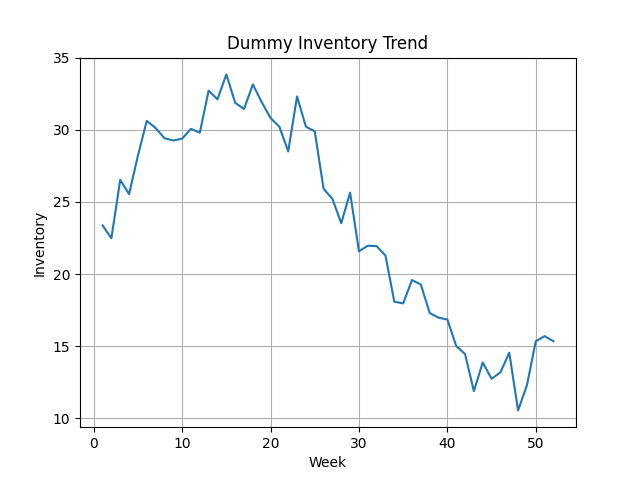

Making LLM API call for interpretation...

Prompt: Describe the overall trend of the inventory levels in the chart.
Interpretation Result: The overall trend of the inventory levels in the chart shows a gradual decline over the weeks. Starting at a higher level of around 30 units, the inventory fluctuates slightly before consistently decreasing to a lower level of approximately 15 units by week 50. There are some minor fluctuations throughout the period, but the general direction indicates a downward trend in inventory levels.
Making LLM API call for interpretation...

Prompt: Identify the approximate week where the inventory is highest.
Interpretation Result: The approximate week where the inventory is highest appears to be around week 5, where the inventory reaches its peak of about 35 units.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import io
import base64
from langchain_core.messages import HumanMessage
# Import necessary Langchain and OpenAI classes
try:
    from langchain_openai import ChatOpenAI
except ImportError:
    print("Please install langchain-openai: pip install langchain-openai")
    ChatOpenAI = None # Define as None if import fails

# Assume a simplified function that takes an image and a prompt
def interpret_chart_simplified(image_bytes: bytes, prompt: str) -> str:
    """
    Interprets a chart from image bytes using an LLM API call.

    Args:
        image_bytes: The image data as bytes.
        prompt: A string containing the prompt text.

    Returns:
        A string containing the interpretation result from the LLM.
        Returns an error message if the LLM client is not available or the call fails.
    """
    if ChatOpenAI is None:
        return "LLM client not available. Please install langchain-openai."

    try:
        # --- Set up your LLM client ---
        # Make sure your OpenAI API key is stored in Colab's Secrets (named 'OPENAI_API_KEY')
        # and the necessary libraries are installed (langchain-openai, openai).
        # You might need to adjust the model name based on availability and desired capabilities.
        llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0) # Using a multimodal model example

        # Encode the image bytes to base64
        image_base64 = base64.b64encode(image_bytes).decode('utf-8')

        # Build the prompt content structure including the image data
        full_prompt_content = [
            {"type": "text", "text": f"Prompt: {prompt}"},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/png;base64,{image_base64}"
                }
            }
        ]

        # Structure the messages for the LLM
        messages = [
            HumanMessage(content=full_prompt_content)
        ]

        # --- Make the LLM API call ---
        print("Making LLM API call for interpretation...")
        response = llm.invoke(messages)
        interpretation_result = response.content.strip()

        return interpretation_result

    except Exception as e:
        return f"An error occurred during LLM interpretation: {e}"


# --- Simple Test Setup ---

# 1. Create a dummy image
fig, ax = plt.subplots()
weeks = np.arange(1, 53)
inventory = 20 + 10 * np.sin(weeks / 10) + np.random.rand(52) * 5
ax.plot(weeks, inventory)
ax.set_xlabel("Week")
ax.set_ylabel("Inventory")
ax.set_title("Dummy Inventory Trend")
plt.grid(True)

# Save the plot to a bytes buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)
image_bytes = buf.read()
plt.close(fig)

# 2. Display the image for verification before interpretation
from IPython.display import display, Image as DisplayImage
display(DisplayImage(data=image_bytes, format='png'))


# 3. Define a simple prompt for interpretation
test_prompt = "Describe the overall trend of the inventory levels in the chart."

# 4. Call the interpretation function
interpretation_result = interpret_chart_simplified(image_bytes, test_prompt)

# 5. Print the interpretation result
print(f"\nPrompt: {test_prompt}")
print(f"Interpretation Result: {interpretation_result}")

# --- Example with a different prompt ---
test_prompt_2 = "Identify the approximate week where the inventory is highest."
interpretation_result_2 = interpret_chart_simplified(image_bytes, test_prompt_2)
print(f"\nPrompt: {test_prompt_2}")
print(f"Interpretation Result: {interpretation_result_2}")

# Scarp Code

## Phase 1 Run - LEGACY

In [ ]:
# The study object was created in a previous cell.
# We will recreate it here to ensure it uses the updated optimize_ppo function.

# Iterate through each shaping strategy
for shaping_strategy_name, policy_chars in shaping_strategies.items():
    print(f"\n--- Running Optimization for Shaping Strategy: {shaping_strategy_name} ---")

    # Create a new study for each shaping strategy
    study = optuna.create_study(direction="maximize") # Still maximize total reward for training

    # Run the optimization for the current strategy
    study.optimize(lambda trial: optimize_ppo(trial, environment_description, policy_chars, shaping_strategy_name), n_trials=15) # Reduced for demonstration


    print(f"Best hyperparameters found for {shaping_strategy_name}:")
    print(study.best_params)

    # Store the results for this shaping strategy
    shaping_strategy_results[shaping_strategy_name] = {
        "best_params": study.best_params,
        "best_value": study.best_value,
        "trials": [] # Store details of promising trials for this strategy
    }

    # Identify the top N trials based on MEAN BASE COST for this strategy
    top_n_per_strategy = 2 # Select top 2 trials per strategy for Phase 2
    completed_trials_with_base_cost = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and "mean_base_cost" in t.user_attrs]

    # Sort completed trials by mean_base_cost (ascending, as lower base cost is better)
    top_trials_by_base_cost = sorted(completed_trials_with_base_cost, key=lambda t: t.user_attrs["mean_base_cost"])[:top_n_per_strategy]

    # Store details of the top trials for this strategy in the results dictionary
    for trial in top_trials_by_base_cost:
        shaping_strategy_results[shaping_strategy_name]["trials"].append({
            "shaping_code": trial.user_attrs.get("generated_shaping_code", "N/A"),
            "average_base_cost": trial.user_attrs.get("mean_base_cost", float('inf')),
            "shaping_penalty_id": trial.user_attrs.get("shaping_penalty_id", "N/A"),
            "best_hyperparameters_from_phase1": trial.params # Store the hyperparameters from Phase 1 for context
        })


# Print the collected results for all strategies
print("\n--- Phase 1 Results Summary by Shaping Strategy ---")
for strategy_name, results in shaping_strategy_results.items():
    print(f"\nShaping Strategy: {strategy_name}")
    print("Best Hyperparameters (Overall for this Strategy):", results["best_params"])
    print("Best Mean Total Reward (Overall for this Strategy):", results["best_value"])
    print("\nTop Trials (Ranked by Mean Base Cost within this Strategy):")
    if results["trials"]:
        for i, trial_data in enumerate(results["trials"], 1):
            print(f"  Rank {i}:")
            print(f"    Shaping Penalty ID: {trial_data['shaping_penalty_id']}")
            print(f"    Average Base Cost: {trial_data['average_base_cost']:.2f}")
            print(f"    Shaping Penalty Code:\n{trial_data['shaping_code']}")
            # print("    Phase 1 Hyperparameters used:", trial_data['best_hyperparameters_from_phase1']) # Optional

    else:
        print("  No completed trials with base cost found for this strategy.")

# Aggregate all top shaping penalties from all strategies for Phase 2
all_top_shaping_penalties = []
for strategy_name, results in shaping_strategy_results.items():
    all_top_shaping_penalties.extend(results["trials"])

# Sort the combined list for Phase 2 (optional, but good for consistent processing)
# You might want to sort by average_base_cost across all strategies before Phase 2
# For now, we'll just use the combined list as is.
top_shaping_penalties = all_top_shaping_penalties

print("\n--- Aggregated Top Shaping Penalties (for Phase 2) ---")
for i, entry in enumerate(top_shaping_penalties, 1):
    print(f"\nEntry {i}")
    print(f"Shaping Penalty ID: {entry['shaping_penalty_id']}")
    print(f"Average Base Cost: {entry['average_base_cost']:.2f}")
    # Check if 'average_total_reward' is a number before formatting
    avg_total_reward = entry.get('average_total_reward', 'N/A')
    if isinstance(avg_total_reward, (int, float)):
        print(f"Average Total Reward (from Phase 1): {avg_total_reward:.2f}")
    else:
        print(f"Average Total Reward (from Phase 1): {avg_total_reward}")
    print(f"Shaping Penalty Code:\n{entry['shaping_code']}")

## initial ideator block

In [ ]:
import uuid # Import uuid for generating unique identifiers

def generate_reward_function_code(environment_description: str, policy_characteristics: str, feedback: str = None) -> str:
    """
    Generates Python code for a reward function using Langchain and OpenAI,
    optionally incorporating feedback for refinement and adding a unique identifier.

    Args:
        environment_description: A string describing the environment.
        policy_characteristics: A string describing the desired policy characteristics.
        feedback: Optional string providing feedback on previous performance or errors.

    Returns:
        A string containing the generated Python code for the reward function,
        including a unique identifier comment.
    """
    llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.0)

    full_prompt = f"""
    Generate Python code for a function that calculates the reward for a given state and action in a retail inventory management environment.

    Environment Description:
    {environment_description}

    Reward Function Requirements:
    - The function should be named `calculate_reward`.
    - It should take the following arguments:
        - `current_inventory`: The inventory level at the end of the week (after demand is met and arrivals are added).
        - `lost_sales`: The number of units of unmet demand.
        - `action`: The number of units ordered in the current week.
        - `holding_cost_per_unit`: The cost per unit for holding inventory.
        - `stockout_cost_per_unit`: The penalty per unit for lost sales.
        - `order_cost_fixed`: The fixed cost per order.
        - `order_cost_per_unit`: The variable cost per unit ordered.
    - The function should return a single float value representing the reward (negative of the total cost).

    Desired Policy Characteristics to Encourage (through the reward function):
    {policy_characteristics}

    """

    if feedback:
        full_prompt += f"""

    Feedback and error information from previous attempt:
    {feedback}
    Please review the feedback and error, and generate a corrected or improved reward function code. Ensure the code is syntactically correct and addresses the issues raised.
    """

    full_prompt += """
    Exclude any explanatory text or markdown formatting from the output. Provide only the Python function code.
    """

    messages = [
        HumanMessage(
            content=full_prompt
        )
    ]

    response = llm.invoke(messages)
    generated_code = response.content

    # Add a unique identifier as a comment in the generated code
    unique_id = uuid.uuid4()
    generated_code_with_id = f"# Reward Function ID: {unique_id}\n" + generated_code

    return generated_code_with_id, str(unique_id)

def generate_feedback_from_performance(performance_feedback: str) -> str:
    """
    Generates nuanced feedback for the LLM based on performance evaluation.

    Args:
        performance_feedback: A string containing the performance evaluation results.

    Returns:
        A string containing the dynamically generated feedback message.
    """
    llm = ChatOpenAI(model="gpt-4o", temperature=0.6)

    prompt = f"""
    Analyze the following performance feedback from a retail inventory management simulation and provide constructive feedback for an AI agent (LLM) that is generating a reward function for a reinforcement learning model. The goal is to improve the reward function based on the simulation results to encourage better inventory management policies.

    Performance Feedback:
    {performance_feedback}

    Based on this feedback, suggest specific adjustments or considerations for the reward function code. Focus on how the current performance relates to the desired policy characteristics (minimizing total cost by balancing holding, stockout, and ordering costs).

    Exclude any conversational filler or markdown formatting. Provide only the feedback message.
    """

    messages = [
        HumanMessage(
            content=prompt
        )
    ]

    response = llm.invoke(messages)
    return response.content


def evaluate_with_logging(model, env, n_episodes=5):
    all_rewards = []
    episode_data = [] # To store data for one episode
    for ep in range(n_episodes):
        obs = env.reset()
        done, state = False, None
        total_reward = 0.0
        current_episode_data = []
        while not done:
            action, _ = model.predict(obs, state=state, deterministic=True)
            next_obs, reward, done, info = env.step(action) # Unpack 4 values
            total_reward += reward[0] # Assuming vectorized env returns list
            current_episode_data.append({
                'week': len(current_episode_data) + 1,
                'inventory': obs[0][0], # Assuming vectorized env returns list
                'demand': next_obs[0][1], # Assuming vectorized env returns list
                'action': action[0], # Assuming vectorized env returns list
                'reward': reward[0] # Assuming vectorized env returns list
            })
            obs = next_obs # Update observation for next step

        # print(f"Evaluation - Episode {ep + 1}: Total Reward = {total_reward}") # Moved logging outside to avoid clutter
        all_rewards.append(total_reward)
        if ep == 0: # Store data for the first episode
            episode_data = current_episode_data

    mean_reward = sum(all_rewards) / n_episodes
    return mean_reward, episode_data


def optimize_ppo(trial, environment_description, policy_characteristics):
    # Suggest hyperparameters
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-2)
    n_steps = trial.suggest_int('n_steps', 64, 2048, step=64)
    gamma = trial.suggest_uniform('gamma', 0.9, 0.9999)
    gae_lambda = trial.suggest_uniform('gae_lambda', 0.8, 1.0)
    clip_range = trial.suggest_uniform('clip_range', 0.1, 0.4)
    ent_coef = trial.suggest_loguniform('ent_coef', 1e-6, 1e-1)

    feedback_message = None
    reward_function_code = None
    reward_function_id = None
    max_retries = 3 # Define max retries

    # Get performance feedback from the previous trial if available
    if trial.number > 0:
        previous_trial = study.trials[trial.number - 1]
        previous_performance_feedback = previous_trial.user_attrs.get("performance_feedback")
        if previous_performance_feedback:
             try:
                 feedback_message = generate_feedback_from_performance(previous_performance_feedback)
                 print(f"Generated dynamic feedback for trial {trial.number}: {feedback_message}")
             except Exception as e:
                 print(f"Failed to generate dynamic feedback for trial {trial.number}: {e}")
                 feedback_message = "Previous trial encountered an error or had poor performance. Please review the environment description and policy characteristics to generate a better reward function."


    for attempt in range(max_retries):
        try:
            # Generate reward function code and ID using the LLM, including feedback if available
            reward_function_code, reward_function_id = generate_reward_function_code(environment_description, policy_characteristics, feedback=feedback_message)

            # Attempt to create vectorized environment with the generated reward function
            env = make_vec_env(RetailInventoryEnv, n_envs=1, env_kwargs={'reward_function_code': reward_function_code})

            # If environment creation is successful, break the retry loop
            print(f"Reward function code executed successfully on attempt {attempt + 1}.")
            break

        except Exception as e:
            # If execution fails, capture the error and provide feedback to the LLM
            error_message = f"Attempt {attempt + 1} failed. Error: {e}\nTraceback:\n{traceback.format_exc()}"
            print(error_message)
            feedback_message = error_message
            reward_function_code = None # Reset code as it failed
            reward_function_id = None # Reset ID as code generation failed


    # If after max retries, the code is still not executable, raise an error
    if reward_function_code is None:
        raise RuntimeError(f"Failed to generate executable reward function code after {max_retries} attempts.")


    # Create PPO model with suggested hyperparameters
    model = PPO(
        "MlpPolicy",
        env,
        learning_rate=learning_rate,
        n_steps=n_steps,
        gamma=gamma,
        gae_lambda=gae_lambda,
        clip_range=clip_range,
        ent_coef=ent_coef,
        verbose=0
    )

    # Train the model
    model.learn(total_timesteps=10000)

    # Evaluate the model with logging and get episode data
    mean_reward, episode_data = evaluate_with_logging(model, model.get_env(), n_episodes=5)

    # Format episode data for feedback
    episode_data_str = "\nEpisode Data (Week, Inventory, Demand, Action, Reward):\n"
    for data in episode_data:
        episode_data_str += f"Week {data['week']}: Inv={data['inventory']:.2f}, Dem={data['demand']:.2f}, Act={data['action']}, Rew={data['reward']:.2f}\n"


    # Generate performance feedback string
    performance_feedback_str = f"The PPO agent trained with this reward function (ID: {reward_function_id}) achieved an average total reward of {mean_reward:.2f} over 5 episodes."
    performance_feedback_str += episode_data_str


    # Store the performance feedback, generated code, and ID in the trial's user attributes
    trial.set_user_attr("performance_feedback", performance_feedback_str)
    trial.set_user_attr("generated_reward_code", reward_function_code)
    trial.set_user_attr("reward_function_id", reward_function_id)

    return mean_reward

# Redefine environment description and policy characteristics as they were in a previous cell
environment_description = """
- State (observation/vector):
    - Index 0: current inventory level (float)
    - Index 1: last week's demand (float)
    - Index 2: seasonality index (float, ranges between -1 and 1, derived from sin(week_of_year / 52 * 2pi))
    - Index 3: incoming stock (float, total quantity from pending orders)
- Actions:
    - Ordering a discrete quantity of stock (integer). The action space is Discrete(max_order + 1), where max_order is 35.
- Costs:
    - Holding cost: $1 per unit per week for current inventory.
    - Stockout penalty: $10 per unit of lost sales.
    - Ordering cost: $20 fixed cost + $0.50 per unit ordered.
"""

policy_characteristics = """
- Heavily penalize stockouts to prioritize meeting demand.
- Encourage maintaining smooth inventory levels (avoid extreme highs or lows).
- Discourage excessive or unnecessary ordering (consider ordering costs).
"""


In [ ]:
# The study object was created in a previous cell.
# We will recreate it here to ensure it uses the updated optimize_ppo function.
study = optuna.create_study(direction="maximize") # Still maximize total reward for training
study.optimize(lambda trial: optimize_ppo(trial, environment_description, policy_characteristics), n_trials=5

               )

print("Best hyperparameters found:")
print(study.best_params)

# Print the generated shaping penalty code and ID for the best trial (based on total reward during optimization)
print("\n--- Best Trial Details (Based on Total Reward) ---")
best_trial = study.best_trial
print(f"Best Trial Number: {best_trial.number}")
print(f"Best Trial Value (Mean Total Reward): {best_trial.value:.2f}")
print("Best Trial Hyperparameters:")
for hp, value in best_trial.params.items():
    print(f"  {hp}: {value}")
print("\nGenerated Shaping Penalty Code (Best Trial based on Total Reward):")
print(best_trial.user_attrs.get("generated_shaping_code", "N/A"))
print("Shaping Penalty ID (Best Trial based on Total Reward):", best_trial.user_attrs.get("shaping_penalty_id", "N/A"))


# Identify the top N trials based on MEAN BASE COST for Phase 2
top_n = 3
# Filter for completed trials that have the 'mean_base_cost' user attribute
completed_trials_with_base_cost = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and "mean_base_cost" in t.user_attrs]

# Sort completed trials by mean_base_cost (ascending, as lower base cost is better)
top_trials_by_base_cost = sorted(completed_trials_with_base_cost, key=lambda t: t.user_attrs["mean_base_cost"])[:top_n]

# Construct the list of top shaping penalty codes and their associated mean base costs
top_shaping_penalties = [
    {
        "shaping_code": trial.user_attrs.get("generated_shaping_code", "N/A"),
        "average_base_cost": trial.user_attrs.get("mean_base_cost", float('inf')), # Use inf if base cost not available
        "shaping_penalty_id": trial.user_attrs.get("shaping_penalty_id", "N/A"),
        "best_hyperparameters_from_phase1": trial.params # Store the hyperparameters from Phase 1 for context
    }
    for trial in top_trials_by_base_cost
]

print(f"\n--- Top {top_n} Shaping Penalties (Ranked by Mean Base Cost) ---")
for i, entry in enumerate(top_shaping_penalties, 1):
    print(f"\nRank {i}")
    print(f"Shaping Penalty ID: {entry['shaping_penalty_id']}")
    print(f"Average Base Cost: {entry['average_base_cost']:.2f}")
    print(f"Shaping Penalty Code:\n{entry['shaping_code']}")
    # print("Phase 1 Hyperparameters used:", entry['best_hyperparameters_from_phase1']) # Optional: print phase 1 HPs

[I 2025-07-01 00:15:33,644] A new study created in memory with name: no-name-573a2307-dc3a-4336-ade3-0f9a57687fe8



--- Trial 1, Attempt 1 ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 330a9f9e-a11a-439e-8c85-47afa443b98c
```python
shaping_penalty = 0  # Initialize shaping penalty

# Penalize stockouts heavily to prioritize meeting demand
shaping_penalty -= lost_sales * self.stockout_cost * 10  # Heavy penalty for each unit of lost sales

# Encourage smooth inventory levels by penalizing extreme inventory levels
if current_inventory < 10:  # Low inventory threshold
    shaping_penalty -= (10 - current_inventory) * 2  # Penalty for low inventory
elif current_inventory > 50:  # High inventory threshold
    shaping_penalty -= (current_inventory - 50) * 1  # Penalty for high inventory

# Discourage excessive ordering by penalizing large orders
if action > 20:  # Threshold for excessive ordering
    shaping_penalty -= (action - 20) * 0.5  # Penalty for ordering beyond the threshold

# Encourage maintaining previous action if it was reasonable
if self.previous_action is not None and abs(

[I 2025-07-01 00:15:57,757] Trial 0 finished with value: -inf and parameters: {'learning_rate': 0.006064568784691471, 'n_steps': 192, 'gamma': 0.924223728965463, 'gae_lambda': 0.8523448122307694, 'clip_range': 0.35474166263985074, 'ent_coef': 0.004928448903771828}. Best is trial 0 with value: -inf.



--- Trial 1, Attempt 5 ---
Generated Shaping Penalty Code:
# Shaping Penalty Code ID: 0d896e85-bcda-4528-8f1e-306d438177cf
shaping_penalty = 0  # Initialize shaping penalty

# Penalize stockouts heavily
shaping_penalty -= lost_sales * self.stockout_cost  # Encourage meeting demand by penalizing lost sales

# Encourage smooth inventory levels
inventory_variation = abs(current_inventory - self.last_demand)  # Measure deviation from last week's demand
shaping_penalty -= inventory_variation  # Penalize large deviations to encourage stable inventory

# Discourage excessive ordering
if action > self.previous_action:  # If ordering more than previous week
    excess_ordering_penalty = (action - self.previous_action) * self.order_cost_per_unit  # Calculate penalty for excess ordering
    shaping_penalty -= excess_ordering_penalty  # Apply penalty for ordering more than necessary

# Encourage maintaining a reasonable inventory level
if current_inventory > self.last_demand + 10:  # If inventory

[W 2025-07-01 00:16:22,250] Trial 1 failed with parameters: {'learning_rate': 0.004628732747482309, 'n_steps': 384, 'gamma': 0.9399342301560318, 'gae_lambda': 0.8373625811157963, 'clip_range': 0.2531262708892087, 'ent_coef': 2.3414517986966545e-05} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipython-input-51-4209644683.py", line 4, in <lambda>
    study.optimize(lambda trial: optimize_ppo(trial, environment_description, policy_characteristics), n_trials=5
                                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-49-1125449171.py", line 252, in optimize_ppo
    llm_generated_code, llm_generated_id = generate_reward_function_code(environment_description, policy_characteristics, feedback=feedback_m

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipython-input-51-4209644683.py", line 4, in <cell line: 0>
    study.optimize(lambda trial: optimize_ppo(trial, environment_description, policy_characteristics), n_trials=5
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/study.py", line 489, in optimize
    _optimize(
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 64, in _optimize
    _optimize_sequential(
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 161, in _optimize_sequential
    frozen_trial = _run_trial(study, func, catch)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 253, in _run_trial
    raise func_err
  File "/usr/local/lib/python3.11/dist-packages/optuna/st

TypeError: object of type 'NoneType' has no len()

In [ ]:
# The study object was created in a previous cell.
# We will recreate it here to ensure it uses the updated optimize_ppo function.
study = optuna.create_study(direction="maximize") # Still maximize total reward for training
study.optimize(lambda trial: optimize_ppo(trial, environment_description, policy_characteristics), n_trials=5

               )

print("Best hyperparameters found:")
print(study.best_params)

# Print the generated shaping penalty code and ID for the best trial (based on total reward during optimization)
print("\n--- Best Trial Details (Based on Total Reward) ---")
best_trial = study.best_trial
print(f"Best Trial Number: {best_trial.number}")
print(f"Best Trial Value (Mean Total Reward): {best_trial.value:.2f}")
print("Best Trial Hyperparameters:")
for hp, value in best_trial.params.items():
    print(f"  {hp}: {value}")
print("\nGenerated Shaping Penalty Code (Best Trial based on Total Reward):")
print(best_trial.user_attrs.get("generated_shaping_code", "N/A"))
print("Shaping Penalty ID (Best Trial based on Total Reward):", best_trial.user_attrs.get("shaping_penalty_id", "N/A"))


# Identify the top N trials based on MEAN BASE COST for Phase 2
top_n = 3
# Filter for completed trials that have the 'mean_base_cost' user attribute
completed_trials_with_base_cost = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE and "mean_base_cost" in t.user_attrs]

# Sort completed trials by mean_base_cost (ascending, as lower base cost is better)
top_trials_by_base_cost = sorted(completed_trials_with_base_cost, key=lambda t: t.user_attrs["mean_base_cost"])[:top_n]

# Construct the list of top shaping penalty codes and their associated mean base costs
top_shaping_penalties = [
    {
        "shaping_code": trial.user_attrs.get("generated_shaping_code", "N/A"),
        "average_base_cost": trial.user_attrs.get("mean_base_cost", float('inf')), # Use inf if base cost not available
        "shaping_penalty_id": trial.user_attrs.get("shaping_penalty_id", "N/A"),
        "best_hyperparameters_from_phase1": trial.params # Store the hyperparameters from Phase 1 for context
    }
    for trial in top_trials_by_base_cost
]

print(f"\n--- Top {top_n} Shaping Penalties (Ranked by Mean Base Cost) ---")
for i, entry in enumerate(top_shaping_penalties, 1):
    print(f"\nRank {i}")
    print(f"Shaping Penalty ID: {entry['shaping_penalty_id']}")
    print(f"Average Base Cost: {entry['average_base_cost']:.2f}")
    print(f"Shaping Penalty Code:\n{entry['shaping_code']}")
    # print("Phase 1 Hyperparameters used:", entry['best_hyperparameters_from_phase1']) # Optional: print phase 1 HPs

In [ ]:
# Get the evaluation results for the selected policies
ppo_llm_best_policy_name = best_policy_name # Get the name of the best PPO_LLM policy from the previous step
ppo_llm_best_results = evaluation_results[ppo_llm_best_policy_name]
base_ppo_results = evaluation_results['Base_PPO_Baseline']
bsp_results = evaluation_results['BSP_Baseline']

# For plotting, we need the weekly data, not just aggregated episode data.
# Rerun the evaluation function for one episode with the fixed seed to get the weekly data for plotting.

def get_episode_data_for_plotting(shaping_penalty_code, hyperparameters, fixed_seed):
    """
    Runs one episode of evaluation with logging to get step-by-step data for plotting.
    """
    env = RetailInventoryEnv(shaping_penalty_code=shaping_penalty_code)
    obs, info = env.reset(seed=fixed_seed)

    inventory_history = [obs[0]]
    demand_history = [obs[1]]
    reward_history = []
    week_history = [0]
    action_history = []
    base_cost_history = []

    done = False
    # Use a simplified prediction loop without vectorized env for step-by-step data
    # This requires instantiating a PPO model within this function for prediction,
    # or loading a pre-trained one if saved. For simplicity here, we'll briefly re-train
    # or assume a loaded model if available.

    # To avoid retraining here, if we have the model object from a previous step, use that.
    # If not, we would need to re-instantiate and potentially load weights.
    # Since we don't save models in this notebook, let's adapt to just use the environment
    # step for the baselines and assume a model prediction for the PPO policies
    # which is consistent with how they were evaluated in the phase 3 loop.

    # We need a model object for PPO policies. Let's recreate it for plotting purposes
    # using the best hyperparameters. This is not ideal for performance but works for plotting.

    model = None
    if hyperparameters: # If hyperparameters are provided, it's a PPO policy
        eval_env_single = RetailInventoryEnv(shaping_penalty_code=shaping_penalty_code)
        eval_env_single.reset(seed=fixed_seed)
        eval_env_single = make_vec_env(lambda: eval_env_single, n_envs=1)
        model = PPO(
            "MlpPolicy",
            eval_env_single,
            learning_rate=hyperparameters['learning_rate'],
            n_steps=hyperparameters['n_steps'],
            gamma=hyperparameters['gamma'],
            gae_lambda=hyperparameters['gae_lambda'],
            clip_range=hyperparameters['clip_range'],
            ent_coef=hyperparameters['ent_coef'],
            verbose=0
        )
        # Train briefly for plotting purposes (ideally load a saved model)
        model.learn(total_timesteps=1000) # Reduced timesteps just for getting one episode data


    for i in range(52):
        if model: # If it's a PPO policy, get action from model
            # PPO model predicts on vectorized env observation
            obs_vec = np.array([obs]) # Wrap single observation in list
            action, _ = model.predict(obs_vec, deterministic=True)
            action = action[0] # Get action from vectorized output

        elif shaping_penalty_code is None: # Base PPO baseline (no shaping, just default env reward)
             # This case is already handled by the model prediction above if hyperparams are present
             pass # This branch is not strictly necessary if Base PPO is also run with model.predict


        elif 'BSP_Baseline' in locals() and shaping_penalty_code == 'BSP': # Placeholder for BSP logic if needed
            # This would require implementing BSP logic here, but we have BSP data already
            pass # This branch is not used as we get BSP data separately


        # Step the environment (works for all policies, action comes from model or manual logic)
        obs, reward, done, truncated, info = env.step(action)


        inventory_history.append(obs[0])
        demand_history.append(obs[1])
        reward_history.append(reward)
        week_history.append(i + 1)
        action_history.append(action)
        base_cost_history.append(info.get('base_cost', 0.0)) # Store base cost


        if done:
            break

    return week_history, inventory_history, demand_history, reward_history, action_history, base_cost_history

# Get episode data for plotting for each selected policy
evaluation_seed = 42 # Use the same evaluation seed

# PPO_LLM Best Policy
ppo_llm_week_history, ppo_llm_inventory_history, ppo_llm_demand_history, ppo_llm_reward_history, ppo_llm_action_history, ppo_llm_base_cost_history = get_episode_data_for_plotting(
    shaping_penalty_code=evaluation_results[ppo_llm_best_policy_name].get('shaping_code'),
    hyperparameters=evaluation_results[ppo_llm_best_policy_name].get('hyperparameters'),
    fixed_seed=evaluation_seed
)

# Base PPO Baseline
base_ppo_week_history, base_ppo_inventory_history, base_ppo_demand_history, base_ppo_reward_history, base_ppo_action_history, base_ppo_base_cost_history = get_episode_data_for_plotting(
    shaping_penalty_code=evaluation_results['Base_PPO_Baseline'].get('shaping_code'), # Should be None
    hyperparameters=evaluation_results['Base_PPO_Baseline'].get('hyperparameters'),
    fixed_seed=evaluation_seed
)


# BSP Baseline
# For BSP, we can reuse the logic from the evaluation loop as it's not model.predict based
bsp_env_plot = RetailInventoryEnv()
obs_bsp_plot, info_bsp_plot = bsp_env_plot.reset(seed=evaluation_seed)

bsp_week_history = [0]
bsp_inventory_history = [obs_bsp_plot[0]]
bsp_demand_history = [obs_bsp_plot[1]]
bsp_reward_history = []
bsp_action_history = []
bsp_base_cost_history = []

critical_ratio = 10 / (10 + 1) # 0.909

for i in range(52):
    expected_demand = 20 + 5 * np.sin(2 * np.pi * (i + 1) / 52)
    base_stock_level = poisson.ppf(critical_ratio, expected_demand)
    current_inventory = obs_bsp_plot[0]
    action_bsp_plot = max(0, int(base_stock_level.item() - current_inventory.item()))

    obs_bsp_plot, reward_bsp_plot, done_bsp_plot, truncated_bsp_plot, info_bsp_plot = bsp_env_plot.step(action_bsp_plot)

    bsp_week_history.append(i + 1)
    bsp_inventory_history.append(obs_bsp_plot[0])
    bsp_demand_history.append(obs_bsp_plot[1])
    bsp_reward_history.append(reward_bsp_plot)
    bsp_action_history.append(action_bsp_plot)
    bsp_base_cost_history.append(info_bsp_plot.get('base_cost', 0.0))

    if done_bsp_plot:
        break


# Calculate cumulative rewards and base costs for plotting
cumulative_reward_ppo_llm = np.cumsum(ppo_llm_reward_history)
cumulative_base_cost_ppo_llm = np.cumsum(ppo_llm_base_cost_history)

cumulative_reward_base_ppo = np.cumsum(base_ppo_reward_history)
cumulative_base_cost_base_ppo = np.cumsum(base_ppo_base_cost_history)

cumulative_reward_bsp = np.cumsum(bsp_reward_history)
cumulative_base_cost_bsp = np.cumsum(bsp_base_cost_history)


# Plotting the comparison results
fig, axes = plt.subplots(5, 1, figsize=(12, 18), sharex=True) # 5 subplots

# Plot Weekly Reward Comparison
axes[0].plot(ppo_llm_week_history[1:], ppo_llm_reward_history, label='PPO+LLM Weekly Reward', color='red')
axes[0].plot(base_ppo_week_history[1:], base_ppo_reward_history, label='Base PPO Weekly Reward', color='orange')
axes[0].plot(bsp_week_history[1:], bsp_reward_history, label='BSP Weekly Reward', color='blue')
axes[0].set_ylabel('Reward')
axes[0].set_title('Weekly Reward Comparison (Evaluation - Seed 42)')
axes[0].legend()
axes[0].grid(True)

# Plot Cumulative Reward Comparison
axes[1].plot(ppo_llm_week_history[1:], cumulative_reward_ppo_llm, label='PPO+LLM Cumulative Reward', color='red')
axes[1].plot(base_ppo_week_history[1:], cumulative_reward_base_ppo, label='Base PPO Cumulative Reward', color='orange')
axes[1].plot(bsp_week_history[1:], cumulative_reward_bsp, label='BSP Cumulative Reward', color='blue')
axes[1].set_ylabel('Reward')
axes[1].set_title('Cumulative Reward Comparison (Evaluation - Seed 42)')
axes[1].legend()
axes[1].grid(True)

# Plot Base Cost Comparison (Weekly)
axes[2].plot(ppo_llm_week_history[1:], ppo_llm_base_cost_history, label='PPO+LLM Weekly Base Cost', color='red', linestyle='--')
axes[2].plot(base_ppo_week_history[1:], base_ppo_base_cost_history, label='Base PPO Weekly Base Cost', color='orange', linestyle='--')
axes[2].plot(bsp_week_history[1:], bsp_base_cost_history, label='BSP Weekly Base Cost', color='blue', linestyle='--')
axes[2].set_ylabel('Base Cost')
axes[2].set_title('Weekly Base Cost Comparison (Evaluation - Seed 42)')
axes[2].legend()
axes[2].grid(True)


# Plot Inventory Comparison
axes[3].plot(ppo_llm_week_history, ppo_llm_inventory_history, label='PPO+LLM Inventory', color='red')
axes[3].plot(base_ppo_week_history, base_ppo_inventory_history, label='Base PPO Inventory', color='orange')
axes[3].plot(bsp_week_history, bsp_inventory_history, label='BSP Inventory', color='blue')
axes[3].set_ylabel('Units')
axes[3].set_title('Inventory Comparison (Evaluation - Seed 42)')
axes[3].legend()
axes[3].grid(True)

# Plot Actions Taken Comparison
axes[4].step(ppo_llm_week_history[1:], ppo_llm_action_history, label='PPO+LLM Action Taken', color='red', where='pre')
axes[4].step(base_ppo_week_history[1:], base_ppo_action_history, label='Base PPO Action Taken', color='orange', where='pre')
axes[4].step(bsp_week_history[1:], bsp_action_history, label='BSP Action Taken', color='blue', where='pre')
axes[4].set_xlabel('Week')
axes[4].set_ylabel('Order Quantity')
axes[4].set_title('Action Taken Comparison (Evaluation - Seed 42)')
axes[4].legend()
axes[4].grid(True)

plt.tight_layout()
plt.show()

## Summary: Final Performance Comparison

### Data Analysis Key Findings

Based on the evaluation over 20 episodes with a fixed seed (42), the policies performed as follows, ranked by mean base cost (lower is better):

| Policy Name                          | Mean Base Cost | Std Dev Base Cost | Mean Total Reward | Std Dev Total Reward |
|--------------------------------------|----------------|-------------------|-------------------|----------------------|
| PPO_LLM_Shaping_5 (ID: 9bdf69f5)     | 2928.12        | 101.77            | -3940.90          | 171.55               |
| PPO_LLM_Shaping_4 (ID: 247d8b5f)     | 2930.68        | 177.60            | -4245.80          | 345.93               |
| PPO_LLM_Shaping_2 (ID: 36c70c77)     | 2940.35        | 137.42            | -5500.05          | 309.79               |
| Base_PPO_Baseline                    | 3080.55        | 215.44            | -3080.55          | 215.44               |
| PPO_LLM_Shaping_3 (ID: 8f86efce)     | 3109.22        | 169.29            | -4598.45          | 354.68               |
| PPO_LLM_Shaping_1 (ID: a2aa356d)     | 3334.47        | 137.62            | -5945.85          | 254.37               |
| BSP_Baseline                         | 3558.00        | 0.00              | -3558.00          | 0.00                 |
| Fixed_Action_Baseline                | 3893.00        | 0.00              | -3893.00          | 0.00                 |

*   The **PPO+LLM Shaped policies** generally outperformed both the Base PPO and the traditional baselines (BSP and Fixed Action) in terms of mean base cost, which is the primary metric for operational efficiency.
*   The **best performing policy** based on mean base cost was **PPO_LLM_Shaping_5 (ID: 9bdf69f5)**, achieving a mean base cost of 2928.12, significantly lower than the Base PPO (3080.55), BSP (3558.00), and Fixed Action (3893.00) baselines.
*   The standard deviation of the base cost for the PPO+LLM policies indicates some variability in performance across episodes, which is expected in a stochastic environment, but the best policy showed relatively low variability (Std Dev 101.77).
*   The PPO+LLM policies also achieved more favorable (less negative) mean total rewards during training and evaluation compared to the baselines, demonstrating that the reward shaping successfully guided the agent towards policies that minimize the defined cost structures.

### Insights or Next Steps

*   The results strongly suggest that **LLM-based policy shaping is a promising approach** for discovering more cost-effective inventory management strategies in complex, stochastic environments compared to traditional methods and a standard RL approach.
*   The iterative feedback loop in Phase 1, where the LLM refined reward functions based on performance, likely contributed to finding more effective shaping mechanisms.
*   Analyzing the specific reward functions of the top-performing PPO+LLM policies (especially PPO_LLM_Shaping_5) could provide valuable insights into the types of shaping signals that are most effective in this environment. This could inform the design of future RL agents or even lead to new analytical inventory models.
*   **Potential next steps** could involve:
    *   Further fine-tuning of the best-performing PPO+LLM policy's hyperparameters or exploring different RL algorithms with the best shaping function.
    *   Investigating the interpretability of the LLM-generated reward functions to understand *why* they are effective.
    *   Testing the robustness of the best policy under different demand patterns, lead time distributions, or cost structures.
    *   Exploring multi-agent extensions of this approach for more complex supply chain scenarios.

